In [23]:
import time

from ib.ext.ContractDetails import ContractDetails
from ib.ext.EClientSocket import EClientSocket
from ib.opt import message
import numpy as np
import pandas as pd

import contracts
from settings import TWS_CONNECTION, company

In [24]:
class AllOptionsFor():
    """
    Class gets company name and returns list w/ dicts w/ all existing options for the company
    :company: str, company name (ticker), like 'AAPL' or 'TSLA',
    :return: dict w/ following items:
        * ['strike']: datetime in format '20191127  21:30:00',
        * ['expiration']: day-close or the latest in the day price in float format
                     or None if there was not any trade in that day
    """
    chain = []

    def __init__(self, company: str):
        self.wait = 30
        self.step = 1
        self.contract = contracts.Option(
            company,
            None,
            None,
            None
        )
        self.get_options()

    def get_options(self):
        self.run = True
        self.stop = False        
        TWS_CONNECTION.registerAll(print)
        TWS_CONNECTION.register(self.msg_handler, 'ContractDetails')
        TWS_CONNECTION.register(self.stop_handler, 'ContractDetailsEnd')
        TWS_CONNECTION.register(self.error_handler, message.Error)
        TWS_CONNECTION.connect()
        EClientSocket.reqContractDetails(TWS_CONNECTION, 1, self.contract)
        while not self.stop and self.wait:
            print(self.wait, self.stop)
            time.sleep(self.step)
            self.wait -= self.step
        while TWS_CONNECTION.isConnected():
            TWS_CONNECTION.disconnect()
        time.sleep(self.step / 2)
        self.run = False

    def stop_handler(self, msg):
        self.stop = True

    def msg_handler(self, msg):
        self.chain.append({
            'strike': msg.contractDetails.m_summary.m_strike,
            'expiration': msg.contractDetails.m_summary.m_expiry,
            'right': msg.contractDetails.m_summary.m_right
        })

    def error_handler(self, msg):
        # errors to pass away
        if msg.errorCode == 200:
            pass
        # errors to stop function
        if msg.errorCode == 162:  # no market data
            self.stop = True
        else:
            print(msg)
    # if msg.errorCode == 326:
    # 	self.stop = True
    # 	TWS_CONNECTION.clientId += 1
    # 	time.sleep(self.step * 2)
    # 	while TWS_CONNECTION.isConnected() and self.run:
    # 		if not self.run:
    # 			self.get_options()
    # if msg.errorCode in (2157, 2107):  # Data farm is temporary unavailable
    # 	self.stop = True
    # 	time.sleep(self.step * 2)
    # 	self.get_options()
    # if msg.errorMsg == '[Errno 54] Connection reset by peer':
    # 	self.stop = True
    # 	time.sleep(self.step * 2)
    # 	self.get_options()

In [25]:
class WeekPrices():
    """
    Class gets option Contract() object and returns dict w/ Datetime-Price items for the last week
    :contract: option Contract() object instance,
    :return: dict w/ following items:
        * ['Datetime']: datetime in format '20191127  21:30:00',
        * ['Price']: day-close or the latest in the day price in float format
                     or None if there was not any trade in that day
    """

    def __call__(self, contract):
        """
        How it works:
            ```python3
            option_prices = WeekPrices()
            option_prices(contract)
            ```
        """
        self.prices = {}
        self.contract = contract
        self.wait = 30
        self.stop = False
        self.step = 1
        self.get_prices()
        return self.prices

    def get_prices(self):
        self.stop = False
        TWS_CONNECTION.register(self.msg_handler, message.historicalData)
        TWS_CONNECTION.register(self.error_handler, message.Error)
        TWS_CONNECTION.registerAll(print)
        TWS_CONNECTION.connect()
        TWS_CONNECTION.reqHistoricalData(
            1,
            self.contract,
            '',
            '1 W',
            '30 mins',
            'TRADES',
            1,
            1
        )
        while not self.stop and self.wait:
            print(self.wait, self.stop)
            time.sleep(self.step)
            self.wait -= self.step
        while TWS_CONNECTION.isConnected():
            TWS_CONNECTION.disconnect()
        time.sleep(self.step / 2)

    def msg_handler(self, msg):
        """
        Function get message from TWS and put it into pandas DataFrame object
        :param msg: message from TWS
        :return: dataframe w/ historical prices
        """
        if 'finished-' in msg.date:
            self.stop = True
            return None
        self.prices[msg.date] = msg.close

    def error_handler(self, msg):
        # errors to pass away
        if msg.errorCode == 200:
            pass
        # errors to stop function
        if msg.errorCode == 162:  # no market data
            self.stop = True
        else:
            print(msg)
#         if msg.errorCode == 326:
#             self.stop = True
#             TWS_CONNECTION.clientId += 1
#             time.sleep(self.step * 1.5)
#             self.get_prices()
#         if msg.errorCode in (2157, 2107):  # Sec-def data farm connection is broken etc
#             self.stop = True
#             time.sleep(self.step * 1.5)
#             self.get_prices()
#         if msg.errorMsg == '[Errno 54] Connection reset by peer':
#             self.stop = True
#             time.sleep(self.step * 1.5)
#             self.get_prices()

In [28]:
def get_options_prices(company):
    """
    Function gets from TWS all options for the company
    and for each of this options gets from TWS Historical Data Farm prices for the last week
    (close prices with 30 mins interval)
    :return: pandas DataFrame where rows are Datetime, columns are MultiIndex:
             right, strike, expiration date and values are close prices.
    """
    table = pd.DataFrame(None, columns=pd.MultiIndex.from_product([[], [], []]))
    try:
        print(f'\n{time.now()} Getting option chain for {company}\n')
        options = AllOptionsFor(company)
        options = options.chain
        print(f'\n{time.now()}2. Found {len(options)} options\n')
        option_prices = WeekPrices()
        i = 1
        for option in options:
            expiration = option['expiration']
            strike = option['strike']
            right = option['right']
            contract = contracts.Option(
                company,
                expiration,
                strike,
                right
            )
            status = f'\n{time.now()}3. {i}/{len(options)} Retrieving prices for {right}-{strike}-{expiration} option\n'
            i += 1
            print(status)
            # print('\033[F\033[2K')
            prices = option_prices(contract)
            if not prices:
                continue
            columns = pd.MultiIndex.from_product([[right], [strike], [expiration]])
            values = prices.values()
            index = prices.keys()
            new_table = pd.DataFrame(values, index=index, columns=columns)
            table = table.join(new_table, how='outer')
        return table
    except KeyboardInterrupt:
        return table

In [27]:
prices = get_options_prices(company)
prices


1. Getting option chain for TSLA

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c872518>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c872518>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c872518>>
<contractDetails reqId=1, contractDetails=<ib.ext.Contract

<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.

<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.

<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
25 False
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDet

<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.

<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.

<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.

<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c83d278>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca0ef28>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca0ef28>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca0ef28>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca0ef28>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca0ef28>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca0ef28>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca0ef28>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca0ef28>>
<contractDetails reqId=1, contractDetails=<ib.

<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca0ef28>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca0ef28>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca0ef28>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca0ef28>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca0ef28>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca0ef28>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca0ef28>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca0ef28>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca0ef28>>
<contractDetails reqId=1, contractDetails=<ib.

<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c915ef0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c915ef0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c915ef0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c915ef0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c915ef0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c915ef0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c915ef0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c915ef0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c915ef0>>
<contractDetails reqId=1, contractDetails=<ib.

<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c915ef0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c915ef0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c915ef0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c915ef0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c915ef0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c915ef0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.

<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.

<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.

<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.

<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.

<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.

<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca6bb00>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca6bb00>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca6bb00>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca6bb00>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca6bb00>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca6bb00>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca6bb00>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca6bb00>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca6bb00>>
<contractDetails reqId=1, contractDetails=<ib.

<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca6bb00>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca6bb00>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca6bb00>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca6bb00>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca6bb00>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca6bb00>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca6bb00>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca6bb00>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca6bb00>>
<contractDetails reqId=1, contractDetails=<ib.

<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca6bb00>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca6bb00>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca6bb00>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca6bb00>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca6bb00>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca6bb00>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca6bb00>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca6bb00>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca6bb00>>
<contractDetails reqId=1, contractDetails=<ib.

<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.

<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.

<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c934160>>
<contractDetails reqId=1, contractDetails=<ib.

<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.

<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x10ae6eac8>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x10ae6eac8>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x10ae6eac8>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x10ae6eac8>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x10ae6eac8>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x10ae6eac8>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x10ae6eac8>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x10ae6eac8>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x10ae6eac8>>
<contractDetails reqId=1, contractDetails=<ib.

<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.

<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.

<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c915ef0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c915ef0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c915ef0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c915ef0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c915ef0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c915ef0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c915ef0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c915ef0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c915ef0>>
<contractDetails reqId=1, contractDetails=<ib.

<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c915ef0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c915ef0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c915ef0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c915ef0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c915ef0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c915ef0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c915ef0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c915ef0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c915ef0>>
<contractDetails reqId=1, contractDetails=<ib.

<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.

<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c915ef0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c915ef0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c915ef0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c915ef0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c915ef0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c915ef0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c915ef0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c915ef0>>
<contractDetails reqId=1, contractDetails=<ib.

<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
14 False
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11ca5fc88>>
<contractDetails reqId=1, contractDet

<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x10ae6eac8>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x10ae6eac8>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x10ae6eac8>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x10ae6eac8>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x10ae6eac8>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x10ae6eac8>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x10ae6eac8>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c915ef0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c915ef0>>
<contractDetails reqId=1, contractDetails=<ib.


3. 5/2900 Retrieving prices for C-195.0-20200117 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200117C00195000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service er


3. 10/2900 Retrieving prices for C-240.0-20200117 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200117C00240000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service e


3. 14/2900 Retrieving prices for C-265.0-20200117 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191129  19:00:00, open=67.75, high=67.75, low=67.75, close=67.75, volume=2, count=1, WAP=67.75, hasGaps=False>
<historicalData reqId=1, date=20191129  19:30:00, open=67.75, high=67.75,

<historicalData reqId=1, date=20191129  18:30:00, open=58.1, high=58.1, low=58.1, close=58.1, volume=1, count=1, WAP=58.1, hasGaps=False>
<historicalData reqId=1, date=20191129  19:00:00, open=58.1, high=58.1, low=58.1, close=58.1, volume=0, count=0, WAP=58.1, hasGaps=False>
<historicalData reqId=1, date=20191129  19:30:00, open=58.5, high=58.5, low=58.5, close=58.5, volume=1, count=1, WAP=58.5, hasGaps=False>
<historicalData reqId=1, date=20191129  20:00:00, open=58.5, high=58.5, low=58.5, close=58.5, volume=0, count=0, WAP=58.5, hasGaps=False>
<historicalData reqId=1, date=20191129  20:30:00, open=58.5, high=58.5, low=58.5, close=58.5, volume=0, count=0, WAP=58.5, hasGaps=False>
<historicalData reqId=1, date=20191202  18:00:00, open=61.95, high=61.95, low=61.95, close=61.95, volume=6, count=1, WAP=61.95, hasGaps=False>
<historicalData reqId=1, date=20191202  18:30:00, open=61.95, high=61.95, low=61.95, close=61.95, volume=0, count=0, WAP=61.95, hasGaps=False>
<historicalData reqId=1,


3. 18/2900 Retrieving prices for C-285.0-20200117 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191129  17:30:00, open=48.0, high=48.0, low=48.0, close=48.0, volume=1, count=1, WAP=48.0, hasGaps=False>
<historicalData reqId=1, date=20191129  18:00:00, open=48.0, high=48.0, low=48


3. 20/2900 Retrieving prices for C-295.0-20200117 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191129  17:30:00, open=40.0, high=40.0, low=40.0, close=40.0, volume=3, count=1, WAP=40.0, hasGaps=False>
<historicalData reqId=1, date=20191129  18:00:00, open=40.25, high=40.25, low=


3. 22/2900 Retrieving prices for C-305.0-20200117 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  20:00:00, open=34.95, high=34.95, low=34.95, close=34.95, volume=1, count=1, WAP=34.95, hasGaps=False>
<historicalData reqId=1, date=20191127  20:30:00, open=34.1, high=34.1, l


3. 24/2900 Retrieving prices for C-315.0-20200117 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
<historicalData reqId=1, date=20191127  17:30:00, open=30.4, high=30.4, low=30.21, close=30.21, volume=3, count=2, WAP=30.337, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=30.0, high


3. 26/2900 Retrieving prices for C-325.0-20200117 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
26 False
25 False
24 False
23 False
22 False
21 False
20 False
<historicalData reqId=1, date=20191127  17:30:00, open=22.9, high=24.46, low=22.9, close=24.46, volume=11, count=5, WAP=24.173


3. 28/2900 Retrieving prices for C-335.0-20200117 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=17.5, high=19.2, low=17.46, close=18.7, volume=44, count=19, WAP=18.412, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=18.85, high=18.85,


3. 30/2900 Retrieving prices for C-350.0-20200117 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=11.85, high=12.75, low=11.55, close=12.15, volume=68, count=32, WAP=12.254, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=12.44, high=12.


3. 32/2900 Retrieving prices for C-370.0-20200117 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
26 False
25 False
24 False
23 False
22 False
<historicalData reqId=1, date=20191127  17:30:00, open=6.8, high=7.0, low=6.7, close=6.75, volume=13, count=10, WAP=6.912, hasGaps=False>
<histo


3. 34/2900 Retrieving prices for C-390.0-20200117 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
26 False
<historicalData reqId=1, date=20191127  17:30:00, open=3.44, high=3.8, low=3.44, close=3.8, volume=32, count=16, WAP=3.512, hasGaps=False>
<historicalData reqId=1, date=20191127  1


3. 36/2900 Retrieving prices for C-410.0-20200117 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=1.95, high=1.98, low=1.95, close=1.96, volume=13, count=4, WAP=1.953, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=1.92, high=1.93, low=


3. 38/2900 Retrieving prices for C-430.0-20200117 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=0.99, high=1.11, low=0.9, close=1.11, volume=28, count=4, WAP=0.946, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=1.11, high=1.11, low=1


3. 40/2900 Retrieving prices for C-450.0-20200117 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=0.6, high=0.62, low=0.57, close=0.57, volume=5, count=4, WAP=0.596, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=0.57, high=0.57, low=0.


3. 42/2900 Retrieving prices for P-180.0-20200117 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  19:00:00, open=0.35, high=0.35, low=0.35, close=0.35, volume=1, count=1, WAP=0.35, hasGaps=False>
<historicalData reqId=1, date=20191127  19:30:00, open=0.35, high=0.35, low=0.


3. 45/2900 Retrieving prices for P-195.0-20200117 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  18:30:00, open=0.44, high=0.44, low=0.44, close=0.44, volume=1, count=1, WAP=0.44, hasGaps=False>
<historicalData reqId=1, date=20191127  19:00:00, open=0.44, high=0.44, low=0.


3. 47/2900 Retrieving prices for P-210.0-20200117 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191129  17:30:00, open=0.5, high=0.5, low=0.5, close=0.5, volume=1, count=1, WAP=0.5, hasGaps=False>
<historicalData reqId=1, date=20191129  18:00:00, open=0.5, high=0.5, low=0.5, clos


3. 49/2900 Retrieving prices for P-230.0-20200117 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=0.9, high=0.9, low=0.9, close=0.9, volume=1, count=1, WAP=0.9, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=0.85, high=0.85, low=0.85, c


3. 51/2900 Retrieving prices for P-250.0-20200117 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
26 False
25 False
<historicalData reqId=1, date=20191127  17:30:00, open=1.54, high=1.54, low=1.5, close=1.5, volume=3, count=3, WAP=1.523, hasGaps=False>
<historicalData reqId=1, date=2019


3. 53/2900 Retrieving prices for P-260.0-20200117 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=2.17, high=2.17, low=2.17, close=2.17, volume=5, count=1, WAP=2.17, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=2.17, high=2.17, low=2.


3. 55/2900 Retrieving prices for P-270.0-20200117 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=2.85, high=2.91, low=2.85, close=2.91, volume=2, count=2, WAP=2.88, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=2.9, high=2.9, low=2.88


3. 57/2900 Retrieving prices for P-280.0-20200117 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=4.0, high=4.0, low=4.0, close=4.0, volume=12, count=1, WAP=4.0, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=3.95, high=4.0, low=3.95, c


3. 59/2900 Retrieving prices for P-290.0-20200117 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=5.9, high=5.9, low=5.43, close=5.6, volume=17, count=7, WAP=5.615, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=5.5, high=5.55, low=5.5,


3. 61/2900 Retrieving prices for P-300.0-20200117 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=7.89, high=7.89, low=7.61, close=7.61, volume=9, count=2, WAP=7.641, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=7.55, high=7.56, low=7


3. 63/2900 Retrieving prices for P-310.0-20200117 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=10.5, high=10.55, low=10.1, close=10.1, volume=7, count=5, WAP=10.264, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=10.3, high=10.3, low


3. 65/2900 Retrieving prices for P-320.0-20200117 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=13.7, high=13.7, low=13.7, close=13.7, volume=1, count=1, WAP=13.7, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=13.6, high=13.65, low=1


3. 67/2900 Retrieving prices for P-330.0-20200117 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=18.05, high=18.05, low=17.6, close=18.0, volume=9, count=8, WAP=17.922, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=17.8, high=17.85, l


3. 69/2900 Retrieving prices for P-340.0-20200117 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
<historicalData reqId=1, date=20191127  17:30:00, open=23.85, high=24.05, low=22.8, close=22.8, volume=8, count=5, WAP=23.534, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:0


3. 71/2900 Retrieving prices for P-360.0-20200117 option

30 <managedAccounts accountsList=U2296624>False

<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  21:30:00, open=38.3, high=38.3, low=38.3, close=38.3, volume=2, count=1, WAP=38.3, hasGaps=False>
<historicalData reqId=1, date=20191127  22:00:00, open=38.3, high=38.3, low=38

29 False
28 False
27 False
<historicalData reqId=1, date=20191127  20:30:00, open=63.28, high=63.28, low=63.28, close=63.28, volume=1, count=1, WAP=63.28, hasGaps=False>
<historicalData reqId=1, date=20191127  21:00:00, open=63.28, high=63.28, low=63.28, close=63.28, volume=0, count=0, WAP=63.28, hasGaps=False>
<historicalData reqId=1, date=20191127  21:30:00, open=63.28, high=63.28, low=63.28, close=63.28, volume=0, count=0, WAP=63.28, hasGaps=False>
<historicalData reqId=1, date=20191127  22:00:00, open=63.28, high=63.28, low=63.28, close=63.28, volume=0, count=0, WAP=63.28, hasGaps=False>
<historicalData reqId=1, date=20191127  22:30:00, open=63.28, high=63.28, low=63.28, close=63.28, volume=0, count=0, WAP=63.28, hasGaps=False>
<historicalData reqId=1, date=20191127  23:00:00, open=63.28, high=63.28, low=63.28, close=63.28, volume=0, count=0, WAP=63.28, hasGaps=False>
<historicalData reqId=1, date=20191127  23:30:00, open=63.28, high=63.28, low=63.28, close=63.28, volume=0, count=0


3. 76/2900 Retrieving prices for P-410.0-20200117 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
26 False
25 False
24 False
23 False
22 False
21 False
20 False
<historicalData reqId=1, date=20191127  18:00:00, open=78.0, high=78.35, low=78.0, close=78.35, volume=2, count=2, WAP=78.175,

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200117P00450000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200117P00450000@SMART Trades>

3. 81/2900 Retrieving prices for C-100.0-20200117 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error


3. 86/2900 Retrieving prices for C-125.0-20200117 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200117C00125000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service e

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200117C00160000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200117C00160000@SMART Trades>

3. 94/2900 Retrieving prices for C-165.0-20200117 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error

29 False
28 False
27 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200117C00060000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200117C00060000@SMART Trades>

3. 99/2900 Retrieving prices for C-65.0-20200117 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connect

<historicalData reqId=1, date=20191127  17:30:00, open=0.06, high=0.06, low=0.06, close=0.06, volume=39, count=3, WAP=0.06, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=0.06, high=0.06, low=0.06, close=0.06, volume=1, count=1, WAP=0.06, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=0.06, high=0.06, low=0.06, close=0.06, volume=0, count=0, WAP=0.06, hasGaps=False>
<historicalData reqId=1, date=20191127  19:00:00, open=0.06, high=0.06, low=0.06, close=0.06, volume=0, count=0, WAP=0.06, hasGaps=False>
<historicalData reqId=1, date=20191127  19:30:00, open=0.06, high=0.06, low=0.06, close=0.06, volume=0, count=0, WAP=0.06, hasGaps=False>
<historicalData reqId=1, date=20191127  20:00:00, open=0.06, high=0.06, low=0.06, close=0.06, volume=0, count=0, WAP=0.06, hasGaps=False>
<historicalData reqId=1, date=20191127  20:30:00, open=0.06, high=0.06, low=0.06, close=0.06, volume=0, count=0, WAP=0.06, hasGaps=False>
<historicalData reqId=1, date=201

29 False
<historicalData reqId=1, date=20191127  17:30:00, open=0.08, high=0.08, low=0.08, close=0.08, volume=150, count=4, WAP=0.08, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=0.08, high=0.08, low=0.08, close=0.08, volume=0, count=0, WAP=0.08, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=0.08, high=0.08, low=0.08, close=0.08, volume=0, count=0, WAP=0.08, hasGaps=False>
<historicalData reqId=1, date=20191127  19:00:00, open=0.08, high=0.08, low=0.08, close=0.08, volume=0, count=0, WAP=0.08, hasGaps=False>
<historicalData reqId=1, date=20191127  19:30:00, open=0.08, high=0.08, low=0.08, close=0.08, volume=0, count=0, WAP=0.08, hasGaps=False>
<historicalData reqId=1, date=20191127  20:00:00, open=0.08, high=0.08, low=0.08, close=0.08, volume=0, count=0, WAP=0.08, hasGaps=False>
<historicalData reqId=1, date=20191127  20:30:00, open=0.08, high=0.08, low=0.08, close=0.08, volume=0, count=0, WAP=0.08, hasGaps=False>
<historicalData reqId=1

<historicalData reqId=1, date=20191127  22:30:00, open=0.11, high=0.11, low=0.11, close=0.11, volume=2, count=1, WAP=0.11, hasGaps=False>
<historicalData reqId=1, date=20191127  23:00:00, open=0.11, high=0.11, low=0.11, close=0.11, volume=0, count=0, WAP=0.11, hasGaps=False>
<historicalData reqId=1, date=20191127  23:30:00, open=0.11, high=0.11, low=0.11, close=0.11, volume=0, count=0, WAP=0.11, hasGaps=False>
<historicalData reqId=1, date=20191203  18:30:00, open=0.05, high=0.05, low=0.05, close=0.05, volume=10, count=1, WAP=0.05, hasGaps=False>
<historicalData reqId=1, date=20191203  19:00:00, open=0.05, high=0.05, low=0.05, close=0.05, volume=0, count=0, WAP=0.05, hasGaps=False>
<historicalData reqId=1, date=20191203  19:30:00, open=0.05, high=0.05, low=0.05, close=0.05, volume=0, count=0, WAP=0.05, hasGaps=False>
<historicalData reqId=1, date=20191203  20:00:00, open=0.05, high=0.05, low=0.05, close=0.05, volume=0, count=0, WAP=0.05, hasGaps=False>
<historicalData reqId=1, date=201


3. 115/2900 Retrieving prices for P-145.0-20200117 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191203  20:30:00, open=0.1, high=0.1, low=0.1, close=0.1, volume=70, count=5, WAP=0.1, hasGaps=False>
<historicalData reqId=1, date=20191203  21:00:00, open=0.1, high=0.1, low=0.1, cl

<historicalData reqId=1, date=20191202  17:30:00, open=0.2, high=0.2, low=0.2, close=0.2, volume=5, count=1, WAP=0.2, hasGaps=False>
<historicalData reqId=1, date=20191202  18:00:00, open=0.2, high=0.2, low=0.2, close=0.2, volume=0, count=0, WAP=0.2, hasGaps=False>
<historicalData reqId=1, date=20191202  18:30:00, open=0.2, high=0.2, low=0.2, close=0.2, volume=0, count=0, WAP=0.2, hasGaps=False>
<historicalData reqId=1, date=20191202  19:00:00, open=0.2, high=0.2, low=0.2, close=0.2, volume=0, count=0, WAP=0.2, hasGaps=False>
<historicalData reqId=1, date=20191202  19:30:00, open=0.2, high=0.2, low=0.2, close=0.2, volume=0, count=0, WAP=0.2, hasGaps=False>
<historicalData reqId=1, date=20191202  20:00:00, open=0.2, high=0.2, low=0.2, close=0.2, volume=0, count=0, WAP=0.2, hasGaps=False>
<historicalData reqId=1, date=20191202  20:30:00, open=0.2, high=0.2, low=0.2, close=0.2, volume=0, count=0, WAP=0.2, hasGaps=False>
<historicalData reqId=1, date=20191202  21:00:00, open=0.2, high=0.2,

29 False
<historicalData reqId=1, date=20191127  17:30:00, open=0.02, high=0.02, low=0.02, close=0.02, volume=1, count=1, WAP=0.02, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=0.02, high=0.02, low=0.02, close=0.02, volume=0, count=0, WAP=0.02, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=0.02, high=0.02, low=0.02, close=0.02, volume=0, count=0, WAP=0.02, hasGaps=False>
<historicalData reqId=1, date=20191127  19:00:00, open=0.02, high=0.02, low=0.01, close=0.02, volume=12, count=4, WAP=0.016, hasGaps=False>
<historicalData reqId=1, date=20191127  19:30:00, open=0.02, high=0.02, low=0.02, close=0.02, volume=0, count=0, WAP=0.02, hasGaps=False>
<historicalData reqId=1, date=20191127  20:00:00, open=0.02, high=0.02, low=0.02, close=0.02, volume=0, count=0, WAP=0.02, hasGaps=False>
<historicalData reqId=1, date=20191127  20:30:00, open=0.02, high=0.02, low=0.02, close=0.02, volume=0, count=0, WAP=0.02, hasGaps=False>
<historicalData reqId=1


3. 124/2900 Retrieving prices for P-65.0-20200117 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
<historicalData reqId=1, date=20191127  19:00:00, open=0.02, high=0.02, low=0.02, close=0.02, volume=4, count=2, WAP=0.02, hasGaps=False>
<historicalData reqId=1, date=20191127  19:30:00, o


3. 128/2900 Retrieving prices for P-85.0-20200117 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=0.05, high=0.05, low=0.05, close=0.05, volume=13, count=1, WAP=0.05, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=0.05, high=0.05, low=0


3. 131/2900 Retrieving prices for C-460.0-20200117 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=0.46, high=0.46, low=0.46, close=0.46, volume=1, count=1, WAP=0.46, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=0.46, high=0.46, low=0


3. 133/2900 Retrieving prices for P-460.0-20200117 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  18:00:00, open=127.0, high=127.0, low=127.0, close=127.0, volume=6, count=3, WAP=127.0, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=127.0, high=127.0


3. 136/2900 Retrieving prices for C-500.0-20200117 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=0.16, high=0.16, low=0.16, close=0.16, volume=4, count=4, WAP=0.16, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=0.16, high=0.16, low=0


3. 138/2900 Retrieving prices for C-520.0-20200117 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200117C00520000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service 


3. 143/2900 Retrieving prices for C-570.0-20200117 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191202  17:30:00, open=0.01, high=0.01, low=0.01, close=0.01, volume=12, count=1, WAP=0.01, hasGaps=False>
<historicalData reqId=1, date=20191202  18:00:00, open=0.01, high=0.01, low=


3. 147/2900 Retrieving prices for C-610.0-20200117 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
26 False
<historicalData reqId=1, date=20191127  21:00:00, open=0.02, high=0.02, low=0.02, close=0.02, volume=5, count=1, WAP=0.02, hasGaps=False>
<historicalData reqId=1, date=20191127  2

29 False
28 False
27 False
26 False
25 False
24 False
23 False
22 False
21 False
20 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200117P00520000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200117P00520000@SMART Trades>

3. 152/2900 Retrieving prices for P-530.0-20200117 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200117P00600000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200117P00600000@SMART Trades>

3. 160/2900 Retrieving prices for P-610.0-20200117 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<erro

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200117P00480000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200117P00480000@SMART Trades>

3. 163/2900 Retrieving prices for C-620.0-20200117 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<erro


3. 167/2900 Retrieving prices for C-660.0-20200117 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  22:00:00, open=0.01, high=0.01, low=0.01, close=0.01, volume=2, count=2, WAP=0.01, hasGaps=False>
<historicalData reqId=1, date=20191127  22:30:00, open=0.01, high=0.01, low=0


3. 170/2900 Retrieving prices for C-690.0-20200117 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  19:30:00, open=0.01, high=0.01, low=0.01, close=0.01, volume=25, count=1, WAP=0.01, hasGaps=False>
<historicalData reqId=1, date=20191127  20:00:00, open=0.01, high=0.01, low=


3. 172/2900 Retrieving prices for P-620.0-20200117 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200117P00620000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service 

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200117P00690000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200117P00690000@SMART Trades>

3. 180/2900 Retrieving prices for P-700.0-20200117 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<erro

<historicalData reqId=1, date=20191203  21:00:00, open=0.01, high=0.01, low=0.01, close=0.01, volume=229, count=6, WAP=0.01, hasGaps=False>
<historicalData reqId=1, date=20191203  21:30:00, open=0.01, high=0.01, low=0.01, close=0.01, volume=0, count=0, WAP=0.01, hasGaps=False>
<historicalData reqId=1, date=finished-20191126  21:56:06-20191203  21:56:06, open=-1, high=-1, low=-1, close=-1, volume=-1, count=-1, WAP=-1, hasGaps=False>

3. 188/2900 Retrieving prices for P-25.0-20200117 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, er


3. 193/2900 Retrieving prices for C-10.0-20200117 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200117C00010000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service e

29 False
28 False
27 False
26 False
25 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200619C00220000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200619C00220000@SMART Trades>

3. 201/2900 Retrieving prices for C-230.0-20200619 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-d


3. 206/2900 Retrieving prices for C-280.0-20200619 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  19:00:00, open=74.51, high=74.51, low=74.51, close=74.51, volume=1, count=1, WAP=74.51, hasGaps=False>
<historicalData reqId=1, date=20191127  19:30:00, open=74.51, high=74.51


3. 209/2900 Retrieving prices for C-310.0-20200619 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200619C00310000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service 


3. 212/2900 Retrieving prices for C-340.0-20200619 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191129  17:30:00, open=39.8, high=39.8, low=39.8, close=39.8, volume=10, count=1, WAP=39.8, hasGaps=False>
<historicalData reqId=1, date=20191129  18:00:00, open=39.8, high=39.8, low=


3. 214/2900 Retrieving prices for C-360.0-20200619 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=33.78, high=33.78, low=33.78, close=33.78, volume=1, count=1, WAP=33.78, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=34.5, high=34.5, 


3. 216/2900 Retrieving prices for P-190.0-20200619 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=4.95, high=4.95, low=4.9, close=4.9, volume=2, count=2, WAP=4.925, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=4.9, high=4.9, low=4.9,


3. 218/2900 Retrieving prices for P-210.0-20200619 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  23:00:00, open=7.33, high=7.33, low=7.33, close=7.33, volume=1, count=1, WAP=7.33, hasGaps=False>
<historicalData reqId=1, date=20191127  23:30:00, open=7.33, high=7.33, low=7


3. 221/2900 Retrieving prices for P-240.0-20200619 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  21:00:00, open=12.5, high=12.51, low=12.5, close=12.5, volume=28, count=7, WAP=12.501, hasGaps=False>
<historicalData reqId=1, date=20191127  21:30:00, open=12.5, high=12.5, l


3. 223/2900 Retrieving prices for P-260.0-20200619 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
<historicalData reqId=1, date=20191127  17:30:00, open=16.85, high=16.85, low=16.85, close=16.85, volume=1, count=1, WAP=16.85, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=16.85, h


3. 225/2900 Retrieving prices for P-280.0-20200619 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
<historicalData reqId=1, date=20191129  20:00:00, open=22.65, high=22.65, low=22.65, close=22.65, volume=1, count=1, WAP=22.65, hasGaps=False>
<historicalData reqId=1, date=20191129  20:30


3. 228/2900 Retrieving prices for P-310.0-20200619 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191203  18:30:00, open=32.8, high=32.8, low=32.8, close=32.8, volume=71, count=4, WAP=32.8, hasGaps=False>
<historicalData reqId=1, date=20191203  19:00:00, open=32.8, high=32.8, low=


3. 231/2900 Retrieving prices for P-340.0-20200619 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=48.25, high=48.25, low=48.25, close=48.25, volume=1, count=1, WAP=48.25, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=48.25, high=48.25


3. 233/2900 Retrieving prices for P-360.0-20200619 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200619P00360000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service 


3. 240/2900 Retrieving prices for C-170.0-20200619 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200619C00170000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service 


3. 246/2900 Retrieving prices for C-390.0-20200619 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191202  21:00:00, open=25.0, high=25.0, low=25.0, close=25.0, volume=43, count=5, WAP=25.0, hasGaps=False>
<historicalData reqId=1, date=20191202  21:30:00, open=25.0, high=25.0, low=

29 False
28 False
<historicalData reqId=1, date=20191127  17:30:00, open=18.35, high=18.35, low=18.35, close=18.35, volume=1, count=1, WAP=18.35, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=18.35, high=18.35, low=18.35, close=18.35, volume=0, count=0, WAP=18.35, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=18.0, high=18.0, low=18.0, close=18.0, volume=5, count=1, WAP=18.0, hasGaps=False>
<historicalData reqId=1, date=20191127  19:00:00, open=18.0, high=18.0, low=18.0, close=18.0, volume=0, count=0, WAP=18.0, hasGaps=False>
<historicalData reqId=1, date=20191127  19:30:00, open=18.0, high=18.0, low=18.0, close=18.0, volume=0, count=0, WAP=18.0, hasGaps=False>
<historicalData reqId=1, date=20191127  20:00:00, open=18.0, high=18.0, low=18.0, close=18.0, volume=0, count=0, WAP=18.0, hasGaps=False>
<historicalData reqId=1, date=20191127  20:30:00, open=18.0, high=18.0, low=18.0, close=18.0, volume=0, count=0, WAP=18.0, hasGaps=False>
<histo


3. 250/2900 Retrieving prices for C-430.0-20200619 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
26 False
<historicalData reqId=1, date=20191202  21:00:00, open=15.58, high=15.58, low=15.58, close=15.58, volume=10, count=2, WAP=15.58, hasGaps=False>
<historicalData reqId=1, date=20191


3. 253/2900 Retrieving prices for P-155.0-20200619 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200619P00155000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service 

<historicalData reqId=1, date=20191203  19:30:00, open=3.5, high=3.5, low=3.5, close=3.5, volume=10, count=1, WAP=3.5, hasGaps=False>
<historicalData reqId=1, date=20191203  20:00:00, open=3.5, high=3.5, low=3.5, close=3.5, volume=0, count=0, WAP=3.5, hasGaps=False>
<historicalData reqId=1, date=20191203  20:30:00, open=3.5, high=3.5, low=3.5, close=3.5, volume=0, count=0, WAP=3.5, hasGaps=False>
<historicalData reqId=1, date=20191203  21:00:00, open=3.5, high=3.5, low=3.5, close=3.5, volume=0, count=0, WAP=3.5, hasGaps=False>
<historicalData reqId=1, date=20191203  21:30:00, open=3.5, high=3.5, low=3.5, close=3.5, volume=0, count=0, WAP=3.5, hasGaps=False>
<historicalData reqId=1, date=finished-20191126  21:59:03-20191203  21:59:03, open=-1, high=-1, low=-1, close=-1, volume=-1, count=-1, WAP=-1, hasGaps=False>

3. 258/2900 Retrieving prices for P-180.0-20200619 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS


3. 262/2900 Retrieving prices for P-390.0-20200619 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200619P00390000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service 

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200619C00105000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200619C00105000@SMART Trades>

3. 269/2900 Retrieving prices for C-10.0-20200619 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error

29 False
28 False
27 False
26 False
25 False
24 False
23 False
22 False
21 False
20 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200619C00140000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200619C00140000@SMART Trades>

3. 277/2900 Retrieving prices for C-15.0-20200619 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>


<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200619C00050000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200619C00050000@SMART Trades>

3. 285/2900 Retrieving prices for C-55.0-20200619 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200619C00090000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200619C00090000@SMART Trades>

3. 293/2900 Retrieving prices for C-95.0-20200619 option

30<managedAccounts accountsList=U2296624> False

<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200619P00110000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200619P00110000@SMART Trades>

3. 298/2900 Retrieving prices for P-115.0-20200619 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<erro


3. 302/2900 Retrieving prices for P-135.0-20200619 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200619P00135000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service 

29 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200619P00030000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200619P00030000@SMART Trades>

3. 308/2900 Retrieving prices for P-35.0-20200619 option

30<managedAccounts accountsList=U2296624> False

<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefe

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200619P00045000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200619P00045000@SMART Trades>

3. 311/2900 Retrieving prices for P-50.0-20200619 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error

<historicalData reqId=1, date=20191202  21:30:00, open=0.28, high=0.28, low=0.28, close=0.28, volume=32, count=2, WAP=0.28, hasGaps=False>
<historicalData reqId=1, date=20191202  22:00:00, open=0.28, high=0.28, low=0.28, close=0.28, volume=0, count=0, WAP=0.28, hasGaps=False>
<historicalData reqId=1, date=20191202  22:30:00, open=0.28, high=0.28, low=0.28, close=0.28, volume=0, count=0, WAP=0.28, hasGaps=False>
<historicalData reqId=1, date=20191202  23:00:00, open=0.28, high=0.28, low=0.28, close=0.28, volume=0, count=0, WAP=0.28, hasGaps=False>
<historicalData reqId=1, date=20191202  23:30:00, open=0.28, high=0.28, low=0.28, close=0.28, volume=0, count=0, WAP=0.28, hasGaps=False>
<historicalData reqId=1, date=finished-20191126  22:01:08-20191203  22:01:08, open=-1, high=-1, low=-1, close=-1, volume=-1, count=-1, WAP=-1, hasGaps=False>

3. 314/2900 Retrieving prices for P-65.0-20200619 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, error


3. 320/2900 Retrieving prices for P-95.0-20200619 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200619P00095000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service e

29 False
28 False
27 False
26 False
25 False
24 False
23 False
22 False
21 False
20 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210115C00195000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210115C00195000@SMART Trades>

3. 327/2900 Retrieving prices for C-200.0-20210115 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210115C00240000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210115C00240000@SMART Trades>

3. 332/2900 Retrieving prices for C-245.0-20210115 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<erro


3. 336/2900 Retrieving prices for C-265.0-20210115 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210115C00265000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service 


3. 342/2900 Retrieving prices for C-295.0-20210115 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191129  17:30:00, open=81.35, high=81.35, low=81.35, close=81.35, volume=1, count=1, WAP=81.35, hasGaps=False>
<historicalData reqId=1, date=20191129  18:00:00, open=81.35, high=81.35


3. 344/2900 Retrieving prices for C-305.0-20210115 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210115C00305000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service 


3. 347/2900 Retrieving prices for C-320.0-20210115 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  18:00:00, open=71.05, high=71.05, low=71.05, close=71.05, volume=1, count=1, WAP=71.05, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=71.05, high=71.05


3. 350/2900 Retrieving prices for C-335.0-20210115 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
26 False
<historicalData reqId=1, date=20191127  23:30:00, open=62.0, high=62.0, low=62.0, close=62.0, volume=1, count=1, WAP=62.0, hasGaps=False>
<historicalData reqId=1, date=20191202  1


3. 353/2900 Retrieving prices for C-360.0-20210115 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
<historicalData reqId=1, date=20191129  20:30:00, open=51.43, high=51.43, low=51.43, close=51.43, volume=1, count=1, WAP=51.43, hasGaps=False>
<historicalData reqId=1, date=finished-20191126  22:02


3. 358/2900 Retrieving prices for C-410.0-20210115 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=35.81, high=35.81, low=35.81, close=35.81, volume=1, count=1, WAP=35.81, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=35.81, high=35.81


3. 360/2900 Retrieving prices for C-430.0-20210115 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  19:30:00, open=30.65, high=30.65, low=30.55, close=30.55, volume=2, count=2, WAP=30.6, hasGaps=False>
<historicalData reqId=1, date=20191127  20:00:00, open=30.55, high=30.55,


3. 363/2900 Retrieving prices for P-175.0-20210115 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  18:00:00, open=11.6, high=11.6, low=11.6, close=11.6, volume=1, count=1, WAP=11.6, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=11.6, high=11.6, low=1

<historicalData reqId=1, date=20191202  18:00:00, open=12.96, high=12.96, low=12.96, close=12.96, volume=1, count=1, WAP=12.96, hasGaps=False>
<historicalData reqId=1, date=20191202  18:30:00, open=12.96, high=12.96, low=12.96, close=12.96, volume=0, count=0, WAP=12.96, hasGaps=False>
<historicalData reqId=1, date=20191202  19:00:00, open=13.25, high=13.3, low=13.25, close=13.3, volume=75, count=8, WAP=13.273, hasGaps=False>
<historicalData reqId=1, date=20191202  19:30:00, open=13.3, high=13.3, low=13.3, close=13.3, volume=0, count=0, WAP=13.3, hasGaps=False>
<historicalData reqId=1, date=20191202  20:00:00, open=13.3, high=13.3, low=13.3, close=13.3, volume=0, count=0, WAP=13.3, hasGaps=False>
<historicalData reqId=1, date=20191202  20:30:00, open=13.3, high=13.3, low=13.3, close=13.3, volume=0, count=0, WAP=13.3, hasGaps=False>
<historicalData reqId=1, date=20191202  21:00:00, open=13.3, high=13.3, low=13.3, close=13.3, volume=0, count=0, WAP=13.3, hasGaps=False>
<historicalData req


3. 369/2900 Retrieving prices for P-210.0-20210115 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  18:30:00, open=18.4, high=18.4, low=18.4, close=18.4, volume=1, count=1, WAP=18.4, hasGaps=False>
<historicalData reqId=1, date=20191127  19:00:00, open=18.4, high=18.4, low=1

29 False
28 False
<historicalData reqId=1, date=20191127  17:30:00, open=29.5, high=29.5, low=29.0, close=29.0, volume=11, count=7, WAP=29.059, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=29.0, high=29.0, low=29.0, close=29.0, volume=0, count=0, WAP=29.0, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=28.97, high=28.97, low=28.97, close=28.97, volume=3, count=1, WAP=28.97, hasGaps=False>
<historicalData reqId=1, date=20191127  19:00:00, open=28.97, high=28.97, low=28.97, close=28.97, volume=0, count=0, WAP=28.97, hasGaps=False>
<historicalData reqId=1, date=20191127  19:30:00, open=28.97, high=28.97, low=28.97, close=28.97, volume=0, count=0, WAP=28.97, hasGaps=False>
<historicalData reqId=1, date=20191127  20:00:00, open=28.97, high=28.97, low=28.97, close=28.97, volume=0, count=0, WAP=28.97, hasGaps=False>
<historicalData reqId=1, date=20191127  20:30:00, open=28.97, high=28.97, low=28.97, close=28.97, volume=0, count=0, WAP=28.97, has

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210115P00265000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210115P00265000@SMART Trades>

3. 378/2900 Retrieving prices for P-270.0-20210115 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<erro


3. 383/2900 Retrieving prices for P-295.0-20210115 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191202  19:30:00, open=45.1, high=45.15, low=44.95, close=44.95, volume=35, count=23, WAP=45.066, hasGaps=False>
<historicalData reqId=1, date=20191202  20:00:00, open=44.95, high=44.


3. 385/2900 Retrieving prices for P-305.0-20210115 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191203  17:30:00, open=49.45, high=49.45, low=49.45, close=49.45, volume=2, count=1, WAP=49.45, hasGaps=False>
<historicalData reqId=1, date=20191203  18:00:00, open=49.45, high=49.45


3. 389/2900 Retrieving prices for P-325.0-20210115 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  18:30:00, open=60.0, high=60.0, low=60.0, close=60.0, volume=1, count=1, WAP=60.0, hasGaps=False>
<historicalData reqId=1, date=20191127  19:00:00, open=60.0, high=60.0, low=6

<historicalData reqId=1, date=20191202  18:00:00, open=64.38, high=64.38, low=64.38, close=64.38, volume=1, count=1, WAP=64.38, hasGaps=False>
<historicalData reqId=1, date=20191202  18:30:00, open=64.38, high=64.38, low=64.38, close=64.38, volume=0, count=0, WAP=64.38, hasGaps=False>
<historicalData reqId=1, date=20191202  19:00:00, open=64.38, high=64.38, low=64.38, close=64.38, volume=0, count=0, WAP=64.38, hasGaps=False>
<historicalData reqId=1, date=20191202  19:30:00, open=64.38, high=64.38, low=64.38, close=64.38, volume=0, count=0, WAP=64.38, hasGaps=False>
<historicalData reqId=1, date=20191202  20:00:00, open=64.38, high=64.38, low=64.38, close=64.38, volume=0, count=0, WAP=64.38, hasGaps=False>
<historicalData reqId=1, date=20191202  20:30:00, open=64.38, high=64.38, low=64.38, close=64.38, volume=0, count=0, WAP=64.38, hasGaps=False>
<historicalData reqId=1, date=20191202  21:00:00, open=64.38, high=64.38, low=64.38, close=64.38, volume=0, count=0, WAP=64.38, hasGaps=False>

<historicalData reqId=1, date=20191127  17:30:00, open=85.65, high=85.65, low=85.65, close=85.65, volume=3, count=1, WAP=85.65, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=85.65, high=85.65, low=85.65, close=85.65, volume=0, count=0, WAP=85.65, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=85.65, high=85.65, low=85.65, close=85.65, volume=0, count=0, WAP=85.65, hasGaps=False>
<historicalData reqId=1, date=20191127  19:00:00, open=85.65, high=85.65, low=85.65, close=85.65, volume=0, count=0, WAP=85.65, hasGaps=False>
<historicalData reqId=1, date=20191127  19:30:00, open=85.65, high=85.65, low=85.65, close=85.65, volume=0, count=0, WAP=85.65, hasGaps=False>
<historicalData reqId=1, date=20191127  20:00:00, open=85.65, high=85.65, low=85.65, close=85.65, volume=0, count=0, WAP=85.65, hasGaps=False>
<historicalData reqId=1, date=20191127  20:30:00, open=85.65, high=85.65, low=85.65, close=85.65, volume=0, count=0, WAP=85.65, hasGaps=False>


3. 401/2900 Retrieving prices for P-430.0-20210115 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
26 False
25 False
24 False
23 False
22 False
21 False
20 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210115P0

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210115C00125000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210115C00125000@SMART Trades>

3. 409/2900 Retrieving prices for C-130.0-20210115 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<erro

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210115C00165000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210115C00165000@SMART Trades>

3. 417/2900 Retrieving prices for C-50.0-20210115 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210115C00075000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210115C00075000@SMART Trades>

3. 423/2900 Retrieving prices for C-80.0-20210115 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error


3. 428/2900 Retrieving prices for P-105.0-20210115 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210115P00105000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service 


3. 432/2900 Retrieving prices for P-125.0-20210115 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191203  20:30:00, open=5.5, high=5.5, low=5.5, close=5.5, volume=4, count=1, WAP=5.5, hasGaps=False>
<historicalData reqId=1, date=20191203  21:00:00, open=5.5, high=5.5, low=5.5, clo


3. 438/2900 Retrieving prices for P-155.0-20210115 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210115P00155000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Hist


3. 442/2900 Retrieving prices for P-55.0-20210115 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210115P00055000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service e

<historicalData reqId=1, date=20191129  19:30:00, open=2.4, high=2.4, low=2.4, close=2.4, volume=3, count=1, WAP=2.4, hasGaps=False>
<historicalData reqId=1, date=20191129  20:00:00, open=2.4, high=2.4, low=2.4, close=2.4, volume=0, count=0, WAP=2.4, hasGaps=False>
<historicalData reqId=1, date=20191129  20:30:00, open=2.4, high=2.4, low=2.4, close=2.4, volume=0, count=0, WAP=2.4, hasGaps=False>
<historicalData reqId=1, date=finished-20191126  22:06:24-20191203  22:06:24, open=-1, high=-1, low=-1, close=-1, volume=-1, count=-1, WAP=-1, hasGaps=False>

3. 448/2900 Retrieving prices for P-85.0-20210115 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ush

<historicalData reqId=1, date=20191127  19:30:00, open=11.3, high=11.3, low=11.3, close=11.3, volume=1, count=1, WAP=11.3, hasGaps=False>
<historicalData reqId=1, date=20191127  20:00:00, open=11.3, high=11.3, low=11.3, close=11.3, volume=0, count=0, WAP=11.3, hasGaps=False>
<historicalData reqId=1, date=20191127  20:30:00, open=10.95, high=10.95, low=10.8, close=10.8, volume=23, count=6, WAP=10.809, hasGaps=False>
<historicalData reqId=1, date=20191127  21:00:00, open=10.8, high=10.8, low=10.8, close=10.8, volume=0, count=0, WAP=10.8, hasGaps=False>
<historicalData reqId=1, date=20191127  21:30:00, open=10.8, high=10.8, low=10.8, close=10.8, volume=0, count=0, WAP=10.8, hasGaps=False>
<historicalData reqId=1, date=20191127  22:00:00, open=10.8, high=10.8, low=10.8, close=10.8, volume=0, count=0, WAP=10.8, hasGaps=False>
<historicalData reqId=1, date=20191127  22:30:00, open=10.8, high=10.8, low=10.8, close=10.8, volume=0, count=0, WAP=10.8, hasGaps=False>
<historicalData reqId=1, date

<historicalData reqId=1, date=20191127  20:00:00, open=25.0, high=25.0, low=25.0, close=25.0, volume=1, count=1, WAP=25.0, hasGaps=False>
<historicalData reqId=1, date=20191127  20:30:00, open=24.8, high=24.8, low=24.8, close=24.8, volume=1, count=1, WAP=24.8, hasGaps=False>
<historicalData reqId=1, date=20191127  21:00:00, open=24.8, high=24.8, low=24.8, close=24.8, volume=0, count=0, WAP=24.8, hasGaps=False>
<historicalData reqId=1, date=20191127  21:30:00, open=24.8, high=24.8, low=24.8, close=24.8, volume=0, count=0, WAP=24.8, hasGaps=False>
<historicalData reqId=1, date=20191127  22:00:00, open=24.8, high=24.8, low=24.8, close=24.8, volume=0, count=0, WAP=24.8, hasGaps=False>
<historicalData reqId=1, date=20191127  22:30:00, open=24.8, high=24.8, low=24.8, close=24.8, volume=0, count=0, WAP=24.8, hasGaps=False>
<historicalData reqId=1, date=20191127  23:00:00, open=25.5, high=25.5, low=25.5, close=25.5, volume=5, count=1, WAP=25.5, hasGaps=False>
<historicalData reqId=1, date=2019


3. 457/2900 Retrieving prices for C-460.0-20200619 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200619C00460000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service 


3. 462/2900 Retrieving prices for C-480.0-20200619 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
<historicalData reqId=1, date=20191127  17:30:00, open=8.0, high=8.0, low=8.0, close=8.0, volume=5, count=1, WAP=8.0, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=8.0, high


3. 465/2900 Retrieving prices for C-510.0-20200619 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
<historicalData reqId=1, date=20191129  18:00:00, open=5.31, high=5.31, low=5.31, close=5.31, volume=30, count=1, WAP=5.31, hasGaps=False>
<historicalData reqId=1, date=20191129  18:30:00, open=5.31, high=5

<historicalData reqId=1, date=20191129  20:00:00, open=3.55, high=3.55, low=3.55, close=3.55, volume=2, count=1, WAP=3.55, hasGaps=False>
<historicalData reqId=1, date=20191129  20:30:00, open=3.6, high=3.6, low=3.6, close=3.6, volume=1, count=1, WAP=3.6, hasGaps=False>
<historicalData reqId=1, date=20191203  17:30:00, open=3.9, high=3.9, low=3.9, close=3.9, volume=10, count=1, WAP=3.9, hasGaps=False>
<historicalData reqId=1, date=20191203  18:00:00, open=3.9, high=3.9, low=3.9, close=3.9, volume=0, count=0, WAP=3.9, hasGaps=False>
<historicalData reqId=1, date=20191203  18:30:00, open=3.9, high=3.9, low=3.9, close=3.9, volume=0, count=0, WAP=3.9, hasGaps=False>
<historicalData reqId=1, date=20191203  19:00:00, open=3.9, high=3.9, low=3.9, close=3.9, volume=0, count=0, WAP=3.9, hasGaps=False>
<historicalData reqId=1, date=20191203  19:30:00, open=3.9, high=3.9, low=3.9, close=3.9, volume=0, count=0, WAP=3.9, hasGaps=False>
<historicalData reqId=1, date=20191203  20:00:00, open=3.9, hig


3. 473/2900 Retrieving prices for C-590.0-20200619 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191203  18:00:00, open=2.5, high=2.5, low=2.5, close=2.5, volume=2, count=1, WAP=2.5, hasGaps=False>
<historicalData reqId=1, date=20191203  18:30:00, open=2.5, high=2.5, low=2.5, clo

<historicalData reqId=1, date=20191127  17:30:00, open=2.17, high=2.17, low=2.17, close=2.17, volume=20, count=2, WAP=2.17, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=2.17, high=2.17, low=2.17, close=2.17, volume=0, count=0, WAP=2.17, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=2.17, high=2.17, low=2.17, close=2.17, volume=0, count=0, WAP=2.17, hasGaps=False>
<historicalData reqId=1, date=20191127  19:00:00, open=2.17, high=2.17, low=2.17, close=2.17, volume=0, count=0, WAP=2.17, hasGaps=False>
<historicalData reqId=1, date=20191127  19:30:00, open=2.17, high=2.17, low=2.17, close=2.17, volume=0, count=0, WAP=2.17, hasGaps=False>
<historicalData reqId=1, date=20191127  20:00:00, open=2.17, high=2.17, low=2.17, close=2.17, volume=0, count=0, WAP=2.17, hasGaps=False>
<historicalData reqId=1, date=20191127  20:30:00, open=2.0, high=2.0, low=2.0, close=2.0, volume=3, count=2, WAP=2.0, hasGaps=False>
<historicalData reqId=1, date=20191127


3. 478/2900 Retrieving prices for C-640.0-20200619 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200619C00640000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service 

<historicalData reqId=1, date=20191127  17:30:00, open=1.24, high=1.24, low=1.24, close=1.24, volume=2, count=1, WAP=1.24, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=1.24, high=1.24, low=1.24, close=1.24, volume=0, count=0, WAP=1.24, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=1.24, high=1.24, low=1.24, close=1.24, volume=0, count=0, WAP=1.24, hasGaps=False>
<historicalData reqId=1, date=20191127  19:00:00, open=1.27, high=1.27, low=1.27, close=1.27, volume=1, count=1, WAP=1.27, hasGaps=False>
<historicalData reqId=1, date=20191127  19:30:00, open=1.27, high=1.27, low=1.27, close=1.27, volume=0, count=0, WAP=1.27, hasGaps=False>
<historicalData reqId=1, date=20191127  20:00:00, open=1.27, high=1.27, low=1.27, close=1.27, volume=0, count=0, WAP=1.27, hasGaps=False>
<historicalData reqId=1, date=20191127  20:30:00, open=1.27, high=1.27, low=1.27, close=1.27, volume=0, count=0, WAP=1.27, hasGaps=False>
<historicalData reqId=1, date=2019


3. 484/2900 Retrieving prices for P-470.0-20200619 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200619P00470000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service 

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200619P00540000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200619P00540000@SMART Trades>

3. 492/2900 Retrieving prices for P-550.0-20200619 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<erro

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200619P00620000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200619P00620000@SMART Trades>

3. 500/2900 Retrieving prices for P-630.0-20200619 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<erro

29 False
28 False
27 False
<historicalData reqId=1, date=20191127  20:30:00, open=20.65, high=21.4, low=20.65, close=21.4, volume=10, count=4, WAP=21.17, hasGaps=False>
<historicalData reqId=1, date=20191127  21:00:00, open=21.4, high=21.4, low=21.4, close=21.4, volume=0, count=0, WAP=21.4, hasGaps=False>
<historicalData reqId=1, date=20191127  21:30:00, open=21.4, high=21.4, low=21.4, close=21.4, volume=0, count=0, WAP=21.4, hasGaps=False>
<historicalData reqId=1, date=20191127  22:00:00, open=21.4, high=21.4, low=21.4, close=21.4, volume=0, count=0, WAP=21.4, hasGaps=False>
<historicalData reqId=1, date=20191127  22:30:00, open=21.4, high=21.4, low=21.4, close=21.4, volume=0, count=0, WAP=21.4, hasGaps=False>
<historicalData reqId=1, date=20191127  23:00:00, open=21.6, high=21.6, low=21.6, close=21.6, volume=2, count=1, WAP=21.6, hasGaps=False>
<historicalData reqId=1, date=20191127  23:30:00, open=20.45, high=20.45, low=20.45, close=20.45, volume=1, count=1, WAP=20.45, hasGaps=False

<historicalData reqId=1, date=20191127  17:30:00, open=16.5, high=17.3, low=16.5, close=17.3, volume=3, count=2, WAP=16.767, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=17.5, high=17.5, low=17.37, close=17.37, volume=2, count=2, WAP=17.435, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=16.75, high=16.75, low=16.75, close=16.75, volume=4, count=1, WAP=16.75, hasGaps=False>
<historicalData reqId=1, date=20191127  19:00:00, open=16.5, high=16.5, low=16.5, close=16.5, volume=1, count=1, WAP=16.5, hasGaps=False>
<historicalData reqId=1, date=20191127  19:30:00, open=17.3, high=17.3, low=17.3, close=17.3, volume=10, count=1, WAP=17.3, hasGaps=False>
<historicalData reqId=1, date=20191127  20:00:00, open=17.3, high=17.3, low=17.3, close=17.3, volume=0, count=0, WAP=17.3, hasGaps=False>
<historicalData reqId=1, date=20191127  20:30:00, open=16.6, high=16.71, low=16.45, close=16.45, volume=48, count=23, WAP=16.518, hasGaps=False>
<historicalData


3. 513/2900 Retrieving prices for C-530.0-20210115 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210115C00530000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service 


3. 517/2900 Retrieving prices for C-570.0-20210115 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210115C00570000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service 


3. 521/2900 Retrieving prices for C-610.0-20210115 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210115C00610000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service 


3. 526/2900 Retrieving prices for C-660.0-20210115 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  20:30:00, open=4.95, high=4.95, low=4.95, close=4.95, volume=1, count=1, WAP=4.95, hasGaps=False>
<historicalData reqId=1, date=20191127  21:00:00, open=4.95, high=4.95, low=4


3. 530/2900 Retrieving prices for P-470.0-20210115 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210115P00470000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service 

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210115P00540000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210115P00540000@SMART Trades>

3. 538/2900 Retrieving prices for P-550.0-20210115 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<erro


3. 544/2900 Retrieving prices for P-610.0-20210115 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210115P00610000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service 

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210115P00680000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210115P00680000@SMART Trades>

3. 552/2900 Retrieving prices for P-690.0-20210115 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<erro

29 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210115C00035000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210115C00035000@SMART Trades>

3. 559/2900 Retrieving prices for C-40.0-20210115 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefe


3. 563/2900 Retrieving prices for P-20.0-20210115 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
<historicalData reqId=1, date=20191127  19:30:00, open=0.31, high=0.31, low=0.31, close=0.31, volume=10, count=2, WAP=0.31, hasGaps=False>
<historicalData reqId=1, date=20191127  20:00:00, open=0.31, high=0.


3. 565/2900 Retrieving prices for P-30.0-20210115 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
<historicalData reqId=1, date=20191127  18:30:00, open=0.55, high=0.55, low=0.55, close=0.55, volume=4, count=2, WAP=0.55, hasGaps=False>
<historicalData reqId=1, date=20191127  19:00:00, open=0.55, high=0.5

<historicalData reqId=1, date=20191129  18:00:00, open=0.82, high=0.82, low=0.82, close=0.82, volume=8, count=1, WAP=0.82, hasGaps=False>
<historicalData reqId=1, date=20191129  18:30:00, open=0.82, high=0.82, low=0.82, close=0.82, volume=0, count=0, WAP=0.82, hasGaps=False>
<historicalData reqId=1, date=20191129  19:00:00, open=0.82, high=0.82, low=0.82, close=0.82, volume=0, count=0, WAP=0.82, hasGaps=False>
<historicalData reqId=1, date=20191129  19:30:00, open=0.82, high=0.82, low=0.82, close=0.82, volume=0, count=0, WAP=0.82, hasGaps=False>
<historicalData reqId=1, date=20191129  20:00:00, open=0.82, high=0.82, low=0.82, close=0.82, volume=0, count=0, WAP=0.82, hasGaps=False>
<historicalData reqId=1, date=20191129  20:30:00, open=0.82, high=0.82, low=0.82, close=0.82, volume=0, count=0, WAP=0.82, hasGaps=False>
<historicalData reqId=1, date=20191203  21:00:00, open=0.8, high=0.85, low=0.8, close=0.8, volume=9, count=5, WAP=0.816, hasGaps=False>
<historicalData reqId=1, date=201912


3. 572/2900 Retrieving prices for C-185.0-20191220 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191202  21:30:00, open=150.2, high=150.2, low=150.2, close=150.2, volume=1, count=1, WAP=150.2, hasGaps=False>
<historicalData reqId=1, date=20191202  22:00:00, open=150.2, high=150.2

<historicalData reqId=1, date=20191202  17:30:00, open=119.65, high=119.65, low=119.65, close=119.65, volume=1, count=1, WAP=119.65, hasGaps=False>
<historicalData reqId=1, date=20191202  18:00:00, open=119.65, high=119.65, low=119.65, close=119.65, volume=0, count=0, WAP=119.65, hasGaps=False>
<historicalData reqId=1, date=20191202  18:30:00, open=119.65, high=119.65, low=119.65, close=119.65, volume=0, count=0, WAP=119.65, hasGaps=False>
<historicalData reqId=1, date=20191202  19:00:00, open=118.0, high=118.0, low=118.0, close=118.0, volume=7, count=1, WAP=118.0, hasGaps=False>
<historicalData reqId=1, date=20191202  19:30:00, open=118.0, high=118.0, low=118.0, close=118.0, volume=0, count=0, WAP=118.0, hasGaps=False>
<historicalData reqId=1, date=20191202  20:00:00, open=118.0, high=118.0, low=118.0, close=118.0, volume=0, count=0, WAP=118.0, hasGaps=False>
<historicalData reqId=1, date=20191202  20:30:00, open=118.0, high=118.0, low=118.0, close=118.0, volume=0, count=0, WAP=118.0,


3. 581/2900 Retrieving prices for C-230.0-20191220 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191202  17:30:00, open=103.95, high=103.95, low=103.95, close=103.95, volume=4, count=2, WAP=103.95, hasGaps=False>
<historicalData reqId=1, date=20191202  18:00:00, open=103.95, high


3. 585/2900 Retrieving prices for C-250.0-20191220 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  21:00:00, open=79.6, high=79.6, low=79.6, close=79.6, volume=2, count=1, WAP=79.6, hasGaps=False>
<historicalData reqId=1, date=20191127  21:30:00, open=79.6, high=79.6, low=7

<historicalData reqId=1, date=20191127  22:00:00, open=69.85, high=69.85, low=69.85, close=69.85, volume=1, count=1, WAP=69.85, hasGaps=False>
<historicalData reqId=1, date=20191127  22:30:00, open=69.85, high=69.85, low=69.85, close=69.85, volume=0, count=0, WAP=69.85, hasGaps=False>
<historicalData reqId=1, date=20191127  23:00:00, open=69.85, high=69.85, low=69.85, close=69.85, volume=0, count=0, WAP=69.85, hasGaps=False>
<historicalData reqId=1, date=20191127  23:30:00, open=69.85, high=69.85, low=69.85, close=69.85, volume=0, count=0, WAP=69.85, hasGaps=False>
<historicalData reqId=1, date=20191202  17:30:00, open=75.15, high=75.15, low=75.15, close=75.15, volume=2, count=1, WAP=75.15, hasGaps=False>
<historicalData reqId=1, date=20191202  18:00:00, open=74.95, high=74.95, low=74.95, close=74.95, volume=1, count=1, WAP=74.95, hasGaps=False>
<historicalData reqId=1, date=20191202  18:30:00, open=74.95, high=74.95, low=74.95, close=74.95, volume=0, count=0, WAP=74.95, hasGaps=False>


3. 590/2900 Retrieving prices for C-275.0-20191220 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  18:00:00, open=58.75, high=58.75, low=58.75, close=58.75, volume=1, count=1, WAP=58.75, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=58.75, high=58.75


3. 593/2900 Retrieving prices for C-290.0-20191220 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  18:30:00, open=42.7, high=42.7, low=42.7, close=42.7, volume=2, count=1, WAP=42.7, hasGaps=False>
<historicalData reqId=1, date=20191127  19:00:00, open=42.7, high=42.7, low=4


3. 595/2900 Retrieving prices for C-300.0-20191220 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=33.9, high=34.9, low=33.9, close=34.9, volume=8, count=3, WAP=34.187, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=35.0, high=35.35, lo


3. 597/2900 Retrieving prices for C-310.0-20191220 option

30<managedAccounts accountsList=U2296624>
 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
<historicalData reqId=1, date=20191127  17:30:00, open=24.7, high=27.22, low=24.7, close=27.22, volume=14, count=6, WAP=25.266, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=26.6, hi


3. 599/2900 Retrieving prices for C-320.0-20191220 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
<historicalData reqId=1, date=20191127  17:30:00, open=17.4, high=19.8, low=17.4, close=19.8, volume=54, count=14, WAP=19.067, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=


3. 601/2900 Retrieving prices for C-330.0-20191220 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=11.75, high=13.55, low=11.6, close=13.02, volume=230, count=54, WAP=12.987, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=12.9, high=13.


3. 603/2900 Retrieving prices for C-340.0-20191220 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=7.25, high=8.8, low=7.25, close=8.48, volume=117, count=47, WAP=8.051, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=8.26, high=8.65, lo


3. 605/2900 Retrieving prices for C-350.0-20191220 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=326, errorMsg=Unable connect as the client id is already in use. Retry with a unique client id.>
<error id=-1, errorCode=326, errorMsg=Unable connect as the client id is already in use. Retry


3. 607/2900 Retrieving prices for C-360.0-20191220 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=2.85, high=3.3, low=2.85, close=3.2, volume=51, count=27, WAP=3.134, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=3.2, high=3.3, low=3.


3. 609/2900 Retrieving prices for C-370.0-20191220 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=1.76, high=2.0, low=1.75, close=1.87, volume=47, count=20, WAP=1.913, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=1.95, high=1.98, low


3. 611/2900 Retrieving prices for P-175.0-20191220 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  21:30:00, open=0.04, high=0.04, low=0.04, close=0.04, volume=2, count=1, WAP=0.04, hasGaps=False>
<historicalData reqId=1, date=20191127  22:00:00, open=0.04, high=0.04, low=0


3. 615/2900 Retrieving prices for P-195.0-20191220 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  23:00:00, open=0.07, high=0.07, low=0.07, close=0.07, volume=22, count=3, WAP=0.07, hasGaps=False>
<historicalData reqId=1, date=20191127  23:30:00, open=0.07, high=0.07, low=


3. 619/2900 Retrieving prices for P-215.0-20191220 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  20:30:00, open=0.09, high=0.09, low=0.09, close=0.09, volume=1, count=1, WAP=0.09, hasGaps=False>
<historicalData reqId=1, date=20191127  21:00:00, open=0.09, high=0.09, low=0


3. 621/2900 Retrieving prices for P-225.0-20191220 option

30<managedAccounts accountsList=U2296624> False

<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  23:30:00, open=0.11, high=0.12, low=0.11, close=0.12, volume=100, count=18, WAP=0.117, hasGaps=False>
<historicalData reqId=1, date=20191129  18:30:00, open=0.09, high=0.09, l


3. 623/2900 Retrieving prices for P-235.0-20191220 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
<historicalData reqId=1, date=20191129  20:30:00, open=0.12, high=0.12, low=0.12, close=0.12, volume=1, count=1, WAP=0.12, hasGaps=False>
<historicalData reqId=1, date=20191202  21:00:00, open=0.12, high=0.


3. 626/2900 Retrieving prices for P-250.0-20191220 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
<historicalData reqId=1, date=20191127  17:30:00, open=0.21, high=0.21, low=0.2, close=0.2, volume=25, count=4, WAP=0.202, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=0.2, high=0.2


3. 628/2900 Retrieving prices for P-260.0-20191220 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
<historicalData reqId=1, date=20191127  17:30:00, open=0.33, high=0.33, low=0.25, close=0.25, volume=7, count=5, WAP=0.304, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=0.25, high=0


3. 630/2900 Retrieving prices for P-270.0-20191220 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
<historicalData reqId=1, date=20191127  17:30:00, open=0.45, high=0.45, low=0.38, close=0.38, volume=12, count=6, WAP=0.423, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=0.38, high=


3. 632/2900 Retrieving prices for P-280.0-20191220 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=0.78, high=0.78, low=0.63, close=0.63, volume=54, count=13, WAP=0.657, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=0.62, high=0.62, lo


3. 634/2900 Retrieving prices for P-290.0-20191220 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=1.29, high=1.29, low=1.11, close=1.11, volume=9, count=6, WAP=1.188, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=1.08, high=1.08, low=


3. 636/2900 Retrieving prices for P-300.0-20191220 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=2.31, high=2.39, low=1.93, close=1.97, volume=95, count=22, WAP=2.164, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=1.98, high=1.98, lo


3. 638/2900 Retrieving prices for P-310.0-20191220 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
<historicalData reqId=1, date=20191127  17:30:00, open=3.85, high=3.9, low=3.4, close=3.55, volume=44, count=16, WAP=3.772, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=3.5, high=3.


3. 640/2900 Retrieving prices for P-320.0-20191220 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=7.0, high=7.0, low=5.85, close=6.1, volume=34, count=17, WAP=6.323, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=6.0, high=6.05, low=5.


3. 642/2900 Retrieving prices for P-330.0-20191220 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
26 False
25 False
24 False
23 False
22 False
21 False
20 False
19 False
18 False
17 False
<historicalData reqId=1, date=20191127  17:30:00, open=11.1, high=11.2, low=9.7, close=10.05, volu


3. 644/2900 Retrieving prices for P-340.0-20191220 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=16.8, high=16.8, low=14.8, close=15.45, volume=192, count=14, WAP=15.171, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=15.55, high=15.5


3. 646/2900 Retrieving prices for P-350.0-20191220 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=21.9, high=22.4, low=21.5, close=22.4, volume=16, count=5, WAP=21.981, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=22.0, high=22.0, lo


3. 648/2900 Retrieving prices for P-360.0-20191220 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=29.85, high=29.85, low=29.85, close=29.85, volume=3, count=1, WAP=29.85, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=29.81, high=29.81


3. 650/2900 Retrieving prices for P-370.0-20191220 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=38.85, high=38.85, low=38.85, close=38.85, volume=1, count=1, WAP=38.85, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=38.7, high=38.7, 


3. 652/2900 Retrieving prices for C-390.0-20191220 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=0.75, high=0.75, low=0.75, close=0.75, volume=2, count=1, WAP=0.75, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=0.74, high=0.75, low=0


3. 654/2900 Retrieving prices for P-390.0-20191220 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191220P00390000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service 


3. 661/2900 Retrieving prices for C-165.0-20191220 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191220C00165000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service 


3. 665/2900 Retrieving prices for P-150.0-20191220 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  19:00:00, open=0.01, high=0.01, low=0.01, close=0.01, volume=29, count=1, WAP=0.01, hasGaps=False>
<historicalData reqId=1, date=20191127  19:30:00, open=0.01, high=0.01, low=


3. 667/2900 Retrieving prices for P-160.0-20191220 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
26 False
25 False
24 False
<historicalData reqId=1, date=20191127  21:00:00, open=0.02, high=0.02, low=0.02, close=0.02, volume=1, count=1, WAP=0.02, hasGaps=False>
<historicalData reqId=1


3. 670/2900 Retrieving prices for C-130.0-20191220 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191220C00130000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service 


3. 675/2900 Retrieving prices for C-115.0-20191220 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191220C00115000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service 

<historicalData reqId=1, date=20191127  21:00:00, open=0.01, high=0.01, low=0.01, close=0.01, volume=21, count=1, WAP=0.01, hasGaps=False>
<historicalData reqId=1, date=20191127  21:30:00, open=0.01, high=0.01, low=0.01, close=0.01, volume=0, count=0, WAP=0.01, hasGaps=False>
<historicalData reqId=1, date=20191127  22:00:00, open=0.01, high=0.01, low=0.01, close=0.01, volume=0, count=0, WAP=0.01, hasGaps=False>
<historicalData reqId=1, date=20191127  22:30:00, open=0.01, high=0.01, low=0.01, close=0.01, volume=0, count=0, WAP=0.01, hasGaps=False>
<historicalData reqId=1, date=20191127  23:00:00, open=0.01, high=0.01, low=0.01, close=0.01, volume=0, count=0, WAP=0.01, hasGaps=False>
<historicalData reqId=1, date=20191127  23:30:00, open=0.01, high=0.01, low=0.01, close=0.01, volume=0, count=0, WAP=0.01, hasGaps=False>
<historicalData reqId=1, date=finished-20191126  22:16:21-20191203  22:16:21, open=-1, high=-1, low=-1, close=-1, volume=-1, count=-1, WAP=-1, hasGaps=False>

3. 682/2900 

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200320C00125000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200320C00125000@SMART Trades>

3. 689/2900 Retrieving prices for C-130.0-20200320 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<erro

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200320C00165000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200320C00165000@SMART Trades>

3. 697/2900 Retrieving prices for C-170.0-20200320 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<erro


3. 704/2900 Retrieving prices for C-205.0-20200320 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200320C00205000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service 

<historicalData reqId=1, date=20191127  23:30:00, open=101.0, high=101.0, low=101.0, close=101.0, volume=1, count=1, WAP=101.0, hasGaps=False>
<historicalData reqId=1, date=finished-20191126  22:17:36-20191203  22:17:36, open=-1, high=-1, low=-1, close=-1, volume=-1, count=-1, WAP=-1, hasGaps=False>

3. 711/2900 Retrieving prices for C-240.0-20200320 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu


3. 713/2900 Retrieving prices for C-250.0-20200320 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191202  18:00:00, open=90.5, high=90.5, low=90.5, close=90.5, volume=1, count=1, WAP=90.5, hasGaps=False>
<historicalData reqId=1, date=20191202  18:30:00, open=89.4, high=89.4, low=8

29 False
<historicalData reqId=1, date=20191202  21:30:00, open=75.55, high=75.55, low=75.3, close=75.3, volume=2, count=2, WAP=75.425, hasGaps=False>
<historicalData reqId=1, date=20191202  22:00:00, open=75.3, high=75.3, low=75.3, close=75.3, volume=0, count=0, WAP=75.3, hasGaps=False>
<historicalData reqId=1, date=20191202  22:30:00, open=75.3, high=75.3, low=75.3, close=75.3, volume=0, count=0, WAP=75.3, hasGaps=False>
<historicalData reqId=1, date=20191202  23:00:00, open=75.3, high=75.3, low=75.3, close=75.3, volume=0, count=0, WAP=75.3, hasGaps=False>
<historicalData reqId=1, date=20191202  23:30:00, open=75.3, high=75.3, low=75.3, close=75.3, volume=0, count=0, WAP=75.3, hasGaps=False>
<historicalData reqId=1, date=finished-20191126  22:17:53-20191203  22:17:53, open=-1, high=-1, low=-1, close=-1, volume=-1, count=-1, WAP=-1, hasGaps=False>

3. 718/2900 Retrieving prices for C-275.0-20200320 option

30<managedAccounts accountsList=U2296624> False

<nextValidId orderId=1>
<error


3. 720/2900 Retrieving prices for C-285.0-20200320 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  20:00:00, open=59.6, high=59.6, low=59.6, close=59.6, volume=1, count=1, WAP=59.6, hasGaps=False>
<historicalData reqId=1, date=20191127  20:30:00, open=59.6, high=59.6, low=5


3. 724/2900 Retrieving prices for P-100.0-20200320 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  23:30:00, open=0.26, high=0.26, low=0.26, close=0.26, volume=2, count=1, WAP=0.26, hasGaps=False>
<historicalData reqId=1, date=20191202  22:30:00, open=0.23, high=0.23, low=0


3. 729/2900 Retrieving prices for P-125.0-20200320 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  23:30:00, open=0.43, high=0.43, low=0.43, close=0.43, volume=1, count=1, WAP=0.43, hasGaps=False>
<historicalData reqId=1, date=20191129  18:30:00, open=0.43, high=0.43, low=0


3. 734/2900 Retrieving prices for P-150.0-20200320 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  19:30:00, open=0.7, high=0.7, low=0.7, close=0.7, volume=1, count=1, WAP=0.7, hasGaps=False>
<historicalData reqId=1, date=20191127  20:00:00, open=0.7, high=0.7, low=0.7, clo

<historicalData reqId=1, date=20191127  18:30:00, open=1.07, high=1.07, low=1.07, close=1.07, volume=1, count=1, WAP=1.07, hasGaps=False>
<historicalData reqId=1, date=20191127  19:00:00, open=1.07, high=1.07, low=1.07, close=1.07, volume=0, count=0, WAP=1.07, hasGaps=False>
<historicalData reqId=1, date=20191127  19:30:00, open=1.02, high=1.02, low=1.02, close=1.02, volume=1, count=1, WAP=1.02, hasGaps=False>
<historicalData reqId=1, date=20191127  20:00:00, open=1.02, high=1.02, low=1.02, close=1.02, volume=0, count=0, WAP=1.02, hasGaps=False>
<historicalData reqId=1, date=20191127  20:30:00, open=1.02, high=1.02, low=1.02, close=1.02, volume=0, count=0, WAP=1.02, hasGaps=False>
<historicalData reqId=1, date=20191127  21:00:00, open=1.02, high=1.02, low=1.02, close=1.02, volume=0, count=0, WAP=1.02, hasGaps=False>
<historicalData reqId=1, date=20191127  21:30:00, open=1.02, high=1.02, low=1.02, close=1.02, volume=0, count=0, WAP=1.02, hasGaps=False>
<historicalData reqId=1, date=2019


3. 740/2900 Retrieving prices for P-180.0-20200320 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=1.34, high=1.34, low=1.34, close=1.34, volume=1, count=1, WAP=1.34, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=1.27, high=1.27, low=1


3. 742/2900 Retrieving prices for P-190.0-20200320 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
26 False
25 False
24 False
23 False
22 False
<historicalData reqId=1, date=20191127  19:30:00, open=1.68, high=1.69, low=1.68, close=1.69, volume=2, count=2, WAP=1.685, hasGaps=False>
<his


3. 745/2900 Retrieving prices for P-205.0-20200320 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191129  20:00:00, open=2.29, high=2.29, low=2.29, close=2.29, volume=1, count=1, WAP=2.29, hasGaps=False>
<historicalData reqId=1, date=20191129  20:30:00, open=2.29, high=2.29, low=2

<historicalData reqId=1, date=20191127  19:00:00, open=3.45, high=3.45, low=3.45, close=3.45, volume=14, count=5, WAP=3.45, hasGaps=False>
<historicalData reqId=1, date=20191127  19:30:00, open=3.45, high=3.45, low=3.45, close=3.45, volume=0, count=0, WAP=3.45, hasGaps=False>
<historicalData reqId=1, date=20191127  20:00:00, open=3.45, high=3.45, low=3.45, close=3.45, volume=0, count=0, WAP=3.45, hasGaps=False>
<historicalData reqId=1, date=20191127  20:30:00, open=3.45, high=3.45, low=3.45, close=3.45, volume=0, count=0, WAP=3.45, hasGaps=False>
<historicalData reqId=1, date=20191127  21:00:00, open=3.45, high=3.45, low=3.45, close=3.45, volume=0, count=0, WAP=3.45, hasGaps=False>
<historicalData reqId=1, date=20191127  21:30:00, open=3.45, high=3.45, low=3.45, close=3.45, volume=0, count=0, WAP=3.45, hasGaps=False>
<historicalData reqId=1, date=20191127  22:00:00, open=3.45, high=3.45, low=3.45, close=3.45, volume=0, count=0, WAP=3.45, hasGaps=False>
<historicalData reqId=1, date=201


3. 750/2900 Retrieving prices for P-230.0-20200320 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=4.3, high=4.3, low=4.3, close=4.3, volume=27, count=9, WAP=4.3, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=4.2, high=4.2, low=4.2, cl


3. 752/2900 Retrieving prices for P-240.0-20200320 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=5.4, high=5.4, low=5.4, close=5.4, volume=2, count=1, WAP=5.4, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=5.4, high=5.4, low=5.4, clo


3. 754/2900 Retrieving prices for P-250.0-20200320 option

30<managedAccounts accountsList=U2296624> False

<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=6.65, high=6.65, low=6.65, close=6.65, volume=1, count=1, WAP=6.65, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=6.65, high=6.65, low=6


3. 756/2900 Retrieving prices for P-260.0-20200320 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=8.25, high=8.25, low=8.25, close=8.25, volume=5, count=1, WAP=8.25, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=8.25, high=8.25, low=8


3. 758/2900 Retrieving prices for P-270.0-20200320 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  21:00:00, open=10.75, high=10.75, low=10.75, close=10.75, volume=1, count=1, WAP=10.75, hasGaps=False>
<historicalData reqId=1, date=20191127  21:30:00, open=10.75, high=10.75


3. 760/2900 Retrieving prices for P-280.0-20200320 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=12.8, high=12.8, low=12.8, close=12.8, volume=1, count=1, WAP=12.8, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=12.8, high=12.8, low=1


3. 762/2900 Retrieving prices for P-290.0-20200320 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=15.5, high=15.5, low=15.5, close=15.5, volume=1, count=1, WAP=15.5, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=15.35, high=15.36, low


3. 764/2900 Retrieving prices for P-300.0-20200320 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=19.35, high=19.35, low=18.7, close=18.9, volume=31, count=11, WAP=18.816, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=18.75, high=18.7

29 False
28 False
27 False
26 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191220C00015000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191220C00015000@SMART Trades>

3. 767/2900 Retrieving prices for C-20.0-20191220 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data fa

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191220C00055000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191220C00055000@SMART Trades>

3. 775/2900 Retrieving prices for C-60.0-20191220 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191220C00095000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191220C00095000@SMART Trades>

3. 783/2900 Retrieving prices for P-10.0-20191220 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error


3. 788/2900 Retrieving prices for P-35.0-20191220 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  19:00:00, open=0.01, high=0.01, low=0.01, close=0.01, volume=3, count=1, WAP=0.01, hasGaps=False>
<historicalData reqId=1, date=20191127  19:30:00, open=0.01, high=0.01, low=0.

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191220P00060000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191220P00060000@SMART Trades>

3. 794/2900 Retrieving prices for P-65.0-20191220 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error


3. 801/2900 Retrieving prices for C-10.0-20200320 option

30<managedAccounts accountsList=U2296624>
 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200320C00010000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service e

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200320C00045000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200320C00045000@SMART Trades>

3. 809/2900 Retrieving prices for C-50.0-20200320 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error

29 False
28 False
27 False
26 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200320C00085000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200320C00085000@SMART Trades>

3. 817/2900 Retrieving prices for C-90.0-20200320 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data fa

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200320P00015000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200320P00015000@SMART Trades>

3. 821/2900 Retrieving prices for P-20.0-20200320 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error


3. 826/2900 Retrieving prices for P-45.0-20200320 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  23:00:00, open=0.05, high=0.05, low=0.05, close=0.05, volume=1, count=1, WAP=0.05, hasGaps=False>
<historicalData reqId=1, date=20191127  23:30:00, open=0.05, high=0.05, low=0.

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200320P00065000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200320P00065000@SMART Trades>

3. 831/2900 Retrieving prices for P-70.0-20200320 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210618C00150000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210618C00150000@SMART Trades>

3. 838/2900 Retrieving prices for C-155.0-20210618 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<erro

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210618C00185000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210618C00185000@SMART Trades>

3. 845/2900 Retrieving prices for C-190.0-20210618 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<erro

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210618C00240000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210618C00240000@SMART Trades>

3. 852/2900 Retrieving prices for C-250.0-20210618 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<erro

29 False
<historicalData reqId=1, date=20191202  18:00:00, open=15.5, high=15.5, low=15.5, close=15.5, volume=20, count=1, WAP=15.5, hasGaps=False>
<historicalData reqId=1, date=20191202  18:30:00, open=15.5, high=15.5, low=15.5, close=15.5, volume=0, count=0, WAP=15.5, hasGaps=False>
<historicalData reqId=1, date=20191202  19:00:00, open=15.5, high=15.5, low=15.5, close=15.5, volume=0, count=0, WAP=15.5, hasGaps=False>
<historicalData reqId=1, date=20191202  19:30:00, open=15.5, high=15.5, low=15.5, close=15.5, volume=0, count=0, WAP=15.5, hasGaps=False>
<historicalData reqId=1, date=20191202  20:00:00, open=15.5, high=15.5, low=15.5, close=15.5, volume=0, count=0, WAP=15.5, hasGaps=False>
<historicalData reqId=1, date=20191202  20:30:00, open=15.5, high=15.5, low=15.5, close=15.5, volume=0, count=0, WAP=15.5, hasGaps=False>
<historicalData reqId=1, date=20191202  21:00:00, open=15.5, high=15.5, low=15.5, close=15.5, volume=0, count=0, WAP=15.5, hasGaps=False>
<historicalData reqId=1,

29 False
28 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210618P00195000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210618P00195000@SMART Trades>

3. 863/2900 Retrieving prices for P-200.0-20210618 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is 

<historicalData reqId=1, date=20191127  21:30:00, open=31.26, high=31.26, low=31.26, close=31.26, volume=2, count=2, WAP=31.26, hasGaps=False>
<historicalData reqId=1, date=20191127  22:00:00, open=31.26, high=31.26, low=31.26, close=31.26, volume=0, count=0, WAP=31.26, hasGaps=False>
<historicalData reqId=1, date=20191127  22:30:00, open=31.26, high=31.26, low=31.26, close=31.26, volume=0, count=0, WAP=31.26, hasGaps=False>
<historicalData reqId=1, date=20191127  23:00:00, open=31.26, high=31.26, low=31.26, close=31.26, volume=0, count=0, WAP=31.26, hasGaps=False>
<historicalData reqId=1, date=20191127  23:30:00, open=31.26, high=31.26, low=31.26, close=31.26, volume=0, count=0, WAP=31.26, hasGaps=False>
<historicalData reqId=1, date=finished-20191126  22:23:55-20191203  22:23:55, open=-1, high=-1, low=-1, close=-1, volume=-1, count=-1, WAP=-1, hasGaps=False>

3. 867/2900 Retrieving prices for P-240.0-20210618 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId order


3. 870/2900 Retrieving prices for C-105.0-20210618 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210618C00105000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service 

29 False
28 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210618C00140000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210618C00140000@SMART Trades>

3. 878/2900 Retrieving prices for C-145.0-20210618 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is 


3. 885/2900 Retrieving prices for P-110.0-20210618 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210618P00110000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Ma

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210618P00145000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210618P00145000@SMART Trades>

3. 893/2900 Retrieving prices for P-260.0-20210618 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<erro

29 False
28 False
27 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210618C00015000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210618C00015000@SMART Trades>

3. 899/2900 Retrieving prices for C-20.0-20210618 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connec

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210618C00055000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210618C00055000@SMART Trades>

3. 907/2900 Retrieving prices for C-5.0-20210618 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error 

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210618C00090000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210618C00090000@SMART Trades>

3. 915/2900 Retrieving prices for P-10.0-20210618 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210618P00045000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210618P00045000@SMART Trades>

3. 923/2900 Retrieving prices for P-50.0-20210618 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210618P00065000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210618P00065000@SMART Trades>

3. 928/2900 Retrieving prices for P-70.0-20210618 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error


3. 934/2900 Retrieving prices for P-310.0-20200320 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191202  17:30:00, open=22.9, high=22.9, low=22.9, close=22.9, volume=1, count=1, WAP=22.9, hasGaps=False>
<historicalData reqId=1, date=20191202  18:00:00, open=21.95, high=21.95, low


3. 937/2900 Retrieving prices for C-310.0-20210618 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191129  20:30:00, open=84.0, high=84.0, low=84.0, close=84.0, volume=12, count=1, WAP=84.0, hasGaps=False>
<historicalData reqId=1, date=finished-20191126  22:27:03-20191203  22:27:03


3. 942/2900 Retrieving prices for C-330.0-20200320 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=33.5, high=35.2, low=33.5, close=35.2, volume=4, count=4, WAP=34.225, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=35.0, high=35.0, low


3. 944/2900 Retrieving prices for P-320.0-20200320 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=26.7, high=26.7, low=26.7, close=26.7, volume=5, count=2, WAP=26.7, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=26.7, high=26.7, low=2


3. 946/2900 Retrieving prices for P-340.0-20200320 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
<historicalData reqId=1, date=20191127  19:00:00, open=36.85, high=36.85, low=36.85, close=36.85, volume=1, count=1, WAP=36.85, hasGaps=False>
<historicalData reqId=1, date=20191127  19:30:00, open=36.85, h


3. 948/2900 Retrieving prices for C-330.0-20210618 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210618C00330000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service 


3. 955/2900 Retrieving prices for C-355.0-20210618 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210618C00355000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service 


3. 961/2900 Retrieving prices for C-385.0-20210618 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210618C00385000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service 


3. 967/2900 Retrieving prices for C-415.0-20210618 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210618C00415000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service 

29 False
28 False
27 False
<historicalData reqId=1, date=20191203  17:30:00, open=36.35, high=36.35, low=36.35, close=36.35, volume=2, count=1, WAP=36.35, hasGaps=False>
<historicalData reqId=1, date=20191203  18:00:00, open=36.35, high=36.35, low=36.35, close=36.35, volume=0, count=0, WAP=36.35, hasGaps=False>
<historicalData reqId=1, date=20191203  18:30:00, open=36.35, high=36.35, low=36.35, close=36.35, volume=0, count=0, WAP=36.35, hasGaps=False>
<historicalData reqId=1, date=20191203  19:00:00, open=36.35, high=36.35, low=36.35, close=36.35, volume=0, count=0, WAP=36.35, hasGaps=False>
<historicalData reqId=1, date=20191203  19:30:00, open=36.35, high=36.35, low=36.35, close=36.35, volume=0, count=0, WAP=36.35, hasGaps=False>
<historicalData reqId=1, date=20191203  20:00:00, open=36.35, high=36.35, low=36.35, close=36.35, volume=0, count=0, WAP=36.35, hasGaps=False>
<historicalData reqId=1, date=20191203  20:30:00, open=36.35, high=36.35, low=36.35, close=36.35, volume=0, count=0

29 False
28 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210618P00375000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210618P00375000@SMART Trades>

3. 982/2900 Retrieving prices for P-380.0-20210618 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is 

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210618P00415000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210618P00415000@SMART Trades>

3. 990/2900 Retrieving prices for P-420.0-20210618 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<erro

<historicalData reqId=1, date=20191127  17:30:00, open=48.15, high=49.05, low=48.15, close=49.05, volume=10, count=3, WAP=48.24, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=49.05, high=49.05, low=49.05, close=49.05, volume=0, count=0, WAP=49.05, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=49.05, high=49.05, low=49.05, close=49.05, volume=0, count=0, WAP=49.05, hasGaps=False>
<historicalData reqId=1, date=20191127  19:00:00, open=49.05, high=49.05, low=49.05, close=49.05, volume=0, count=0, WAP=49.05, hasGaps=False>
<historicalData reqId=1, date=20191127  19:30:00, open=49.05, high=49.05, low=49.05, close=49.05, volume=0, count=0, WAP=49.05, hasGaps=False>
<historicalData reqId=1, date=20191127  20:00:00, open=49.05, high=49.05, low=49.05, close=49.05, volume=0, count=0, WAP=49.05, hasGaps=False>
<historicalData reqId=1, date=20191127  20:30:00, open=49.05, high=49.05, low=49.05, close=49.05, volume=0, count=0, WAP=49.05, hasGaps=False


3. 999/2900 Retrieving prices for C-325.0-20200320 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=35.9, high=35.9, low=35.9, close=35.9, volume=2, count=1, WAP=35.9, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=37.35, high=37.35, low


3. 1001/2900 Retrieving prices for C-345.0-20200320 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=27.85, high=27.85, low=27.85, close=27.85, volume=2, count=1, WAP=27.85, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=27.85, high=27.8


3. 1003/2900 Retrieving prices for C-355.0-20200320 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=22.59, high=22.59, low=22.59, close=22.59, volume=1, count=1, WAP=22.59, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=22.59, high=22.5


3. 1005/2900 Retrieving prices for P-315.0-20200320 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  18:00:00, open=24.2, high=24.2, low=24.2, close=24.2, volume=5, count=4, WAP=24.2, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=24.2, high=24.2, low=


3. 1007/2900 Retrieving prices for P-335.0-20200320 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
26 False
25 False
<historicalData reqId=1, date=20191127  17:30:00, open=33.85, high=33.85, low=33.75, close=33.75, volume=2, count=2, WAP=33.8, hasGaps=False>
<historicalData reqId=1, da


3. 1009/2900 Retrieving prices for P-350.0-20200320 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  19:00:00, open=42.6, high=43.0, low=42.6, close=43.0, volume=4, count=2, WAP=42.7, hasGaps=False>
<historicalData reqId=1, date=20191127  19:30:00, open=43.0, high=43.0, low=


3. 1011/2900 Retrieving prices for C-360.0-20200320 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=21.5, high=21.5, low=21.5, close=21.5, volume=10, count=1, WAP=21.5, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=21.5, high=21.5, low


3. 1013/2900 Retrieving prices for C-380.0-20200320 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=15.3, high=16.0, low=15.3, close=16.0, volume=7, count=5, WAP=15.5, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=15.85, high=15.85, lo


3. 1015/2900 Retrieving prices for P-370.0-20200320 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=55.33, high=55.33, low=55.33, close=55.33, volume=1, count=1, WAP=55.33, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=55.33, high=55.3

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  220121C00160000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  220121C00160000@SMART Trades>

3. 1020/2900 Retrieving prices for C-165.0-20220121 option

30<managedAccounts accountsList=U2296624>
 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  220121C00200000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  220121C00200000@SMART Trades>

3. 1028/2900 Retrieving prices for C-205.0-20220121 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  220121C00240000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  220121C00240000@SMART Trades>

3. 1036/2900 Retrieving prices for C-245.0-20220121 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  220121C00265000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  220121C00265000@SMART Trades>

3. 1041/2900 Retrieving prices for C-270.0-20220121 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

<historicalData reqId=1, date=20191127  17:30:00, open=103.2, high=103.2, low=103.2, close=103.2, volume=1, count=1, WAP=103.2, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=103.2, high=103.2, low=103.2, close=103.2, volume=0, count=0, WAP=103.2, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=103.2, high=103.2, low=103.2, close=103.2, volume=0, count=0, WAP=103.2, hasGaps=False>
<historicalData reqId=1, date=20191127  19:00:00, open=103.2, high=103.2, low=103.2, close=103.2, volume=0, count=0, WAP=103.2, hasGaps=False>
<historicalData reqId=1, date=20191127  19:30:00, open=103.2, high=103.2, low=103.2, close=103.2, volume=0, count=0, WAP=103.2, hasGaps=False>
<historicalData reqId=1, date=20191127  20:00:00, open=101.0, high=101.0, low=101.0, close=101.0, volume=1, count=1, WAP=101.0, hasGaps=False>
<historicalData reqId=1, date=20191127  20:30:00, open=101.0, high=101.0, low=101.0, close=101.0, volume=0, count=0, WAP=101.0, hasGaps=False>


3. 1050/2900 Retrieving prices for C-340.0-20220121 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  18:30:00, open=84.2, high=84.2, low=84.2, close=84.2, volume=1, count=1, WAP=84.2, hasGaps=False>
<historicalData reqId=1, date=20191127  19:00:00, open=84.2, high=84.2, low=

29 False
28 False
<historicalData reqId=1, date=20191127  20:00:00, open=75.56, high=75.56, low=75.56, close=75.56, volume=1, count=1, WAP=75.56, hasGaps=False>
<historicalData reqId=1, date=20191127  20:30:00, open=75.56, high=75.56, low=75.56, close=75.56, volume=0, count=0, WAP=75.56, hasGaps=False>
<historicalData reqId=1, date=20191127  21:00:00, open=75.56, high=75.56, low=75.56, close=75.56, volume=0, count=0, WAP=75.56, hasGaps=False>
<historicalData reqId=1, date=20191127  21:30:00, open=75.56, high=75.56, low=75.56, close=75.56, volume=0, count=0, WAP=75.56, hasGaps=False>
<historicalData reqId=1, date=20191127  22:00:00, open=75.56, high=75.56, low=75.56, close=75.56, volume=0, count=0, WAP=75.56, hasGaps=False>
<historicalData reqId=1, date=20191127  22:30:00, open=75.56, high=75.56, low=75.56, close=75.56, volume=0, count=0, WAP=75.56, hasGaps=False>
<historicalData reqId=1, date=20191127  23:00:00, open=75.56, high=75.56, low=75.56, close=75.56, volume=0, count=0, WAP=75.


3. 1056/2900 Retrieving prices for C-400.0-20220121 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
26 False
<historicalData reqId=1, date=20191127  17:30:00, open=61.6, high=63.0, low=61.4, close=63.0, volume=7, count=5, WAP=62.0, hasGaps=False>
<historicalData reqId=1, date=20191127  

24 False
23 False
22 False
21 False
20 False
19 False
18 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  220121P00155000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  220121P00155000@SMART Trades>

3. 1059/2900 Retrieving prices for P-160.0-20220121 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2

29 False
28 False
27 False
26 False
25 False
24 False
23 False
22 False
21 False
20 False
19 False
18 False
17 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  220121P00185000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  220121P00185000@SMART Trades>

3. 1065/2900 Retrieving prices for P-190.0-20220121 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data far


3. 1068/2900 Retrieving prices for P-205.0-20220121 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  220121P00205000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical M

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  220121P00235000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  220121P00235000@SMART Trades>

3. 1075/2900 Retrieving prices for P-240.0-20220121 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err


3. 1080/2900 Retrieving prices for P-265.0-20220121 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  220121P00265000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service


3. 1084/2900 Retrieving prices for P-285.0-20220121 option

30<managedAccounts accountsList=U2296624> False

<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  220121P00285000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  220121P00310000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  220121P00310000@SMART Trades>

3. 1088/2900 Retrieving prices for P-320.0-20220121 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

29 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  220121P00370000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  220121P00370000@SMART Trades>

3. 1094/2900 Retrieving prices for P-380.0-20220121 option

30<managedAccounts accountsList=U2296624> 
False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secde

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  220121C00110000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  220121C00110000@SMART Trades>

3. 1100/2900 Retrieving prices for C-115.0-20220121 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

<historicalData reqId=1, date=20191127  20:00:00, open=9.0, high=9.0, low=9.0, close=9.0, volume=7, count=2, WAP=9.0, hasGaps=False>
<historicalData reqId=1, date=20191127  20:30:00, open=9.0, high=9.0, low=9.0, close=9.0, volume=0, count=0, WAP=9.0, hasGaps=False>
<historicalData reqId=1, date=20191127  21:00:00, open=9.0, high=9.0, low=9.0, close=9.0, volume=0, count=0, WAP=9.0, hasGaps=False>
<historicalData reqId=1, date=20191127  21:30:00, open=9.0, high=9.0, low=9.0, close=9.0, volume=0, count=0, WAP=9.0, hasGaps=False>
<historicalData reqId=1, date=20191127  22:00:00, open=9.0, high=9.0, low=9.0, close=9.0, volume=0, count=0, WAP=9.0, hasGaps=False>
<historicalData reqId=1, date=20191127  22:30:00, open=9.0, high=9.0, low=9.0, close=9.0, volume=0, count=0, WAP=9.0, hasGaps=False>
<historicalData reqId=1, date=20191127  23:00:00, open=9.0, high=9.0, low=9.0, close=9.0, volume=0, count=0, WAP=9.0, hasGaps=False>
<historicalData reqId=1, date=20191127  23:30:00, open=9.0, high=9.0,


3. 1110/2900 Retrieving prices for P-115.0-20220121 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  220121P00115000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  220121C00050000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  220121C00050000@SMART Trades>

3. 1118/2900 Retrieving prices for C-55.0-20220121 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<erro

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  220121C00090000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  220121C00090000@SMART Trades>

3. 1126/2900 Retrieving prices for C-95.0-20220121 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<erro

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  220121P00070000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  220121P00070000@SMART Trades>

3. 1132/2900 Retrieving prices for P-75.0-20220121 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<erro

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  220121C00020000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  220121C00020000@SMART Trades>

3. 1139/2900 Retrieving prices for C-25.0-20220121 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<erro


3. 1146/2900 Retrieving prices for P-25.0-20220121 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
26 False
25 False
24 False
23 False
22 False
21 False
20 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  220121P0

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  220121P00040000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  220121P00040000@SMART Trades>

3. 1150/2900 Retrieving prices for P-45.0-20220121 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<erro

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210319C00250000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210319C00250000@SMART Trades>

3. 1157/2900 Retrieving prices for C-260.0-20210319 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err


3. 1164/2900 Retrieving prices for P-250.0-20210319 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210319P00250000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service

29 False
28 False
27 False
26 False
25 False
24 False
23 False
22 False
21 False
20 False
19 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210917C00240000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210917C00240000@SMART Trades>

3. 1172/2900 Retrieving prices for C-250.0-20210917 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210917P00220000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210917P00220000@SMART Trades>

3. 1178/2900 Retrieving prices for P-230.0-20210917 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210319C00100000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210319C00100000@SMART Trades>

3. 1184/2900 Retrieving prices for C-105.0-20210319 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210319C00140000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210319C00140000@SMART Trades>

3. 1192/2900 Retrieving prices for C-145.0-20210319 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210319C00175000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210319C00175000@SMART Trades>

3. 1200/2900 Retrieving prices for C-180.0-20210319 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

29 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210319C00290000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210319C00290000@SMART Trades>

3. 1208/2900 Retrieving prices for C-300.0-20210319 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secde


3. 1214/2900 Retrieving prices for C-35.0-20210319 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210319C00035000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service 

29 False
28 False
27 False
26 False
25 False
24 False
23 False
22 False
21 False
20 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210319C00070000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210319C00070000@SMART Trades>

3. 1222/2900 Retrieving prices for C-75.0-20210319 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210319P00110000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210319P00110000@SMART Trades>

3. 1230/2900 Retrieving prices for P-115.0-20210319 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

<historicalData reqId=1, date=20191127  17:30:00, open=10.0, high=10.0, low=9.95, close=10.0, volume=100, count=15, WAP=9.997, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=9.95, high=10.0, low=9.95, close=10.0, volume=150, count=17, WAP=9.979, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=10.0, high=10.0, low=10.0, close=10.0, volume=0, count=0, WAP=10.0, hasGaps=False>
<historicalData reqId=1, date=20191127  19:00:00, open=10.0, high=10.0, low=10.0, close=10.0, volume=0, count=0, WAP=10.0, hasGaps=False>
<historicalData reqId=1, date=20191127  19:30:00, open=10.0, high=10.0, low=10.0, close=10.0, volume=0, count=0, WAP=10.0, hasGaps=False>
<historicalData reqId=1, date=20191127  20:00:00, open=10.0, high=10.0, low=10.0, close=10.0, volume=0, count=0, WAP=10.0, hasGaps=False>
<historicalData reqId=1, date=20191127  20:30:00, open=10.0, high=10.0, low=10.0, close=10.0, volume=0, count=0, WAP=10.0, hasGaps=False>
<historicalData reqId=1, d


3. 1244/2900 Retrieving prices for P-180.0-20210319 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
26 False
25 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210319P00180000@SMART Trades>
<error id=1, errorCode

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210319P00280000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210319P00280000@SMART Trades>

3. 1251/2900 Retrieving prices for P-290.0-20210319 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err


3. 1258/2900 Retrieving prices for P-35.0-20210319 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210319P00035000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service 

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210319P00070000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210319P00070000@SMART Trades>

3. 1266/2900 Retrieving prices for P-75.0-20210319 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<erro

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210917C00110000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210917C00110000@SMART Trades>

3. 1274/2900 Retrieving prices for C-115.0-20210917 option

30<managedAccounts accountsList=U2296624> False

<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210917C00150000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210917C00150000@SMART Trades>

3. 1282/2900 Retrieving prices for C-155.0-20210917 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

29 False
28 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210917C00185000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210917C00185000@SMART Trades>

3. 1290/2900 Retrieving prices for C-190.0-20210917 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210917C00030000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210917C00030000@SMART Trades>

3. 1298/2900 Retrieving prices for C-310.0-20210917 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210917C00050000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210917C00050000@SMART Trades>

3. 1306/2900 Retrieving prices for C-55.0-20210917 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<erro

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210917C00090000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210917C00090000@SMART Trades>

3. 1314/2900 Retrieving prices for C-95.0-20210917 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<erro

29 False
28 False
27 False
26 False
25 False
24 False
23 False
22 False
21 False
20 False
19 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210917P00130000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210917P00130000@SMART Trades>

3. 1322/2900 Retrieving prices for P-135.0-20210917 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210917P00165000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210917P00165000@SMART Trades>

3. 1330/2900 Retrieving prices for P-170.0-20210917 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210917P00020000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210917P00020000@SMART Trades>

3. 1337/2900 Retrieving prices for P-25.0-20210917 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<erro

29 False
28 False
27 False
26 False
<historicalData reqId=1, date=20191129  20:00:00, open=79.0, high=79.0, low=79.0, close=79.0, volume=1, count=1, WAP=79.0, hasGaps=False>
<historicalData reqId=1, date=20191129  20:30:00, open=79.0, high=79.0, low=79.0, close=79.0, volume=0, count=0, WAP=79.0, hasGaps=False>
<historicalData reqId=1, date=finished-20191126  22:43:37-20191203  22:43:37, open=-1, high=-1, low=-1, close=-1, volume=-1, count=-1, WAP=-1, hasGaps=False>

3. 1345/2900 Retrieving prices for P-340.0-20210917 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdef

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210917P00065000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210917P00065000@SMART Trades>

3. 1353/2900 Retrieving prices for P-70.0-20210917 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<erro

29 False
28 False
27 False
26 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200619P00005000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200619P00005000@SMART Trades>

3. 1361/2900 Retrieving prices for C-5.0-20210115 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data fa

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210917C00005000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210917C00005000@SMART Trades>

3. 1369/2900 Retrieving prices for P-10.0-20210917 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<erro


3. 1375/2900 Retrieving prices for C-350.0-20210319 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210319C00350000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210917P00350000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210917P00350000@SMART Trades>

3. 1382/2900 Retrieving prices for P-360.0-20210917 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err


3. 1384/2900 Retrieving prices for P-375.0-20191220 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191202  17:30:00, open=41.15, high=41.25, low=41.15, close=41.25, volume=2, count=2, WAP=41.2, hasGaps=False>
<historicalData reqId=1, date=20191202  18:00:00, open=41.25, high=41.25


3. 1386/2900 Retrieving prices for P-390.0-20200320 option

<managedAccounts accountsList=U2296624>30
 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191202  18:00:00, open=68.15, high=68.15, low=68.15, close=68.15, volume=5, count=3, WAP=68.15, hasGaps=False>
<historicalData reqId=1, date=20191202  18:30:00, open=68.15, high=68.1


3. 1389/2900 Retrieving prices for C-390.0-20210319 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210319C00390000@SMART Trades>
<error id=1, errorCode=162, errorMsg=His

29 False
28 False
27 False
26 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210917P00370000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210917P00370000@SMART Trades>

3. 1397/2900 Retrieving prices for P-380.0-20210917 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data 

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200918C00120000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200918C00120000@SMART Trades>

3. 1405/2900 Retrieving prices for C-125.0-20200918 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200918C00015000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200918C00015000@SMART Trades>

3. 1413/2900 Retrieving prices for C-160.0-20200918 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

29 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200918C00195000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200918C00195000@SMART Trades>

3. 1421/2900 Retrieving prices for C-200.0-20200918 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secde

29 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200918C00230000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200918C00230000@SMART Trades>

3. 1429/2900 Retrieving prices for C-235.0-20200918 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secde


3. 1436/2900 Retrieving prices for C-265.0-20200918 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200918C00265000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Dat

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200918C00290000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200918C00290000@SMART Trades>

3. 1442/2900 Retrieving prices for C-295.0-20200918 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200918C00035000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200918C00035000@SMART Trades>

3. 1446/2900 Retrieving prices for C-40.0-20200918 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<erro

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200918C00070000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200918C00070000@SMART Trades>

3. 1454/2900 Retrieving prices for C-75.0-20200918 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<erro

<historicalData reqId=1, date=20191202  17:30:00, open=0.03, high=0.03, low=0.03, close=0.03, volume=2, count=1, WAP=0.03, hasGaps=False>
<historicalData reqId=1, date=20191202  18:00:00, open=0.03, high=0.03, low=0.03, close=0.03, volume=0, count=0, WAP=0.03, hasGaps=False>
<historicalData reqId=1, date=20191202  18:30:00, open=0.03, high=0.03, low=0.03, close=0.03, volume=0, count=0, WAP=0.03, hasGaps=False>
<historicalData reqId=1, date=20191202  19:00:00, open=0.03, high=0.03, low=0.03, close=0.03, volume=0, count=0, WAP=0.03, hasGaps=False>
<historicalData reqId=1, date=20191202  19:30:00, open=0.03, high=0.03, low=0.03, close=0.03, volume=0, count=0, WAP=0.03, hasGaps=False>
<historicalData reqId=1, date=20191202  20:00:00, open=0.03, high=0.03, low=0.03, close=0.03, volume=0, count=0, WAP=0.03, hasGaps=False>
<historicalData reqId=1, date=20191202  20:30:00, open=0.03, high=0.03, low=0.03, close=0.03, volume=0, count=0, WAP=0.03, hasGaps=False>
<historicalData reqId=1, date=2019

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200918P00125000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200918P00125000@SMART Trades>

3. 1466/2900 Retrieving prices for P-130.0-20200918 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200918P00015000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200918P00015000@SMART Trades>

3. 1473/2900 Retrieving prices for P-160.0-20200918 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err


3. 1479/2900 Retrieving prices for P-190.0-20200918 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191203  18:00:00, open=8.55, high=8.55, low=8.55, close=8.55, volume=7, count=1, WAP=8.55, hasGaps=False>
<historicalData reqId=1, date=20191203  18:30:00, open=8.55, high=8.55, low=


3. 1482/2900 Retrieving prices for P-205.0-20200918 option

<managedAccounts accountsList=U2296624>30
 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  20:00:00, open=11.2, high=11.2, low=11.2, close=11.2, volume=3, count=1, WAP=11.2, hasGaps=False>
<historicalData reqId=1, date=20191127  20:30:00, open=11.2, high=11.2, low=


3. 1488/2900 Retrieving prices for P-230.0-20200918 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  20:30:00, open=16.3, high=16.3, low=16.3, close=16.3, volume=14, count=3, WAP=16.3, hasGaps=False>
<historicalData reqId=1, date=20191127  21:00:00, open=16.3, high=16.3, low

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200918P00255000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200918P00255000@SMART Trades>

3. 1494/2900 Retrieving prices for P-25.0-20200918 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<erro


3. 1500/2900 Retrieving prices for P-285.0-20200918 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191129  20:00:00, open=32.35, high=32.35, low=32.35, close=32.35, volume=15, count=1, WAP=32.35, hasGaps=False>
<historicalData reqId=1, date=20191129  20:30:00, open=32.35, high=32.


3. 1503/2900 Retrieving prices for P-300.0-20200918 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
26 False
<historicalData reqId=1, date=20191127  20:00:00, open=39.0, high=39.0, low=39.0, close=39.0, volume=2, count=1, WAP=39.0, hasGaps=False>
<historicalData reqId=1, date=20191127  


3. 1508/2900 Retrieving prices for P-50.0-20200918 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200918P00050000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service 

<historicalData reqId=1, date=20191127  19:30:00, open=1.18, high=1.18, low=1.18, close=1.18, volume=10, count=1, WAP=1.18, hasGaps=False>
<historicalData reqId=1, date=20191127  20:00:00, open=1.18, high=1.18, low=1.18, close=1.18, volume=0, count=0, WAP=1.18, hasGaps=False>
<historicalData reqId=1, date=20191127  20:30:00, open=1.18, high=1.18, low=1.18, close=1.18, volume=0, count=0, WAP=1.18, hasGaps=False>
<historicalData reqId=1, date=20191127  21:00:00, open=1.18, high=1.18, low=1.18, close=1.18, volume=0, count=0, WAP=1.18, hasGaps=False>
<historicalData reqId=1, date=20191127  21:30:00, open=1.18, high=1.18, low=1.18, close=1.18, volume=0, count=0, WAP=1.18, hasGaps=False>
<historicalData reqId=1, date=20191127  22:00:00, open=1.18, high=1.18, low=1.18, close=1.18, volume=0, count=0, WAP=1.18, hasGaps=False>
<historicalData reqId=1, date=20191127  22:30:00, open=1.18, high=1.18, low=1.18, close=1.18, volume=0, count=0, WAP=1.18, hasGaps=False>
<historicalData reqId=1, date=201


3. 1520/2900 Retrieving prices for C-410.0-20191220 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  19:00:00, open=0.31, high=0.31, low=0.31, close=0.31, volume=3, count=1, WAP=0.31, hasGaps=False>
<historicalData reqId=1, date=20191127  19:30:00, open=0.31, high=0.31, low=


3. 1522/2900 Retrieving prices for C-430.0-20191220 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  23:30:00, open=0.13, high=0.13, low=0.13, close=0.13, volume=10, count=1, WAP=0.13, hasGaps=False>
<historicalData reqId=1, date=20191129  17:30:00, open=0.13, high=0.13, low


3. 1524/2900 Retrieving prices for C-450.0-20191220 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  18:30:00, open=0.1, high=0.1, low=0.1, close=0.1, volume=5, count=4, WAP=0.1, hasGaps=False>
<historicalData reqId=1, date=20191127  19:00:00, open=0.1, high=0.1, low=0.1, cl


3. 1528/2900 Retrieving prices for C-490.0-20191220 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  18:00:00, open=0.04, high=0.04, low=0.04, close=0.04, volume=6, count=1, WAP=0.04, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=0.03, high=0.03, low=


3. 1530/2900 Retrieving prices for P-400.0-20191220 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
26 False
25 False
24 False
23 False
22 False
21 False
20 False
<historicalData reqId=1, date=20191127  18:00:00, open=67.3, high=67.3, low=67.3, close=67.3, volume=1, count=1, WAP=67.3, h


3. 1533/2900 Retrieving prices for P-430.0-20191220 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191129  18:30:00, open=99.9, high=99.9, low=99.9, close=99.9, volume=1, count=1, WAP=99.9, hasGaps=False>
<historicalData reqId=1, date=20191129  19:00:00, open=100.15, high=100.15, 

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191220P00480000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191220P00480000@SMART Trades>

3. 1539/2900 Retrieving prices for P-490.0-20191220 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200619C00255000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200619C00255000@SMART Trades>

3. 1547/2900 Retrieving prices for C-265.0-20200619 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err


3. 1552/2900 Retrieving prices for C-315.0-20200619 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
<historicalData reqId=1, date=20191127  23:30:00, open=53.15, high=53.15, low=53.15, close=53.15, volume=1, count=1, WAP=53.15, hasGaps=False>
<historicalData reqId=1, date=finished-20191126  22:5


3. 1555/2900 Retrieving prices for C-345.0-20200619 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
26 False
25 False
24 False
23 False
22 False
21 False
20 False
<historicalData reqId=1, date=20191127  23:00:00, open=38.9, high=38.9, low=38.9, close=38.9, volume=2, count=1, WAP=38.9, h


3. 1559/2900 Retrieving prices for P-215.0-20200619 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200619P00215000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service

<historicalData reqId=1, date=20191202  18:30:00, open=13.05, high=13.1, low=12.95, close=12.95, volume=90, count=11, WAP=13.034, hasGaps=False>
<historicalData reqId=1, date=20191202  19:00:00, open=12.95, high=12.95, low=12.95, close=12.95, volume=0, count=0, WAP=12.95, hasGaps=False>
<historicalData reqId=1, date=20191202  19:30:00, open=12.95, high=12.95, low=12.95, close=12.95, volume=0, count=0, WAP=12.95, hasGaps=False>
<historicalData reqId=1, date=20191202  20:00:00, open=12.95, high=12.95, low=12.95, close=12.95, volume=0, count=0, WAP=12.95, hasGaps=False>
<historicalData reqId=1, date=20191202  20:30:00, open=12.95, high=12.95, low=12.95, close=12.95, volume=0, count=0, WAP=12.95, hasGaps=False>
<historicalData reqId=1, date=20191202  21:00:00, open=12.95, high=12.95, low=12.95, close=12.95, volume=0, count=0, WAP=12.95, hasGaps=False>
<historicalData reqId=1, date=20191202  21:30:00, open=12.95, high=12.95, low=12.95, close=12.95, volume=0, count=0, WAP=12.95, hasGaps=Fals

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200619P00265000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200619P00265000@SMART Trades>

3. 1565/2900 Retrieving prices for P-275.0-20200619 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200619P00295000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200619P00295000@SMART Trades>

3. 1568/2900 Retrieving prices for P-305.0-20200619 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err


3. 1572/2900 Retrieving prices for P-345.0-20200619 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  19:00:00, open=51.75, high=51.75, low=51.75, close=51.75, volume=18, count=3, WAP=51.75, hasGaps=False>
<historicalData reqId=1, date=20191127  19:30:00, open=51.75, high=51.

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200117C00235000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200117C00235000@SMART Trades>

3. 1579/2900 Retrieving prices for C-245.0-20200117 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err


3. 1581/2900 Retrieving prices for C-355.0-20200117 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=9.7, high=11.04, low=9.7, close=10.5, volume=19, count=9, WAP=10.591, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=10.78, high=10.78, 


3. 1583/2900 Retrieving prices for C-375.0-20200117 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
<historicalData reqId=1, date=20191127  17:30:00, open=5.5, high=6.0, low=5.5, close=6.0, volume=29, count=12, WAP=5.773, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=5.81, high=5.


3. 1585/2900 Retrieving prices for P-215.0-20200117 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  19:30:00, open=0.61, high=0.61, low=0.61, close=0.61, volume=2, count=1, WAP=0.61, hasGaps=False>
<historicalData reqId=1, date=20191127  20:00:00, open=0.61, high=0.61, low=


3. 1587/2900 Retrieving prices for P-235.0-20200117 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=1.05, high=1.05, low=1.0, close=1.0, volume=13, count=4, WAP=1.041, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=0.99, high=0.99, low=


3. 1589/2900 Retrieving prices for P-345.0-20200117 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=27.55, high=27.55, low=27.0, close=27.0, volume=20, count=4, WAP=27.285, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=25.5, high=25.8,

<historicalData reqId=1, date=20191129  20:00:00, open=41.35, high=41.35, low=41.35, close=41.35, volume=1, count=1, WAP=41.35, hasGaps=False>
<historicalData reqId=1, date=20191129  20:30:00, open=41.35, high=41.35, low=41.35, close=41.35, volume=0, count=0, WAP=41.35, hasGaps=False>
<historicalData reqId=1, date=finished-20191126  22:54:29-20191203  22:54:29, open=-1, high=-1, low=-1, close=-1, volume=-1, count=-1, WAP=-1, hasGaps=False>

3. 1592/2900 Retrieving prices for P-375.0-20200117 option

<managedAccounts accountsList=U2296624>30
 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCod


3. 1596/2900 Retrieving prices for C-340.0-20200918 option

30<managedAccounts accountsList=U2296624> False

<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=51.0, high=51.0, low=51.0, close=51.0, volume=1, count=1, WAP=51.0, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=51.0, high=51.0, low=


3. 1598/2900 Retrieving prices for C-360.0-20200918 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  22:30:00, open=41.0, high=41.0, low=41.0, close=41.0, volume=1, count=1, WAP=41.0, hasGaps=False>
<historicalData reqId=1, date=20191127  23:00:00, open=41.0, high=41.0, low=


3. 1601/2900 Retrieving prices for P-310.0-20200918 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  19:30:00, open=42.7, high=42.7, low=42.7, close=42.7, volume=41, count=1, WAP=42.7, hasGaps=False>
<historicalData reqId=1, date=20191127  20:00:00, open=42.7, high=42.7, low


3. 1606/2900 Retrieving prices for P-360.0-20200918 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191202  19:30:00, open=67.6, high=67.6, low=67.6, close=67.6, volume=1, count=1, WAP=67.6, hasGaps=False>
<historicalData reqId=1, date=20191202  20:00:00, open=67.6, high=67.6, low=

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191206C00215000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191206C00215000@SMART Trades>

3. 1613/2900 Retrieving prices for C-220.0-20191206 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err


3. 1620/2900 Retrieving prices for C-242.5-20191206 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191129  20:30:00, open=87.3, high=87.3, low=87.3, close=87.3, volume=5, count=3, WAP=87.3, hasGaps=False>
<historicalData reqId=1, date=20191203  19:30:00, open=93.8, high=93.8, low=

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191206C00255000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191206C00255000@SMART Trades>

3. 1626/2900 Retrieving prices for C-257.5-20191206 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err


3. 1630/2900 Retrieving prices for C-267.5-20191206 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
26 False
25 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191206C00267500@SMART Trades>
<error id=1, errorCode


3. 1634/2900 Retrieving prices for C-277.5-20191206 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191206C00277500@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Dat


3. 1638/2900 Retrieving prices for C-295.0-20191206 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191202  18:30:00, open=38.1, high=38.1, low=38.1, close=38.1, volume=1, count=1, WAP=38.1, hasGaps=False>
<historicalData reqId=1, date=20191202  19:00:00, open=38.1, high=38.1, low=


3. 1640/2900 Retrieving prices for P-200.0-20191206 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  18:00:00, open=0.03, high=0.04, low=0.03, close=0.04, volume=302, count=11, WAP=0.04, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=0.04, high=0.04, l


3. 1644/2900 Retrieving prices for P-220.0-20191206 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191202  19:30:00, open=0.01, high=0.01, low=0.01, close=0.01, volume=5, count=1, WAP=0.01, hasGaps=False>
<historicalData reqId=1, date=20191202  20:00:00, open=0.01, high=0.01, low=

<historicalData reqId=1, date=20191202  22:30:00, open=0.02, high=0.02, low=0.02, close=0.02, volume=1, count=1, WAP=0.02, hasGaps=False>
<historicalData reqId=1, date=20191202  23:00:00, open=0.02, high=0.02, low=0.02, close=0.02, volume=0, count=0, WAP=0.02, hasGaps=False>
<historicalData reqId=1, date=20191202  23:30:00, open=0.02, high=0.02, low=0.02, close=0.02, volume=0, count=0, WAP=0.02, hasGaps=False>
<historicalData reqId=1, date=finished-20191126  22:56:39-20191203  22:56:39, open=-1, high=-1, low=-1, close=-1, volume=-1, count=-1, WAP=-1, hasGaps=False>

3. 1648/2900 Retrieving prices for P-235.0-20191206 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm con


3. 1651/2900 Retrieving prices for P-242.5-20191206 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191206P00242500@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Dat


3. 1655/2900 Retrieving prices for P-252.5-20191206 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
26 False
25 False
24 False
23 False
22 False
21 False
20 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191206P


3. 1659/2900 Retrieving prices for P-262.5-20191206 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191206P00262500@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service


3. 1663/2900 Retrieving prices for P-272.5-20191206 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191129  17:30:00, open=0.07, high=0.11, low=0.07, close=0.11, volume=47, count=12, WAP=0.091, hasGaps=False>
<historicalData reqId=1, date=20191129  18:00:00, open=0.1, high=0.1, low


3. 1665/2900 Retrieving prices for P-277.5-20191206 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=0.08, high=0.08, low=0.08, close=0.08, volume=1, count=1, WAP=0.08, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=0.08, high=0.08, low=


3. 1667/2900 Retrieving prices for P-285.0-20191206 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  19:00:00, open=0.14, high=0.14, low=0.14, close=0.14, volume=4, count=4, WAP=0.14, hasGaps=False>
<historicalData reqId=1, date=20191127  19:30:00, open=0.14, high=0.14, low=


3. 1669/2900 Retrieving prices for P-295.0-20191206 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=0.25, high=0.25, low=0.2, close=0.2, volume=21, count=10, WAP=0.221, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=0.2, high=0.2, low=0


3. 1671/2900 Retrieving prices for C-190.0-20191206 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191206C00190000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service


3. 1675/2900 Retrieving prices for C-315.0-20191206 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=17.4, high=19.75, low=17.4, close=19.75, volume=51, count=14, WAP=18.125, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=19.75, high=19.


3. 1677/2900 Retrieving prices for C-325.0-20191206 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=10.55, high=11.4, low=10.05, close=11.4, volume=31, count=9, WAP=11.17, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=11.65, high=11.8,


3. 1679/2900 Retrieving prices for C-335.0-20191206 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
26 False
25 False
<historicalData reqId=1, date=20191127  17:30:00, open=4.5, high=5.95, low=4.25, close=5.35, volume=399, count=155, WAP=5.473, hasGaps=False>
<historicalData reqId=1, da


3. 1681/2900 Retrieving prices for C-345.0-20191206 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=2.0, high=2.6, low=1.8, close=2.22, volume=441, count=121, WAP=2.404, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=2.22, high=2.45, lo


3. 1683/2900 Retrieving prices for C-355.0-20191206 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=0.8, high=1.09, low=0.75, close=0.94, volume=55, count=34, WAP=0.954, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=0.94, high=1.02, lo


3. 1685/2900 Retrieving prices for C-365.0-20191206 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=0.42, high=0.5, low=0.37, close=0.44, volume=30, count=16, WAP=0.434, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=0.44, high=0.44, lo


3. 1687/2900 Retrieving prices for C-375.0-20191206 option

30<managedAccounts accountsList=U2296624> False

<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=0.2, high=0.28, low=0.2, close=0.28, volume=6, count=6, WAP=0.23, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=0.2, high=0.2, low=0.2,


3. 1689/2900 Retrieving prices for C-385.0-20191206 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=0.15, high=0.15, low=0.15, close=0.15, volume=8, count=1, WAP=0.15, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=0.15, high=0.15, low=


3. 1691/2900 Retrieving prices for C-395.0-20191206 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=0.09, high=0.09, low=0.09, close=0.09, volume=1, count=1, WAP=0.09, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=0.09, high=0.09, low=


3. 1693/2900 Retrieving prices for C-405.0-20191206 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191203  17:30:00, open=0.01, high=0.01, low=0.01, close=0.01, volume=20, count=1, WAP=0.01, hasGaps=False>
<historicalData reqId=1, date=20191203  18:00:00, open=0.01, high=0.01, low


3. 1696/2900 Retrieving prices for C-420.0-20191206 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  19:00:00, open=0.03, high=0.04, low=0.03, close=0.04, volume=13, count=2, WAP=0.034, hasGaps=False>
<historicalData reqId=1, date=20191127  19:30:00, open=0.04, high=0.04, lo


3. 1699/2900 Retrieving prices for C-435.0-20191206 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  21:30:00, open=0.02, high=0.02, low=0.02, close=0.02, volume=10, count=1, WAP=0.02, hasGaps=False>
<historicalData reqId=1, date=20191127  22:00:00, open=0.02, high=0.02, low


3. 1702/2900 Retrieving prices for C-450.0-20191206 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191129  19:00:00, open=0.01, high=0.01, low=0.01, close=0.01, volume=1, count=1, WAP=0.01, hasGaps=False>
<historicalData reqId=1, date=20191129  19:30:00, open=0.01, high=0.01, low=


3. 1706/2900 Retrieving prices for P-310.0-20191206 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
<historicalData reqId=1, date=20191127  17:30:00, open=0.77, high=1.03, low=0.67, close=0.72, volume=99, count=55, WAP=0.794, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=0.68, hig


3. 1708/2900 Retrieving prices for P-320.0-20191206 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
<historicalData reqId=1, date=20191127  17:30:00, open=2.25, high=2.67, low=1.85, close=2.0, volume=330, count=54, WAP=2.418, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=


3. 1710/2900 Retrieving prices for P-330.0-20191206 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=5.95, high=6.34, low=4.75, close=5.17, volume=185, count=92, WAP=5.491, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=4.8, high=5.0, lo


3. 1712/2900 Retrieving prices for P-340.0-20191206 option

30<managedAccounts accountsList=U2296624> False

<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=12.5, high=12.5, low=10.1, close=10.1, volume=30, count=18, WAP=11.702, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=10.25, high=10.35


3. 1714/2900 Retrieving prices for P-350.0-20191206 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=18.5, high=18.7, low=17.85, close=18.7, volume=29, count=8, WAP=17.913, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=18.5, high=18.5, 


3. 1716/2900 Retrieving prices for P-360.0-20191206 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=27.0, high=27.59, low=26.93, close=27.59, volume=25, count=7, WAP=27.288, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=27.59, high=27.


3. 1718/2900 Retrieving prices for P-370.0-20191206 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  20:00:00, open=39.85, high=39.85, low=39.85, close=39.85, volume=1, count=1, WAP=39.85, hasGaps=False>
<historicalData reqId=1, date=20191127  20:30:00, open=39.85, high=39.8


3. 1721/2900 Retrieving prices for P-385.0-20191206 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191206P00385000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service


3. 1728/2900 Retrieving prices for P-420.0-20191206 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191206P00420000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service


3. 1735/2900 Retrieving prices for C-385.0-20191220 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=0.87, high=0.92, low=0.87, close=0.92, volume=5, count=5, WAP=0.9, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=0.97, high=0.97, low=0


3. 1737/2900 Retrieving prices for P-385.0-20191220 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191220P00385000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service


3. 1740/2900 Retrieving prices for C-395.0-20200117 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=3.04, high=3.16, low=2.95, close=3.15, volume=29, count=6, WAP=3.118, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=3.02, high=3.02, lo


3. 1742/2900 Retrieving prices for C-415.0-20200117 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  18:30:00, open=1.47, high=1.47, low=1.47, close=1.47, volume=3, count=1, WAP=1.47, hasGaps=False>
<historicalData reqId=1, date=20191127  19:00:00, open=1.47, high=1.47, low=


3. 1744/2900 Retrieving prices for P-385.0-20200117 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  21:00:00, open=58.7, high=58.7, low=58.7, close=58.7, volume=4, count=4, WAP=58.7, hasGaps=False>
<historicalData reqId=1, date=20191127  21:30:00, open=58.7, high=58.7, low=


3. 1748/2900 Retrieving prices for P-425.0-20200117 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200117P00425000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service


3. 1751/2900 Retrieving prices for C-405.0-20200320 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  18:00:00, open=10.5, high=10.5, low=10.5, close=10.5, volume=1, count=1, WAP=10.5, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=10.5, high=10.5, low=


3. 1753/2900 Retrieving prices for C-415.0-20200320 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
26 False
<historicalData reqId=1, date=20191127  18:30:00, open=8.51, high=8.51, low=8.51, close=8.51, volume=1, count=1, WAP=8.51, hasGaps=False>
<historicalData reqId=1, date=20191127  


3. 1755/2900 Retrieving prices for C-425.0-20200320 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
26 False
25 False
24 False
23 False
22 False
21 False
20 False
19 False
<historicalData reqId=1, date=20191129  18:00:00, open=6.5, high=6.5, low=6.5, close=6.5, volume=1, count=1, WAP=6.

<historicalData reqId=1, date=20191127  17:30:00, open=6.01, high=6.01, low=6.01, close=6.01, volume=1, count=1, WAP=6.01, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=6.01, high=6.01, low=6.01, close=6.01, volume=0, count=0, WAP=6.01, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=6.05, high=6.05, low=6.05, close=6.05, volume=1, count=1, WAP=6.05, hasGaps=False>
<historicalData reqId=1, date=20191127  19:00:00, open=6.05, high=6.05, low=6.05, close=6.05, volume=0, count=0, WAP=6.05, hasGaps=False>
<historicalData reqId=1, date=20191127  19:30:00, open=6.05, high=6.05, low=6.05, close=6.05, volume=0, count=0, WAP=6.05, hasGaps=False>
<historicalData reqId=1, date=20191127  20:00:00, open=6.05, high=6.05, low=6.05, close=6.05, volume=0, count=0, WAP=6.05, hasGaps=False>
<historicalData reqId=1, date=20191127  20:30:00, open=6.05, high=6.05, low=6.05, close=6.05, volume=0, count=0, WAP=6.05, hasGaps=False>
<historicalData reqId=1, date=2019

<historicalData reqId=1, date=20191202  19:00:00, open=5.21, high=5.21, low=5.2, close=5.2, volume=2, count=2, WAP=5.205, hasGaps=False>
<historicalData reqId=1, date=20191202  19:30:00, open=5.35, high=5.35, low=5.35, close=5.35, volume=4, count=1, WAP=5.35, hasGaps=False>
<historicalData reqId=1, date=20191202  20:00:00, open=5.45, high=5.45, low=5.45, close=5.45, volume=13, count=6, WAP=5.45, hasGaps=False>
<historicalData reqId=1, date=20191202  20:30:00, open=5.45, high=5.45, low=5.45, close=5.45, volume=0, count=0, WAP=5.45, hasGaps=False>
<historicalData reqId=1, date=20191202  21:00:00, open=5.45, high=5.45, low=5.45, close=5.45, volume=0, count=0, WAP=5.45, hasGaps=False>
<historicalData reqId=1, date=20191202  21:30:00, open=5.45, high=5.45, low=5.45, close=5.45, volume=0, count=0, WAP=5.45, hasGaps=False>
<historicalData reqId=1, date=20191202  22:00:00, open=5.45, high=5.45, low=5.45, close=5.45, volume=0, count=0, WAP=5.45, hasGaps=False>
<historicalData reqId=1, date=2019


3. 1761/2900 Retrieving prices for P-395.0-20200320 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200320P00395000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service


3. 1766/2900 Retrieving prices for P-420.0-20200320 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191202  19:00:00, open=94.35, high=94.35, low=94.35, close=94.35, volume=1, count=1, WAP=94.35, hasGaps=False>
<historicalData reqId=1, date=20191202  19:30:00, open=94.35, high=94.3

<historicalData reqId=1, date=20191202  21:00:00, open=114.15, high=114.15, low=114.15, close=114.15, volume=3, count=1, WAP=114.15, hasGaps=False>
<historicalData reqId=1, date=20191202  21:30:00, open=114.15, high=114.15, low=114.15, close=114.15, volume=0, count=0, WAP=114.15, hasGaps=False>
<historicalData reqId=1, date=20191202  22:00:00, open=114.65, high=114.65, low=114.65, close=114.65, volume=1, count=1, WAP=114.65, hasGaps=False>
<historicalData reqId=1, date=20191202  22:30:00, open=114.65, high=114.65, low=114.65, close=114.65, volume=0, count=0, WAP=114.65, hasGaps=False>
<historicalData reqId=1, date=20191202  23:00:00, open=114.65, high=114.65, low=114.65, close=114.65, volume=0, count=0, WAP=114.65, hasGaps=False>
<historicalData reqId=1, date=20191202  23:30:00, open=114.65, high=114.65, low=114.65, close=114.65, volume=0, count=0, WAP=114.65, hasGaps=False>
<historicalData reqId=1, date=finished-20191126  23:01:38-20191203  23:01:38, open=-1, high=-1, low=-1, close=-1

<historicalData reqId=1, date=20191127  17:30:00, open=27.05, high=27.05, low=27.05, close=27.05, volume=1, count=1, WAP=27.05, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=27.05, high=27.05, low=27.05, close=27.05, volume=0, count=0, WAP=27.05, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=27.05, high=27.05, low=27.05, close=27.05, volume=0, count=0, WAP=27.05, hasGaps=False>
<historicalData reqId=1, date=20191127  19:00:00, open=27.05, high=27.05, low=27.05, close=27.05, volume=0, count=0, WAP=27.05, hasGaps=False>
<historicalData reqId=1, date=20191127  19:30:00, open=27.05, high=27.05, low=27.05, close=27.05, volume=0, count=0, WAP=27.05, hasGaps=False>
<historicalData reqId=1, date=20191127  20:00:00, open=27.05, high=27.05, low=27.05, close=27.05, volume=0, count=0, WAP=27.05, hasGaps=False>
<historicalData reqId=1, date=20191127  20:30:00, open=27.05, high=27.05, low=27.05, close=27.05, volume=0, count=0, WAP=27.05, hasGaps=False>


3. 1780/2900 Retrieving prices for C-425.0-20200918 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
26 False
25 False
24 False
23 False
22 False
21 False
20 False
19 False
18 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no d


3. 1786/2900 Retrieving prices for P-390.0-20200918 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200918P00390000@SMART Trades>
<error id=1, errorCode=162, errorMsg=His

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200918P00415000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200918P00415000@SMART Trades>

3. 1792/2900 Retrieving prices for P-420.0-20200918 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200918P00450000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200918P00450000@SMART Trades>

3. 1799/2900 Retrieving prices for C-400.0-20210319 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

29 False
28 False
27 False
<historicalData reqId=1, date=20191127  17:30:00, open=35.0, high=35.0, low=35.0, close=35.0, volume=1, count=1, WAP=35.0, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=35.0, high=35.0, low=35.0, close=35.0, volume=0, count=0, WAP=35.0, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=35.0, high=35.0, low=35.0, close=35.0, volume=0, count=0, WAP=35.0, hasGaps=False>
<historicalData reqId=1, date=20191127  19:00:00, open=35.0, high=35.0, low=35.0, close=35.0, volume=0, count=0, WAP=35.0, hasGaps=False>
<historicalData reqId=1, date=20191127  19:30:00, open=35.0, high=35.0, low=35.0, close=35.0, volume=0, count=0, WAP=35.0, hasGaps=False>
<historicalData reqId=1, date=20191127  20:00:00, open=35.0, high=35.0, low=35.0, close=35.0, volume=0, count=0, WAP=35.0, hasGaps=False>
<historicalData reqId=1, date=20191127  20:30:00, open=35.0, high=35.0, low=35.0, close=35.0, volume=0, count=0, WAP=35.0, hasGaps=False>
<histor


3. 1810/2900 Retrieving prices for P-400.0-20210319 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210319P00400000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service


3. 1817/2900 Retrieving prices for P-435.0-20210319 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210319P00435000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210917C00415000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210917C00415000@SMART Trades>

3. 1825/2900 Retrieving prices for C-420.0-20210917 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

29 False
<historicalData reqId=1, date=20191203  22:30:00, open=42.95, high=42.95, low=42.95, close=42.95, volume=1, count=1, WAP=42.95, hasGaps=False>
<historicalData reqId=1, date=20191203  23:00:00, open=42.95, high=42.95, low=42.95, close=42.95, volume=0, count=0, WAP=42.95, hasGaps=False>
<historicalData reqId=1, date=finished-20191126  23:04:15-20191203  23:04:15, open=-1, high=-1, low=-1, close=-1, volume=-1, count=-1, WAP=-1, hasGaps=False>

3. 1832/2900 Retrieving prices for P-400.0-20210917 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1,

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210917P00435000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210917P00435000@SMART Trades>

3. 1840/2900 Retrieving prices for P-440.0-20210917 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err


3. 1846/2900 Retrieving prices for C-420.0-20220121 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191129  17:30:00, open=53.59, high=53.59, low=53.59, close=53.59, volume=2, count=2, WAP=53.59, hasGaps=False>
<historicalData reqId=1, date=20191129  18:00:00, open=53.59, high=53.5

<historicalData reqId=1, date=20191202  20:00:00, open=51.0, high=51.0, low=51.0, close=51.0, volume=5, count=1, WAP=51.0, hasGaps=False>
<historicalData reqId=1, date=20191202  20:30:00, open=51.0, high=51.0, low=51.0, close=51.0, volume=0, count=0, WAP=51.0, hasGaps=False>
<historicalData reqId=1, date=20191202  21:00:00, open=51.0, high=51.0, low=51.0, close=51.0, volume=0, count=0, WAP=51.0, hasGaps=False>
<historicalData reqId=1, date=20191202  21:30:00, open=51.0, high=51.0, low=51.0, close=51.0, volume=0, count=0, WAP=51.0, hasGaps=False>
<historicalData reqId=1, date=20191202  22:00:00, open=51.0, high=51.0, low=51.0, close=51.0, volume=0, count=0, WAP=51.0, hasGaps=False>
<historicalData reqId=1, date=20191202  22:30:00, open=51.0, high=51.0, low=51.0, close=51.0, volume=0, count=0, WAP=51.0, hasGaps=False>
<historicalData reqId=1, date=20191202  23:00:00, open=51.0, high=51.0, low=51.0, close=51.0, volume=0, count=0, WAP=51.0, hasGaps=False>
<historicalData reqId=1, date=2019

29 False
28 False
27 False
26 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  220121P00410000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  220121P00410000@SMART Trades>

3. 1855/2900 Retrieving prices for P-415.0-20220121 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data 

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  220121P00450000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  220121P00450000@SMART Trades>

3. 1863/2900 Retrieving prices for C-405.0-20191220 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

<historicalData reqId=1, date=20191129  19:00:00, open=0.02, high=0.02, low=0.02, close=0.02, volume=4, count=1, WAP=0.02, hasGaps=False>
<historicalData reqId=1, date=20191129  19:30:00, open=0.02, high=0.02, low=0.02, close=0.02, volume=16, count=2, WAP=0.02, hasGaps=False>
<historicalData reqId=1, date=20191129  20:00:00, open=0.02, high=0.02, low=0.02, close=0.02, volume=0, count=0, WAP=0.02, hasGaps=False>
<historicalData reqId=1, date=20191129  20:30:00, open=0.02, high=0.02, low=0.02, close=0.02, volume=0, count=0, WAP=0.02, hasGaps=False>
<historicalData reqId=1, date=finished-20191126  23:05:29-20191203  23:05:29, open=-1, high=-1, low=-1, close=-1, volume=-1, count=-1, WAP=-1, hasGaps=False>

3. 1866/2900 Retrieving prices for C-530.0-20191220 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmd

<historicalData reqId=1, date=20191127  19:00:00, open=0.02, high=0.02, low=0.02, close=0.02, volume=15, count=4, WAP=0.02, hasGaps=False>
<historicalData reqId=1, date=20191127  19:30:00, open=0.02, high=0.02, low=0.02, close=0.02, volume=6, count=2, WAP=0.02, hasGaps=False>
<historicalData reqId=1, date=20191127  20:00:00, open=0.02, high=0.02, low=0.02, close=0.02, volume=0, count=0, WAP=0.02, hasGaps=False>
<historicalData reqId=1, date=20191127  20:30:00, open=0.02, high=0.02, low=0.02, close=0.02, volume=0, count=0, WAP=0.02, hasGaps=False>
<historicalData reqId=1, date=20191127  21:00:00, open=0.02, high=0.02, low=0.02, close=0.02, volume=0, count=0, WAP=0.02, hasGaps=False>
<historicalData reqId=1, date=20191127  21:30:00, open=0.02, high=0.02, low=0.02, close=0.02, volume=0, count=0, WAP=0.02, hasGaps=False>
<historicalData reqId=1, date=20191127  22:00:00, open=0.02, high=0.02, low=0.02, close=0.02, volume=4, count=1, WAP=0.02, hasGaps=False>
<historicalData reqId=1, date=201

<historicalData reqId=1, date=20191129  18:00:00, open=0.01, high=0.01, low=0.01, close=0.01, volume=1, count=1, WAP=0.01, hasGaps=False>
<historicalData reqId=1, date=20191129  18:30:00, open=0.01, high=0.01, low=0.01, close=0.01, volume=0, count=0, WAP=0.01, hasGaps=False>
<historicalData reqId=1, date=20191129  19:00:00, open=0.01, high=0.01, low=0.01, close=0.01, volume=0, count=0, WAP=0.01, hasGaps=False>
<historicalData reqId=1, date=20191129  19:30:00, open=0.01, high=0.01, low=0.01, close=0.01, volume=0, count=0, WAP=0.01, hasGaps=False>
<historicalData reqId=1, date=20191129  20:00:00, open=0.01, high=0.01, low=0.01, close=0.01, volume=0, count=0, WAP=0.01, hasGaps=False>
<historicalData reqId=1, date=20191129  20:30:00, open=0.01, high=0.01, low=0.01, close=0.01, volume=0, count=0, WAP=0.01, hasGaps=False>
<historicalData reqId=1, date=finished-20191126  23:05:45-20191203  23:05:45, open=-1, high=-1, low=-1, close=-1, volume=-1, count=-1, WAP=-1, hasGaps=False>

3. 1876/2900 


3. 1882/2900 Retrieving prices for P-520.0-20191220 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191220P00520000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191220P00590000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191220P00590000@SMART Trades>

3. 1890/2900 Retrieving prices for P-600.0-20191220 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

<historicalData reqId=1, date=20191127  17:30:00, open=0.96, high=0.96, low=0.96, close=0.96, volume=2, count=1, WAP=0.96, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=0.96, high=0.96, low=0.96, close=0.96, volume=0, count=0, WAP=0.96, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=0.96, high=0.96, low=0.96, close=0.96, volume=0, count=0, WAP=0.96, hasGaps=False>
<historicalData reqId=1, date=20191127  19:00:00, open=0.96, high=0.96, low=0.96, close=0.96, volume=0, count=0, WAP=0.96, hasGaps=False>
<historicalData reqId=1, date=20191127  19:30:00, open=0.96, high=0.96, low=0.96, close=0.96, volume=0, count=0, WAP=0.96, hasGaps=False>
<historicalData reqId=1, date=20191127  20:00:00, open=0.96, high=0.96, low=0.96, close=0.96, volume=0, count=0, WAP=0.96, hasGaps=False>
<historicalData reqId=1, date=20191127  20:30:00, open=0.96, high=0.96, low=0.96, close=0.96, volume=0, count=0, WAP=0.96, hasGaps=False>
<historicalData reqId=1, date=2019

29 False
28 False
27 False
26 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210618C00475000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210618C00475000@SMART Trades>

3. 1904/2900 Retrieving prices for C-480.0-20210618 option

<managedAccounts accountsList=U2296624>30 False

<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data 

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210618P00465000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210618P00465000@SMART Trades>

3. 1912/2900 Retrieving prices for P-470.0-20210618 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

<historicalData reqId=1, date=20191127  17:30:00, open=0.27, high=0.29, low=0.27, close=0.29, volume=8, count=8, WAP=0.28, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=0.29, high=0.29, low=0.29, close=0.29, volume=0, count=0, WAP=0.29, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=0.29, high=0.29, low=0.29, close=0.29, volume=0, count=0, WAP=0.29, hasGaps=False>
<historicalData reqId=1, date=20191127  19:00:00, open=0.24, high=0.26, low=0.24, close=0.26, volume=7, count=2, WAP=0.254, hasGaps=False>
<historicalData reqId=1, date=20191127  19:30:00, open=0.26, high=0.26, low=0.26, close=0.26, volume=0, count=0, WAP=0.26, hasGaps=False>
<historicalData reqId=1, date=20191127  20:00:00, open=0.26, high=0.26, low=0.26, close=0.26, volume=0, count=0, WAP=0.26, hasGaps=False>
<historicalData reqId=1, date=20191127  20:30:00, open=0.26, high=0.26, low=0.26, close=0.26, volume=0, count=0, WAP=0.26, hasGaps=False>
<historicalData reqId=1, date=201

29 False
<historicalData reqId=1, date=20191127  21:30:00, open=0.12, high=0.12, low=0.12, close=0.12, volume=1, count=1, WAP=0.12, hasGaps=False>
<historicalData reqId=1, date=20191127  22:00:00, open=0.12, high=0.12, low=0.12, close=0.12, volume=0, count=0, WAP=0.12, hasGaps=False>
<historicalData reqId=1, date=20191127  22:30:00, open=0.12, high=0.12, low=0.12, close=0.12, volume=4, count=4, WAP=0.12, hasGaps=False>
<historicalData reqId=1, date=20191127  23:00:00, open=0.12, high=0.12, low=0.12, close=0.12, volume=1, count=1, WAP=0.12, hasGaps=False>
<historicalData reqId=1, date=20191127  23:30:00, open=0.12, high=0.12, low=0.12, close=0.12, volume=0, count=0, WAP=0.12, hasGaps=False>
<historicalData reqId=1, date=20191202  23:00:00, open=0.08, high=0.08, low=0.07, close=0.07, volume=5, count=3, WAP=0.072, hasGaps=False>
<historicalData reqId=1, date=20191202  23:30:00, open=0.07, high=0.07, low=0.07, close=0.07, volume=0, count=0, WAP=0.07, hasGaps=False>
<historicalData reqId=1,


3. 1925/2900 Retrieving prices for C-475.0-20191220 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  18:00:00, open=0.05, high=0.05, low=0.05, close=0.05, volume=12, count=1, WAP=0.05, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=0.05, high=0.05, low

29 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191220P00415000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191220P00415000@SMART Trades>

3. 1928/2900 Retrieving prices for P-425.0-20191220 option

30<managedAccounts accountsList=U2296624> False

<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secde


3. 1933/2900 Retrieving prices for P-475.0-20191220 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191220P00475000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service


3. 1937/2900 Retrieving prices for C-465.0-20200117 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
26 False
25 False
24 False
23 False
<historicalData reqId=1, date=20191202  17:30:00, open=0.35, high=0.35, low=0.35, close=0.35, volume=18, count=1, WAP=0.35, hasGaps=False>
<historicalD

29 False
28 False
27 False
26 False
25 False
24 False
23 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200117P00455000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200117P00455000@SMART Trades>

3. 1943/2900 Retrieving prices for P-465.0-20200117 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2


3. 1948/2900 Retrieving prices for C-470.0-20200320 option

30<managedAccounts accountsList=U2296624>
 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191129  18:00:00, open=3.2, high=3.2, low=3.16, close=3.16, volume=4, count=2, WAP=3.18, hasGaps=False>
<historicalData reqId=1, date=20191129  18:30:00, open=3.25, high=3.25, low=3.


3. 1950/2900 Retrieving prices for C-490.0-20200320 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  18:00:00, open=2.67, high=2.67, low=2.59, close=2.59, volume=7, count=2, WAP=2.601, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=2.55, high=2.55, low

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200320P00470000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200320P00470000@SMART Trades>

3. 1953/2900 Retrieving prices for P-480.0-20200320 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err


3. 1959/2900 Retrieving prices for P-460.0-20200918 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200918P00460000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210319C00490000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210319C00490000@SMART Trades>

3. 1967/2900 Retrieving prices for P-460.0-20210319 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210917C00480000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210917C00480000@SMART Trades>

3. 1974/2900 Retrieving prices for C-490.0-20210917 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err


3. 1981/2900 Retrieving prices for C-480.0-20220121 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  220121C00480000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service

<historicalData reqId=1, date=20191202  19:30:00, open=20.35, high=20.35, low=20.35, close=20.35, volume=2, count=1, WAP=20.35, hasGaps=False>
<historicalData reqId=1, date=20191202  20:00:00, open=20.35, high=20.35, low=20.35, close=20.35, volume=0, count=0, WAP=20.35, hasGaps=False>
<historicalData reqId=1, date=20191202  20:30:00, open=20.35, high=20.35, low=20.35, close=20.35, volume=0, count=0, WAP=20.35, hasGaps=False>
<historicalData reqId=1, date=20191202  21:00:00, open=20.35, high=20.35, low=20.35, close=20.35, volume=0, count=0, WAP=20.35, hasGaps=False>
<historicalData reqId=1, date=20191202  21:30:00, open=20.35, high=20.35, low=20.35, close=20.35, volume=0, count=0, WAP=20.35, hasGaps=False>
<historicalData reqId=1, date=20191202  22:00:00, open=20.35, high=20.35, low=20.35, close=20.35, volume=0, count=0, WAP=20.35, hasGaps=False>
<historicalData reqId=1, date=20191202  22:30:00, open=20.35, high=20.35, low=20.35, close=20.35, volume=0, count=0, WAP=20.35, hasGaps=False>


3. 1993/2900 Retrieving prices for C-560.0-20210319 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191129  17:30:00, open=13.0, high=13.0, low=13.0, close=13.0, volume=1, count=1, WAP=13.0, hasGaps=False>
<historicalData reqId=1, date=20191129  18:00:00, open=13.0, high=13.0, low=


3. 1998/2900 Retrieving prices for C-610.0-20210319 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191203  22:30:00, open=10.25, high=10.25, low=10.25, close=10.25, volume=1, count=1, WAP=10.25, hasGaps=False>
<historicalData reqId=1, date=20191203  23:00:00, open=10.25, high=10.2


3. 2002/2900 Retrieving prices for P-500.0-20210319 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
26 False
<historicalData reqId=1, date=20191127  17:30:00, open=183.7, high=183.7, low=183.7, close=183.7, volume=30, count=5, WAP=183.7, hasGaps=False>
<historicalData reqId=1, date=2019


3. 2006/2900 Retrieving prices for P-540.0-20210319 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210319P00540000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210319P00610000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210319P00610000@SMART Trades>

3. 2014/2900 Retrieving prices for P-620.0-20210319 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210618C00550000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210618C00550000@SMART Trades>

3. 2022/2900 Retrieving prices for C-560.0-20210618 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210618C00610000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210618C00610000@SMART Trades>

3. 2028/2900 Retrieving prices for C-620.0-20210618 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err


3. 2032/2900 Retrieving prices for P-520.0-20210618 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210618P00520000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210618P00590000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210618P00590000@SMART Trades>

3. 2040/2900 Retrieving prices for P-600.0-20210618 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210917C00520000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210917C00520000@SMART Trades>

3. 2048/2900 Retrieving prices for C-530.0-20210917 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

29 False
28 False
27 False
26 False
25 False
24 False
23 False
22 False
21 False
20 False
19 False
<historicalData reqId=1, date=20191203  20:00:00, open=18.3, high=18.3, low=18.3, close=18.3, volume=2, count=1, WAP=18.3, hasGaps=False>
<historicalData reqId=1, date=20191203  20:30:00, open=17.55, high=17.55, low=17.55, close=17.55, volume=1, count=1, WAP=17.55, hasGaps=False>
<historicalData reqId=1, date=20191203  21:00:00, open=17.55, high=17.55, low=17.55, close=17.55, volume=0, count=0, WAP=17.55, hasGaps=False>
<historicalData reqId=1, date=20191203  21:30:00, open=17.55, high=17.55, low=17.55, close=17.55, volume=0, count=0, WAP=17.55, hasGaps=False>
<historicalData reqId=1, date=20191203  22:00:00, open=17.55, high=17.55, low=17.55, close=17.55, volume=0, count=0, WAP=17.55, hasGaps=False>
<historicalData reqId=1, date=20191203  22:30:00, open=17.55, high=17.55, low=17.55, close=17.55, volume=0, count=0, WAP=17.55, hasGaps=False>
<historicalData reqId=1, date=20191203  23:00:00

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210917P00500000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210917P00500000@SMART Trades>

3. 2061/2900 Retrieving prices for P-510.0-20210917 option

<managedAccounts accountsList=U2296624>30
 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210917P00580000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  210917P00580000@SMART Trades>

3. 2069/2900 Retrieving prices for P-590.0-20210917 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err


3. 2076/2900 Retrieving prices for C-510.0-20220121 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  220121C00510000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service


3. 2081/2900 Retrieving prices for C-560.0-20220121 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  220121C00560000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service


3. 2086/2900 Retrieving prices for C-610.0-20220121 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  220121C00610000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service


3. 2090/2900 Retrieving prices for P-500.0-20220121 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  220121P00500000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  220121P00570000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  220121P00570000@SMART Trades>

3. 2098/2900 Retrieving prices for P-580.0-20220121 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

29 False
28 False
27 False
26 False
25 False
24 False
23 False
22 False
21 False
20 False
19 False
<historicalData reqId=1, date=20191203  17:30:00, open=52.25, high=52.25, low=52.25, close=52.25, volume=1, count=1, WAP=52.25, hasGaps=False>
<historicalData reqId=1, date=20191203  18:00:00, open=52.25, high=52.25, low=52.25, close=52.25, volume=0, count=0, WAP=52.25, hasGaps=False>
<historicalData reqId=1, date=20191203  18:30:00, open=52.25, high=52.25, low=52.25, close=52.25, volume=0, count=0, WAP=52.25, hasGaps=False>
<historicalData reqId=1, date=20191203  19:00:00, open=52.25, high=52.25, low=52.25, close=52.25, volume=0, count=0, WAP=52.25, hasGaps=False>
<historicalData reqId=1, date=20191203  19:30:00, open=52.25, high=52.25, low=52.25, close=52.25, volume=0, count=0, WAP=52.25, hasGaps=False>
<historicalData reqId=1, date=20191203  20:00:00, open=52.25, high=52.25, low=52.25, close=52.25, volume=0, count=0, WAP=52.25, hasGaps=False>
<historicalData reqId=1, date=20191203  20:


3. 2108/2900 Retrieving prices for C-297.5-20191206 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191206C00297500@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service


3. 2112/2900 Retrieving prices for C-317.5-20191206 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=16.25, high=17.1, low=15.9, close=16.65, volume=8, count=7, WAP=16.675, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=17.45, high=17.45


3. 2114/2900 Retrieving prices for C-327.5-20191206 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=8.65, high=10.12, low=7.6, close=9.45, volume=111, count=41, WAP=8.885, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=9.77, high=10.1, 


3. 2116/2900 Retrieving prices for C-337.5-20191206 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=4.05, high=4.9, low=3.85, close=4.36, volume=244, count=87, WAP=4.375, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=4.4, high=4.7, low


3. 2118/2900 Retrieving prices for C-347.5-20191206 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=1.51, high=2.07, low=1.51, close=1.84, volume=126, count=47, WAP=1.906, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=1.86, high=2.0, l


3. 2120/2900 Retrieving prices for P-287.5-20191206 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=0.15, high=0.15, low=0.15, close=0.15, volume=2, count=1, WAP=0.15, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=0.15, high=0.15, low=


3. 2122/2900 Retrieving prices for P-297.5-20191206 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=0.31, high=0.31, low=0.22, close=0.23, volume=56, count=5, WAP=0.244, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=0.25, high=0.25, lo


3. 2124/2900 Retrieving prices for P-307.5-20191206 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=0.74, high=0.78, low=0.54, close=0.55, volume=30, count=10, WAP=0.646, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=0.6, high=0.6, low


3. 2126/2900 Retrieving prices for P-317.5-20191206 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=2.0, high=2.1, low=1.42, close=1.59, volume=41, count=22, WAP=1.781, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=1.49, high=1.55, low


3. 2128/2900 Retrieving prices for P-327.5-20191206 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
26 False
25 False
24 False
<historicalData reqId=1, date=20191127  17:30:00, open=4.95, high=5.22, low=3.75, close=4.0, volume=57, count=27, WAP=4.405, hasGaps=False>
<historicalData reqI


3. 2130/2900 Retrieving prices for P-337.5-20191206 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
26 False
25 False
24 False
23 False
22 False
21 False
20 False
<historicalData reqId=1, date=20191127  17:30:00, open=10.55, high=10.7, low=9.0, close=9.0, volume=6, count=4, WAP=9.842, h


3. 2132/2900 Retrieving prices for P-347.5-20191206 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  18:00:00, open=16.25, high=16.25, low=16.1, close=16.1, volume=3, count=3, WAP=16.2, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=16.1, high=16.1, lo

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191213C00205000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191213C00205000@SMART Trades>

3. 2135/2900 Retrieving prices for C-210.0-20191213 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191213C00245000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191213C00245000@SMART Trades>

3. 2143/2900 Retrieving prices for C-250.0-20191213 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

<historicalData reqId=1, date=20191202  18:30:00, open=58.15, high=58.15, low=58.15, close=58.15, volume=1, count=1, WAP=58.15, hasGaps=False>
<historicalData reqId=1, date=20191202  19:00:00, open=58.15, high=58.15, low=58.15, close=58.15, volume=0, count=0, WAP=58.15, hasGaps=False>
<historicalData reqId=1, date=20191202  19:30:00, open=58.15, high=58.15, low=58.15, close=58.15, volume=0, count=0, WAP=58.15, hasGaps=False>
<historicalData reqId=1, date=20191202  20:00:00, open=58.15, high=58.15, low=58.15, close=58.15, volume=0, count=0, WAP=58.15, hasGaps=False>
<historicalData reqId=1, date=20191202  20:30:00, open=58.15, high=58.15, low=58.15, close=58.15, volume=0, count=0, WAP=58.15, hasGaps=False>
<historicalData reqId=1, date=20191202  21:00:00, open=58.15, high=58.15, low=58.15, close=58.15, volume=0, count=0, WAP=58.15, hasGaps=False>
<historicalData reqId=1, date=20191202  21:30:00, open=58.15, high=58.15, low=58.15, close=58.15, volume=0, count=0, WAP=58.15, hasGaps=False>

29 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191213C00285000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191213C00285000@SMART Trades>

3. 2153/2900 Retrieving prices for C-287.5-20191213 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secde

<historicalData reqId=1, date=20191127  17:30:00, open=32.95, high=32.95, low=32.95, close=32.95, volume=2, count=1, WAP=32.95, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=32.95, high=32.95, low=32.95, close=32.95, volume=0, count=0, WAP=32.95, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=32.95, high=32.95, low=32.95, close=32.95, volume=0, count=0, WAP=32.95, hasGaps=False>
<historicalData reqId=1, date=20191127  19:00:00, open=32.95, high=32.95, low=32.95, close=32.95, volume=0, count=0, WAP=32.95, hasGaps=False>
<historicalData reqId=1, date=20191127  19:30:00, open=32.95, high=32.95, low=32.95, close=32.95, volume=0, count=0, WAP=32.95, hasGaps=False>
<historicalData reqId=1, date=20191127  20:00:00, open=32.95, high=32.95, low=32.95, close=32.95, volume=0, count=0, WAP=32.95, hasGaps=False>
<historicalData reqId=1, date=20191127  20:30:00, open=32.95, high=32.95, low=32.95, close=32.95, volume=0, count=0, WAP=32.95, hasGaps=False>


3. 2161/2900 Retrieving prices for C-307.5-20191213 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191202  18:30:00, open=26.95, high=26.95, low=26.95, close=26.95, volume=1, count=1, WAP=26.95, hasGaps=False>
<historicalData reqId=1, date=20191202  19:00:00, open=26.95, high=26.9


3. 2163/2900 Retrieving prices for C-312.5-20191213 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  19:30:00, open=21.45, high=21.45, low=21.45, close=21.45, volume=3, count=3, WAP=21.45, hasGaps=False>
<historicalData reqId=1, date=20191127  20:00:00, open=20.85, high=20.8


3. 2165/2900 Retrieving prices for C-317.5-20191213 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=19.0, high=19.0, low=18.95, close=18.95, volume=4, count=2, WAP=18.975, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=18.75, high=19.4,


3. 2167/2900 Retrieving prices for C-322.5-20191213 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=14.2, high=15.6, low=14.2, close=15.6, volume=11, count=6, WAP=14.868, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=15.6, high=15.6, l


3. 2169/2900 Retrieving prices for C-327.5-20191213 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
<historicalData reqId=1, date=20191127  17:30:00, open=10.9, high=12.5, low=10.9, close=12.4, volume=8, count=5, WAP=11.687, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=12.4, high


3. 2171/2900 Retrieving prices for C-332.5-20191213 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=8.62, high=10.0, low=8.15, close=9.47, volume=69, count=29, WAP=9.224, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=9.4, high=10.0, lo


3. 2173/2900 Retrieving prices for C-337.5-20191213 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=6.6, high=7.7, low=6.35, close=7.15, volume=46, count=20, WAP=7.03, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=7.35, high=7.35, low=


3. 2175/2900 Retrieving prices for C-342.5-20191213 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=5.0, high=5.72, low=4.78, close=5.27, volume=22, count=12, WAP=5.422, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=5.45, high=5.5, low


3. 2177/2900 Retrieving prices for C-347.5-20191213 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=3.75, high=4.15, low=3.55, close=3.91, volume=26, count=7, WAP=3.891, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=3.9, high=3.9, low=

<historicalData reqId=1, date=20191203  19:30:00, open=3.2, high=3.45, low=3.15, close=3.23, volume=43, count=30, WAP=3.322, hasGaps=False>
<historicalData reqId=1, date=20191203  20:00:00, open=3.05, high=3.05, low=2.69, close=2.7, volume=42, count=25, WAP=2.808, hasGaps=False>
<historicalData reqId=1, date=20191203  20:30:00, open=2.8, high=2.83, low=2.79, close=2.79, volume=50, count=6, WAP=2.81, hasGaps=False>
<historicalData reqId=1, date=20191203  21:00:00, open=2.74, high=2.87, low=2.69, close=2.84, volume=23, count=11, WAP=2.787, hasGaps=False>
<historicalData reqId=1, date=20191203  21:30:00, open=2.83, high=3.25, low=2.83, close=3.25, volume=146, count=22, WAP=3.069, hasGaps=False>
<historicalData reqId=1, date=20191203  22:00:00, open=3.14, high=3.17, low=3.05, close=3.09, volume=14, count=7, WAP=3.104, hasGaps=False>
<historicalData reqId=1, date=20191203  22:30:00, open=3.05, high=3.5, low=3.05, close=3.36, volume=88, count=32, WAP=3.338, hasGaps=False>
<historicalData req


3. 2180/2900 Retrieving prices for C-360.0-20191213 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
26 False
25 False
24 False
23 False
22 False
21 False
20 False
19 False
<historicalData reqId=1, date=20191127  17:30:00, open=1.61, high=1.97, low=1.61, close=1.9, volume=29, count=14, W


3. 2182/2900 Retrieving prices for C-370.0-20191213 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=0.93, high=1.08, low=0.93, close=1.08, volume=8, count=6, WAP=1.019, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=0.99, high=0.99, low


3. 2184/2900 Retrieving prices for C-380.0-20191213 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  18:00:00, open=0.57, high=0.57, low=0.54, close=0.54, volume=15, count=8, WAP=0.566, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=0.54, high=0.54, lo


3. 2186/2900 Retrieving prices for C-390.0-20191213 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=0.37, high=0.39, low=0.37, close=0.39, volume=4, count=3, WAP=0.385, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=0.39, high=0.39, low


3. 2188/2900 Retrieving prices for C-400.0-20191213 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  18:00:00, open=0.24, high=0.24, low=0.24, close=0.24, volume=1, count=1, WAP=0.24, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=0.24, high=0.24, low=


3. 2190/2900 Retrieving prices for C-410.0-20191213 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191202  18:00:00, open=0.08, high=0.08, low=0.07, close=0.07, volume=4, count=2, WAP=0.072, hasGaps=False>
<historicalData reqId=1, date=20191202  18:30:00, open=0.07, high=0.07, low

<historicalData reqId=1, date=20191127  17:30:00, open=0.1, high=0.1, low=0.1, close=0.1, volume=1, count=1, WAP=0.1, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=0.1, high=0.1, low=0.1, close=0.1, volume=1, count=1, WAP=0.1, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=0.1, high=0.1, low=0.1, close=0.1, volume=0, count=0, WAP=0.1, hasGaps=False>
<historicalData reqId=1, date=20191127  19:00:00, open=0.1, high=0.1, low=0.1, close=0.1, volume=0, count=0, WAP=0.1, hasGaps=False>
<historicalData reqId=1, date=20191127  19:30:00, open=0.1, high=0.1, low=0.1, close=0.1, volume=0, count=0, WAP=0.1, hasGaps=False>
<historicalData reqId=1, date=20191127  20:00:00, open=0.1, high=0.1, low=0.1, close=0.1, volume=0, count=0, WAP=0.1, hasGaps=False>
<historicalData reqId=1, date=20191127  20:30:00, open=0.1, high=0.1, low=0.1, close=0.1, volume=0, count=0, WAP=0.1, hasGaps=False>
<historicalData reqId=1, date=20191127  21:00:00, open=0.1, high=0.1,


3. 2195/2900 Retrieving prices for C-435.0-20191213 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191213C00435000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191213P00205000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191213P00205000@SMART Trades>

3. 2201/2900 Retrieving prices for P-210.0-20191213 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err


3. 2207/2900 Retrieving prices for P-240.0-20191213 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191213P00240000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service


3. 2210/2900 Retrieving prices for P-255.0-20191213 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
26 False
25 False
24 False
<historicalData reqId=1, date=20191127  22:30:00, open=0.11, high=0.11, low=0.11, close=0.11, volume=5, count=1, WAP=0.11, hasGaps=False>
<historicalData reqId=


3. 2213/2900 Retrieving prices for P-270.0-20191213 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=0.19, high=0.19, low=0.16, close=0.16, volume=21, count=2, WAP=0.161, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=0.16, high=0.16, lo


3. 2215/2900 Retrieving prices for P-277.5-20191213 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  21:00:00, open=0.29, high=0.29, low=0.29, close=0.29, volume=9, count=4, WAP=0.29, hasGaps=False>
<historicalData reqId=1, date=20191127  21:30:00, open=0.29, high=0.3, low=0


3. 2217/2900 Retrieving prices for P-282.5-20191213 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  20:00:00, open=0.38, high=0.38, low=0.38, close=0.38, volume=4, count=1, WAP=0.38, hasGaps=False>
<historicalData reqId=1, date=20191127  20:30:00, open=0.38, high=0.38, low=


3. 2219/2900 Retrieving prices for P-287.5-20191213 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=0.45, high=0.45, low=0.45, close=0.45, volume=3, count=1, WAP=0.45, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=0.41, high=0.41, low=


3. 2221/2900 Retrieving prices for P-292.5-20191213 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=0.67, high=0.67, low=0.67, close=0.67, volume=1, count=1, WAP=0.67, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=0.55, high=0.55, low=


3. 2223/2900 Retrieving prices for P-297.5-20191213 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=0.95, high=0.95, low=0.88, close=0.88, volume=3, count=2, WAP=0.903, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=0.88, high=0.88, low


3. 2225/2900 Retrieving prices for P-302.5-20191213 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=1.28, high=1.3, low=1.23, close=1.23, volume=3, count=3, WAP=1.27, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=1.19, high=1.19, low=1


3. 2227/2900 Retrieving prices for P-307.5-20191213 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  19:30:00, open=2.06, high=2.06, low=2.0, close=2.0, volume=2, count=2, WAP=2.03, hasGaps=False>
<historicalData reqId=1, date=20191127  20:00:00, open=2.0, high=2.0, low=2.0,


3. 2229/2900 Retrieving prices for P-312.5-20191213 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
<historicalData reqId=1, date=20191127  17:30:00, open=2.47, high=2.54, low=2.47, close=2.54, volume=2, count=2, WAP=2.505, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00


3. 2231/2900 Retrieving prices for P-317.5-20191213 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=3.85, high=3.85, low=3.55, close=3.55, volume=3, count=3, WAP=3.683, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=3.45, high=3.45, low


3. 2233/2900 Retrieving prices for P-322.5-20191213 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=5.0, high=5.0, low=4.8, close=4.85, volume=32, count=6, WAP=4.878, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=4.9, high=4.9, low=4.9


3. 2235/2900 Retrieving prices for P-327.5-20191213 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=7.8, high=7.8, low=6.7, close=6.75, volume=20, count=14, WAP=7.242, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=6.65, high=6.65, low=


3. 2237/2900 Retrieving prices for P-332.5-20191213 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=10.55, high=10.55, low=8.75, close=8.75, volume=12, count=9, WAP=9.492, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=8.88, high=8.9, l


3. 2239/2900 Retrieving prices for P-337.5-20191213 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=12.5, high=12.5, low=12.45, close=12.45, volume=3, count=2, WAP=12.483, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=12.45, high=12.45


3. 2241/2900 Retrieving prices for P-342.5-20191213 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=14.7, high=15.1, low=14.7, close=15.1, volume=11, count=5, WAP=14.747, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=15.1, high=15.1, l


3. 2243/2900 Retrieving prices for P-347.5-20191213 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
26 False
25 False
24 False
<historicalData reqId=1, date=20191127  18:00:00, open=18.15, high=18.15, low=18.15, close=18.15, volume=1, count=1, WAP=18.15, hasGaps=False>
<historicalData r


3. 2245/2900 Retrieving prices for P-355.0-20191213 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  18:00:00, open=24.15, high=24.15, low=24.15, close=24.15, volume=1, count=1, WAP=24.15, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=24.15, high=24.1


3. 2247/2900 Retrieving prices for P-365.0-20191213 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191202  19:00:00, open=32.75, high=32.75, low=32.75, close=32.75, volume=3, count=1, WAP=32.75, hasGaps=False>
<historicalData reqId=1, date=20191202  19:30:00, open=32.75, high=32.7

<historicalData reqId=1, date=20191202  19:00:00, open=42.25, high=42.25, low=42.25, close=42.25, volume=2, count=1, WAP=42.25, hasGaps=False>
<historicalData reqId=1, date=20191202  19:30:00, open=42.25, high=42.25, low=42.25, close=42.25, volume=0, count=0, WAP=42.25, hasGaps=False>
<historicalData reqId=1, date=20191202  20:00:00, open=42.25, high=42.25, low=42.25, close=42.25, volume=0, count=0, WAP=42.25, hasGaps=False>
<historicalData reqId=1, date=20191202  20:30:00, open=42.25, high=42.25, low=42.25, close=42.25, volume=0, count=0, WAP=42.25, hasGaps=False>
<historicalData reqId=1, date=20191202  21:00:00, open=42.25, high=42.25, low=42.25, close=42.25, volume=0, count=0, WAP=42.25, hasGaps=False>
<historicalData reqId=1, date=20191202  21:30:00, open=42.25, high=42.25, low=42.25, close=42.25, volume=0, count=0, WAP=42.25, hasGaps=False>
<historicalData reqId=1, date=20191202  22:00:00, open=42.25, high=42.25, low=42.25, close=42.25, volume=0, count=0, WAP=42.25, hasGaps=False>

29 False
28 False
27 False
26 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191213P00390000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191213P00390000@SMART Trades>

3. 2253/2900 Retrieving prices for P-395.0-20191213 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data 

29 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191213P00420000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191213P00420000@SMART Trades>

3. 2259/2900 Retrieving prices for P-425.0-20191213 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secde

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191227C00205000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191227C00205000@SMART Trades>

3. 2267/2900 Retrieving prices for C-210.0-20191227 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191227C00245000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191227C00245000@SMART Trades>

3. 2275/2900 Retrieving prices for C-250.0-20191227 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191227C00285000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191227C00285000@SMART Trades>

3. 2283/2900 Retrieving prices for C-290.0-20191227 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err


3. 2287/2900 Retrieving prices for C-302.5-20191227 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191202  17:30:00, open=33.7, high=33.7, low=33.7, close=33.7, volume=9, count=2, WAP=33.7, hasGaps=False>
<historicalData reqId=1, date=20191202  18:00:00, open=33.7, high=33.7, low=


3. 2291/2900 Retrieving prices for C-312.5-20191227 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191202  17:30:00, open=27.1, high=27.1, low=27.1, close=27.1, volume=1, count=1, WAP=27.1, hasGaps=False>
<historicalData reqId=1, date=20191202  18:00:00, open=27.1, high=27.1, low=

<historicalData reqId=1, date=20191127  17:30:00, open=21.65, high=21.85, low=21.5, close=21.85, volume=4, count=3, WAP=21.713, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=21.85, high=21.85, low=21.85, close=21.85, volume=0, count=0, WAP=21.85, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=21.85, high=21.85, low=21.85, close=21.85, volume=0, count=0, WAP=21.85, hasGaps=False>
<historicalData reqId=1, date=20191127  19:00:00, open=21.85, high=21.85, low=21.85, close=21.85, volume=0, count=0, WAP=21.85, hasGaps=False>
<historicalData reqId=1, date=20191127  19:30:00, open=21.85, high=21.85, low=21.85, close=21.85, volume=0, count=0, WAP=21.85, hasGaps=False>
<historicalData reqId=1, date=20191127  20:00:00, open=21.85, high=21.85, low=21.85, close=21.85, volume=0, count=0, WAP=21.85, hasGaps=False>
<historicalData reqId=1, date=20191127  20:30:00, open=21.85, high=21.85, low=21.85, close=21.85, volume=0, count=0, WAP=21.85, hasGaps=False>


3. 2295/2900 Retrieving prices for C-322.5-20191227 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  18:00:00, open=18.75, high=18.75, low=18.75, close=18.75, volume=1, count=1, WAP=18.75, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=18.75, high=18.7


3. 2297/2900 Retrieving prices for C-327.5-20191227 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=14.3, high=16.4, low=14.3, close=16.4, volume=8, count=4, WAP=16.137, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=16.4, high=16.4, lo


3. 2299/2900 Retrieving prices for C-332.5-20191227 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=12.4, high=12.85, low=12.4, close=12.8, volume=3, count=3, WAP=12.683, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=13.1, high=13.1, l


3. 2301/2900 Retrieving prices for C-337.5-20191227 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=10.2, high=11.05, low=10.2, close=11.05, volume=8, count=3, WAP=10.756, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=11.05, high=11.05


3. 2303/2900 Retrieving prices for C-342.5-20191227 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
26 False
<historicalData reqId=1, date=20191127  17:30:00, open=8.25, high=8.8, low=8.25, close=8.6, volume=4, count=3, WAP=8.613, hasGaps=False>
<historicalData reqId=1, date=20191127  1


3. 2305/2900 Retrieving prices for C-350.0-20191227 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
26 False
25 False
24 False
23 False
22 False
21 False
20 False
<historicalData reqId=1, date=20191127  17:30:00, open=5.56, high=6.4, low=5.56, close=6.15, volume=17, count=7, WAP=5.824, 


3. 2307/2900 Retrieving prices for C-360.0-20191227 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
<historicalData reqId=1, date=20191127  17:30:00, open=3.55, high=4.1, low=3.55, close=4.1, volume=11, count=7, WAP=3.973, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=4.05, high=4


3. 2309/2900 Retrieving prices for C-370.0-20191227 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=2.08, high=2.18, low=2.08, close=2.18, volume=4, count=3, WAP=2.147, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=2.4, high=2.44, low=


3. 2311/2900 Retrieving prices for C-380.0-20191227 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=1.31, high=1.55, low=1.3, close=1.55, volume=22, count=8, WAP=1.33, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=1.53, high=1.53, low=


3. 2313/2900 Retrieving prices for C-390.0-20191227 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=0.9, high=0.9, low=0.9, close=0.9, volume=1, count=1, WAP=0.9, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=0.9, high=0.9, low=0.9, cl


3. 2315/2900 Retrieving prices for C-400.0-20191227 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  18:00:00, open=0.6, high=0.6, low=0.6, close=0.6, volume=1, count=1, WAP=0.6, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=0.54, high=0.54, low=0.54,


3. 2317/2900 Retrieving prices for C-410.0-20191227 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191202  19:00:00, open=0.25, high=0.25, low=0.25, close=0.25, volume=2, count=1, WAP=0.25, hasGaps=False>
<historicalData reqId=1, date=20191202  19:30:00, open=0.25, high=0.25, low=


3. 2319/2900 Retrieving prices for C-420.0-20191227 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=0.28, high=0.3, low=0.28, close=0.3, volume=2, count=2, WAP=0.29, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=0.3, high=0.3, low=0.3,


3. 2321/2900 Retrieving prices for C-430.0-20191227 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  21:30:00, open=0.14, high=0.14, low=0.14, close=0.14, volume=1, count=1, WAP=0.14, hasGaps=False>
<historicalData reqId=1, date=20191127  22:00:00, open=0.14, high=0.14, low=


3. 2324/2900 Retrieving prices for C-445.0-20191227 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191227C00445000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service


3. 2330/2900 Retrieving prices for P-220.0-20191227 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
26 False
25 False
24 False
23 False
22 False
21 False
20 False
19 False
18 False
17 False
16 False
15 False
<historicalData reqId=1, date=20191127  18:30:00, open=0.12, high=0.12, low=0.1

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191227P00240000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191227P00240000@SMART Trades>

3. 2335/2900 Retrieving prices for P-245.0-20191227 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err


3. 2338/2900 Retrieving prices for P-260.0-20191227 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  20:30:00, open=0.46, high=0.46, low=0.46, close=0.46, volume=1, count=1, WAP=0.46, hasGaps=False>
<historicalData reqId=1, date=20191127  21:00:00, open=0.46, high=0.46, low=


3. 2341/2900 Retrieving prices for P-275.0-20191227 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
<historicalData reqId=1, date=20191127  18:00:00, open=0.77, high=0.77, low=0.75, close=0.75, volume=3, count=2, WAP=0.763, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=0.82, high=


3. 2343/2900 Retrieving prices for P-285.0-20191227 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  18:00:00, open=1.24, high=1.24, low=1.24, close=1.24, volume=1, count=1, WAP=1.24, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=1.24, high=1.24, low=


3. 2345/2900 Retrieving prices for P-295.0-20191227 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  18:00:00, open=2.08, high=2.08, low=2.05, close=2.07, volume=3, count=3, WAP=2.067, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=2.07, high=2.07, low


3. 2347/2900 Retrieving prices for P-300.0-20191227 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=2.91, high=2.91, low=2.91, close=2.91, volume=1, count=1, WAP=2.91, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=2.69, high=2.74, low=


3. 2349/2900 Retrieving prices for P-305.0-20191227 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
<historicalData reqId=1, date=20191127  20:00:00, open=4.02, high=4.02, low=4.02, close=4.02, volume=1, count=1, WAP=4.02, hasGaps=False>
<historicalData reqId=1, date=20191127  20:30:00, open=4.02, high=4


3. 2351/2900 Retrieving prices for P-310.0-20191227 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=4.7, high=4.7, low=4.7, close=4.7, volume=1, count=1, WAP=4.7, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=4.7, high=4.7, low=4.7, cl


3. 2353/2900 Retrieving prices for P-315.0-20191227 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=5.88, high=5.88, low=5.88, close=5.88, volume=10, count=3, WAP=5.88, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=5.72, high=5.72, low


3. 2355/2900 Retrieving prices for P-320.0-20191227 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
26 False
25 False
24 False
23 False
22 False
21 False
20 False
<historicalData reqId=1, date=20191127  17:30:00, open=7.95, high=7.95, low=7.67, close=7.67, volume=9, count=4, WAP=7.732, 


3. 2357/2900 Retrieving prices for P-325.0-20191227 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=9.95, high=9.95, low=9.95, close=9.95, volume=4, count=1, WAP=9.95, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=9.95, high=9.95, low=


3. 2359/2900 Retrieving prices for P-330.0-20191227 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=11.75, high=12.15, low=11.04, close=11.1, volume=107, count=27, WAP=11.793, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=11.0, high=11


3. 2361/2900 Retrieving prices for P-335.0-20191227 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=13.64, high=13.64, low=13.64, close=13.64, volume=1, count=1, WAP=13.64, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=13.64, high=13.6


3. 2363/2900 Retrieving prices for P-340.0-20191227 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  23:30:00, open=17.3, high=17.3, low=17.3, close=17.3, volume=1, count=1, WAP=17.3, hasGaps=False>
<historicalData reqId=1, date=20191129  20:30:00, open=18.1, high=18.1, low=


3. 2365/2900 Retrieving prices for P-345.0-20191227 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=19.5, high=19.5, low=19.5, close=19.5, volume=1, count=1, WAP=19.5, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=19.5, high=19.5, low=


3. 2367/2900 Retrieving prices for P-355.0-20191227 option

30<managedAccounts accountsList=U2296624> False

<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191202  17:30:00, open=25.15, high=25.15, low=25.15, close=25.15, volume=2, count=1, WAP=25.15, hasGaps=False>
<historicalData reqId=1, date=20191202  18:00:00, open=25.4, high=25.45


3. 2370/2900 Retrieving prices for P-370.0-20191227 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191202  21:00:00, open=37.0, high=37.0, low=37.0, close=37.0, volume=1, count=1, WAP=37.0, hasGaps=False>
<historicalData reqId=1, date=20191202  21:30:00, open=37.0, high=37.0, low=

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191227P00395000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191227P00395000@SMART Trades>

3. 2376/2900 Retrieving prices for P-400.0-20191227 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191227P00435000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191227P00435000@SMART Trades>

3. 2384/2900 Retrieving prices for P-440.0-20191227 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

<historicalData reqId=1, date=20191129  18:00:00, open=0.05, high=0.05, low=0.05, close=0.05, volume=91, count=10, WAP=0.05, hasGaps=False>
<historicalData reqId=1, date=20191129  18:30:00, open=0.05, high=0.05, low=0.05, close=0.05, volume=0, count=0, WAP=0.05, hasGaps=False>
<historicalData reqId=1, date=20191129  19:00:00, open=0.05, high=0.05, low=0.05, close=0.05, volume=0, count=0, WAP=0.05, hasGaps=False>
<historicalData reqId=1, date=20191129  19:30:00, open=0.05, high=0.05, low=0.05, close=0.05, volume=0, count=0, WAP=0.05, hasGaps=False>
<historicalData reqId=1, date=20191129  20:00:00, open=0.05, high=0.05, low=0.05, close=0.05, volume=0, count=0, WAP=0.05, hasGaps=False>
<historicalData reqId=1, date=20191129  20:30:00, open=0.05, high=0.05, low=0.05, close=0.05, volume=0, count=0, WAP=0.05, hasGaps=False>
<historicalData reqId=1, date=finished-20191126  23:26:27-20191203  23:26:27, open=-1, high=-1, low=-1, close=-1, volume=-1, count=-1, WAP=-1, hasGaps=False>

3. 2390/290

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191227P00455000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191227P00455000@SMART Trades>

3. 2394/2900 Retrieving prices for P-460.0-20191227 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err


3. 2400/2900 Retrieving prices for P-500.0-20200320 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200320P00500000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service

29 False
28 False
27 False
26 False
<historicalData reqId=1, date=20191129  20:30:00, open=0.01, high=0.01, low=0.01, close=0.01, volume=3, count=1, WAP=0.01, hasGaps=False>
<historicalData reqId=1, date=finished-20191126  23:26:50-20191203  23:26:50, open=-1, high=-1, low=-1, close=-1, volume=-1, count=-1, WAP=-1, hasGaps=False>

3. 2404/2900 Retrieving prices for C-460.0-20191206 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def dat

<historicalData reqId=1, date=20191202  17:30:00, open=0.01, high=0.01, low=0.01, close=0.01, volume=1, count=1, WAP=0.01, hasGaps=False>
<historicalData reqId=1, date=20191202  18:00:00, open=0.01, high=0.01, low=0.01, close=0.01, volume=0, count=0, WAP=0.01, hasGaps=False>
<historicalData reqId=1, date=20191202  18:30:00, open=0.01, high=0.01, low=0.01, close=0.01, volume=0, count=0, WAP=0.01, hasGaps=False>
<historicalData reqId=1, date=20191202  19:00:00, open=0.01, high=0.01, low=0.01, close=0.01, volume=0, count=0, WAP=0.01, hasGaps=False>
<historicalData reqId=1, date=20191202  19:30:00, open=0.01, high=0.01, low=0.01, close=0.01, volume=0, count=0, WAP=0.01, hasGaps=False>
<historicalData reqId=1, date=20191202  20:00:00, open=0.01, high=0.01, low=0.01, close=0.01, volume=0, count=0, WAP=0.01, hasGaps=False>
<historicalData reqId=1, date=20191202  20:30:00, open=0.01, high=0.01, low=0.01, close=0.01, volume=0, count=0, WAP=0.01, hasGaps=False>
<historicalData reqId=1, date=2019

<historicalData reqId=1, date=20191129  17:30:00, open=0.01, high=0.01, low=0.01, close=0.01, volume=1, count=1, WAP=0.01, hasGaps=False>
<historicalData reqId=1, date=20191129  18:00:00, open=0.01, high=0.01, low=0.01, close=0.01, volume=0, count=0, WAP=0.01, hasGaps=False>
<historicalData reqId=1, date=20191129  18:30:00, open=0.01, high=0.01, low=0.01, close=0.01, volume=2, count=1, WAP=0.01, hasGaps=False>
<historicalData reqId=1, date=20191129  19:00:00, open=0.01, high=0.01, low=0.01, close=0.01, volume=0, count=0, WAP=0.01, hasGaps=False>
<historicalData reqId=1, date=20191129  19:30:00, open=0.01, high=0.01, low=0.01, close=0.01, volume=0, count=0, WAP=0.01, hasGaps=False>
<historicalData reqId=1, date=20191129  20:00:00, open=0.01, high=0.01, low=0.01, close=0.01, volume=0, count=0, WAP=0.01, hasGaps=False>
<historicalData reqId=1, date=20191129  20:30:00, open=0.01, high=0.01, low=0.01, close=0.01, volume=0, count=0, WAP=0.01, hasGaps=False>
<historicalData reqId=1, date=2019

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191206P00485000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191206P00485000@SMART Trades>

3. 2420/2900 Retrieving prices for P-490.0-20191206 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191213C00470000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191213C00470000@SMART Trades>

3. 2427/2900 Retrieving prices for C-475.0-20191213 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

<historicalData reqId=1, date=20191129  20:00:00, open=0.02, high=0.02, low=0.02, close=0.02, volume=1, count=1, WAP=0.02, hasGaps=False>
<historicalData reqId=1, date=20191129  20:30:00, open=0.02, high=0.02, low=0.02, close=0.02, volume=0, count=0, WAP=0.02, hasGaps=False>
<historicalData reqId=1, date=20191202  19:30:00, open=0.05, high=0.05, low=0.05, close=0.05, volume=1, count=1, WAP=0.05, hasGaps=False>
<historicalData reqId=1, date=20191202  20:00:00, open=0.05, high=0.05, low=0.05, close=0.05, volume=0, count=0, WAP=0.05, hasGaps=False>
<historicalData reqId=1, date=20191202  20:30:00, open=0.05, high=0.05, low=0.05, close=0.05, volume=0, count=0, WAP=0.05, hasGaps=False>
<historicalData reqId=1, date=20191202  21:00:00, open=0.05, high=0.05, low=0.05, close=0.05, volume=0, count=0, WAP=0.05, hasGaps=False>
<historicalData reqId=1, date=20191202  21:30:00, open=0.05, high=0.05, low=0.05, close=0.05, volume=0, count=0, WAP=0.05, hasGaps=False>
<historicalData reqId=1, date=2019

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191213P00485000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191213P00485000@SMART Trades>

3. 2440/2900 Retrieving prices for P-490.0-20191213 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err


3. 2446/2900 Retrieving prices for C-500.0-20191227 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191202  22:00:00, open=0.03, high=0.03, low=0.03, close=0.03, volume=30, count=8, WAP=0.03, hasGaps=False>
<historicalData reqId=1, date=20191202  22:30:00, open=0.03, high=0.03, low

<historicalData reqId=1, date=20191203  19:00:00, open=0.13, high=0.13, low=0.13, close=0.13, volume=5, count=1, WAP=0.13, hasGaps=False>
<historicalData reqId=1, date=20191203  19:30:00, open=0.13, high=0.13, low=0.13, close=0.13, volume=0, count=0, WAP=0.13, hasGaps=False>
<historicalData reqId=1, date=20191203  20:00:00, open=0.13, high=0.13, low=0.13, close=0.13, volume=0, count=0, WAP=0.13, hasGaps=False>
<historicalData reqId=1, date=20191203  20:30:00, open=0.13, high=0.13, low=0.13, close=0.13, volume=0, count=0, WAP=0.13, hasGaps=False>
<historicalData reqId=1, date=20191203  21:00:00, open=0.13, high=0.13, low=0.13, close=0.13, volume=0, count=0, WAP=0.13, hasGaps=False>
<historicalData reqId=1, date=20191203  21:30:00, open=0.13, high=0.13, low=0.13, close=0.13, volume=0, count=0, WAP=0.13, hasGaps=False>
<historicalData reqId=1, date=20191203  22:00:00, open=0.13, high=0.13, low=0.13, close=0.13, volume=0, count=0, WAP=0.13, hasGaps=False>
<historicalData reqId=1, date=2019

29 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200515C00255000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200515C00255000@SMART Trades>

3. 2457/2900 Retrieving prices for C-260.0-20200515 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secde


3. 2463/2900 Retrieving prices for C-290.0-20200515 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200515C00290000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service


3. 2466/2900 Retrieving prices for C-305.0-20200515 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200515C00305000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service

<historicalData reqId=1, date=20191202  21:30:00, open=47.1, high=47.1, low=47.1, close=47.1, volume=9, count=1, WAP=47.1, hasGaps=False>
<historicalData reqId=1, date=20191202  22:00:00, open=47.1, high=47.1, low=47.1, close=47.1, volume=0, count=0, WAP=47.1, hasGaps=False>
<historicalData reqId=1, date=20191202  22:30:00, open=47.1, high=47.1, low=47.1, close=47.1, volume=0, count=0, WAP=47.1, hasGaps=False>
<historicalData reqId=1, date=20191202  23:00:00, open=47.1, high=47.1, low=47.1, close=47.1, volume=0, count=0, WAP=47.1, hasGaps=False>
<historicalData reqId=1, date=20191202  23:30:00, open=47.02, high=47.02, low=47.02, close=47.02, volume=2, count=1, WAP=47.02, hasGaps=False>
<historicalData reqId=1, date=finished-20191126  23:29:44-20191203  23:29:44, open=-1, high=-1, low=-1, close=-1, volume=-1, count=-1, WAP=-1, hasGaps=False>

3. 2471/2900 Retrieving prices for C-330.0-20200515 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1,


3. 2473/2900 Retrieving prices for C-340.0-20200515 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=38.53, high=39.0, low=38.5, close=38.5, volume=17, count=4, WAP=38.814, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=38.5, high=38.5, 


3. 2475/2900 Retrieving prices for C-350.0-20200515 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  20:30:00, open=32.9, high=32.9, low=32.9, close=32.9, volume=1, count=1, WAP=32.9, hasGaps=False>
<historicalData reqId=1, date=20191127  21:00:00, open=32.9, high=32.9, low=


3. 2478/2900 Retrieving prices for C-365.0-20200515 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  20:30:00, open=27.2, high=27.2, low=27.2, close=27.2, volume=3, count=2, WAP=27.2, hasGaps=False>
<historicalData reqId=1, date=20191127  21:00:00, open=27.2, high=27.2, low=


3. 2480/2900 Retrieving prices for C-375.0-20200515 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
26 False
25 False
24 False
23 False
22 False
21 False
20 False
<historicalData reqId=1, date=20191203  18:30:00, open=26.35, high=26.35, low=26.35, close=26.35, volume=10, count=1, WAP=26

<historicalData reqId=1, date=20191127  20:00:00, open=20.0, high=20.0, low=20.0, close=20.0, volume=5, count=4, WAP=20.0, hasGaps=False>
<historicalData reqId=1, date=20191127  20:30:00, open=20.0, high=20.0, low=20.0, close=20.0, volume=0, count=0, WAP=20.0, hasGaps=False>
<historicalData reqId=1, date=20191127  21:00:00, open=20.0, high=20.0, low=20.0, close=20.0, volume=0, count=0, WAP=20.0, hasGaps=False>
<historicalData reqId=1, date=20191127  21:30:00, open=20.0, high=20.0, low=20.0, close=20.0, volume=0, count=0, WAP=20.0, hasGaps=False>
<historicalData reqId=1, date=20191127  22:00:00, open=20.0, high=20.0, low=20.0, close=20.0, volume=0, count=0, WAP=20.0, hasGaps=False>
<historicalData reqId=1, date=20191127  22:30:00, open=20.0, high=20.0, low=20.0, close=20.0, volume=0, count=0, WAP=20.0, hasGaps=False>
<historicalData reqId=1, date=20191127  23:00:00, open=20.0, high=20.0, low=20.0, close=20.0, volume=0, count=0, WAP=20.0, hasGaps=False>
<historicalData reqId=1, date=2019


3. 2486/2900 Retrieving prices for C-405.0-20200515 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200515C00405000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200515C00425000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200515C00425000@SMART Trades>

3. 2491/2900 Retrieving prices for C-430.0-20200515 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err


3. 2495/2900 Retrieving prices for P-245.0-20200515 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191129  18:00:00, open=11.3, high=11.3, low=11.3, close=11.3, volume=1, count=1, WAP=11.3, hasGaps=False>
<historicalData reqId=1, date=20191129  18:30:00, open=11.3, high=11.3, low=


3. 2499/2900 Retrieving prices for P-265.0-20200515 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
26 False
25 False
24 False
<historicalData reqId=1, date=20191127  18:30:00, open=15.5, high=15.5, low=15.5, close=15.5, volume=3, count=1, WAP=15.5, hasGaps=False>
<historicalData reqId=


3. 2501/2900 Retrieving prices for P-275.0-20200515 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191129  17:30:00, open=18.85, high=18.85, low=18.85, close=18.85, volume=1, count=1, WAP=18.85, hasGaps=False>
<historicalData reqId=1, date=20191129  18:00:00, open=18.85, high=18.8


3. 2503/2900 Retrieving prices for P-285.0-20200515 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  18:00:00, open=21.1, high=21.1, low=21.1, close=21.1, volume=1, count=1, WAP=21.1, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=21.1, high=21.1, low=

<historicalData reqId=1, date=20191127  17:30:00, open=26.6, high=26.6, low=26.6, close=26.6, volume=4, count=1, WAP=26.6, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=26.6, high=26.6, low=26.6, close=26.6, volume=0, count=0, WAP=26.6, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=26.6, high=26.6, low=26.6, close=26.6, volume=0, count=0, WAP=26.6, hasGaps=False>
<historicalData reqId=1, date=20191127  19:00:00, open=26.6, high=26.6, low=26.6, close=26.6, volume=0, count=0, WAP=26.6, hasGaps=False>
<historicalData reqId=1, date=20191127  19:30:00, open=26.6, high=26.6, low=26.6, close=26.6, volume=0, count=0, WAP=26.6, hasGaps=False>
<historicalData reqId=1, date=20191127  20:00:00, open=26.6, high=26.6, low=26.6, close=26.6, volume=0, count=0, WAP=26.6, hasGaps=False>
<historicalData reqId=1, date=20191127  20:30:00, open=26.6, high=26.6, low=26.6, close=26.6, volume=0, count=0, WAP=26.6, hasGaps=False>
<historicalData reqId=1, date=2019

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200515P00310000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200515P00310000@SMART Trades>

3. 2509/2900 Retrieving prices for P-315.0-20200515 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err


3. 2513/2900 Retrieving prices for P-335.0-20200515 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191202  17:30:00, open=41.5, high=41.5, low=41.5, close=41.5, volume=1, count=1, WAP=41.5, hasGaps=False>
<historicalData reqId=1, date=20191202  18:00:00, open=41.5, high=41.5, low=


3. 2516/2900 Retrieving prices for P-350.0-20200515 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191129  18:30:00, open=52.0, high=52.0, low=51.8, close=51.8, volume=9, count=7, WAP=51.911, hasGaps=False>
<historicalData reqId=1, date=20191129  19:00:00, open=51.8, high=51.8, lo


3. 2520/2900 Retrieving prices for P-370.0-20200515 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191202  23:30:00, open=61.7, high=61.7, low=61.65, close=61.65, volume=8, count=4, WAP=61.694, hasGaps=False>
<historicalData reqId=1, date=finished-20191126  23:31:41-20191203  23:3

29 False
28 False
27 False
26 False
25 False
<historicalData reqId=1, date=20191127  20:30:00, open=90.2, high=90.2, low=90.2, close=90.2, volume=5, count=2, WAP=90.2, hasGaps=False>
<historicalData reqId=1, date=20191127  21:00:00, open=90.05, high=90.05, low=90.05, close=90.05, volume=3, count=1, WAP=90.05, hasGaps=False>
<historicalData reqId=1, date=20191127  21:30:00, open=90.05, high=90.05, low=90.05, close=90.05, volume=0, count=0, WAP=90.05, hasGaps=False>
<historicalData reqId=1, date=20191127  22:00:00, open=90.45, high=90.45, low=90.45, close=90.45, volume=1, count=1, WAP=90.45, hasGaps=False>
<historicalData reqId=1, date=20191127  22:30:00, open=90.45, high=90.45, low=90.45, close=90.45, volume=0, count=0, WAP=90.45, hasGaps=False>
<historicalData reqId=1, date=20191127  23:00:00, open=90.45, high=90.45, low=90.45, close=90.45, volume=0, count=0, WAP=90.45, hasGaps=False>
<historicalData reqId=1, date=20191127  23:30:00, open=90.45, high=90.45, low=90.45, close=90.45, volu

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200515P00435000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200515P00435000@SMART Trades>

3. 2534/2900 Retrieving prices for P-440.0-20200515 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err


3. 2536/2900 Retrieving prices for C-357.5-20191206 option

30<managedAccounts accountsList=U2296624>
 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
<historicalData reqId=1, date=20191127  17:30:00, open=0.77, high=0.88, low=0.72, close=0.77, volume=22, count=13, WAP=0.828, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:


3. 2538/2900 Retrieving prices for C-367.5-20191206 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
<historicalData reqId=1, date=20191127  18:00:00, open=0.36, high=0.36, low=0.36, close=0.36, volume=1, count=1, WAP=0.36, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00,


3. 2540/2900 Retrieving prices for P-352.5-20191206 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  18:00:00, open=20.75, high=20.75, low=20.75, close=20.75, volume=5, count=1, WAP=20.75, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=20.9, high=21.55


3. 2542/2900 Retrieving prices for P-362.5-20191206 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
<historicalData reqId=1, date=20191127  17:30:00, open=30.95, high=30.95, low=30.95, close=30.95, volume=1, count=1, WAP=30.95, hasGaps=False>
<historicalData reqId=1, date=20191127  18:0


3. 2544/2900 Retrieving prices for P-372.5-20191206 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191206P00372500@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Dat


3. 2546/2900 Retrieving prices for C-357.5-20191213 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
<historicalData reqId=1, date=20191127  17:30:00, open=1.83, high=2.31, low=1.83, close=2.05, volume=14, count=6, WAP=2.151, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:0


3. 2548/2900 Retrieving prices for C-367.5-20191213 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=1.19, high=1.24, low=1.19, close=1.24, volume=5, count=3, WAP=1.226, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=1.1, high=1.1, low=1


3. 2550/2900 Retrieving prices for P-352.5-20191213 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
<historicalData reqId=1, date=20191127  17:30:00, open=22.9, high=22.9, low=22.9, close=22.9, volume=1, count=1, WAP=22.9, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=22.


3. 2552/2900 Retrieving prices for P-362.5-20191213 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=32.0, high=32.0, low=32.0, close=32.0, volume=7, count=2, WAP=32.0, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=30.95, high=30.95, lo


3. 2555/2900 Retrieving prices for C-347.5-20191227 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
26 False
<historicalData reqId=1, date=20191127  20:00:00, open=6.3, high=6.3, low=5.95, close=5.95, volume=5, count=2, WAP=6.23, hasGaps=False>
<historicalData reqId=1, date=20191127  20


3. 2557/2900 Retrieving prices for C-357.5-20191227 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
<historicalData reqId=1, date=20191127  17:30:00, open=4.55, high=4.55, low=4.55, close=4.55, volume=1, count=1, WAP=4.55, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=4.5


3. 2559/2900 Retrieving prices for C-367.5-20191227 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  20:30:00, open=2.15, high=2.17, low=2.15, close=2.17, volume=2, count=2, WAP=2.16, hasGaps=False>
<historicalData reqId=1, date=20191127  21:00:00, open=2.17, high=2.17, low=


3. 2561/2900 Retrieving prices for P-347.5-20191227 option

30<managedAccounts accountsList=U2296624> False

<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191202  17:30:00, open=20.05, high=20.05, low=20.05, close=20.05, volume=2, count=1, WAP=20.05, hasGaps=False>
<historicalData reqId=1, date=20191202  18:00:00, open=20.05, high=20.0


3. 2563/2900 Retrieving prices for P-357.5-20191227 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  20:00:00, open=30.75, high=30.75, low=30.75, close=30.75, volume=1, count=1, WAP=30.75, hasGaps=False>
<historicalData reqId=1, date=20191127  20:30:00, open=30.75, high=30.7

<historicalData reqId=1, date=20191203  18:30:00, open=39.2, high=39.2, low=39.2, close=39.2, volume=5, count=1, WAP=39.2, hasGaps=False>
<historicalData reqId=1, date=20191203  19:00:00, open=39.2, high=39.2, low=39.2, close=39.2, volume=0, count=0, WAP=39.2, hasGaps=False>
<historicalData reqId=1, date=20191203  19:30:00, open=39.2, high=39.2, low=39.2, close=39.2, volume=0, count=0, WAP=39.2, hasGaps=False>
<historicalData reqId=1, date=20191203  20:00:00, open=39.2, high=39.2, low=39.2, close=39.2, volume=0, count=0, WAP=39.2, hasGaps=False>
<historicalData reqId=1, date=20191203  20:30:00, open=39.2, high=39.2, low=39.2, close=39.2, volume=0, count=0, WAP=39.2, hasGaps=False>
<historicalData reqId=1, date=20191203  21:00:00, open=39.2, high=39.2, low=39.2, close=39.2, volume=0, count=0, WAP=39.2, hasGaps=False>
<historicalData reqId=1, date=20191203  21:30:00, open=39.2, high=39.2, low=39.2, close=39.2, volume=0, count=0, WAP=39.2, hasGaps=False>
<historicalData reqId=1, date=2019


3. 2568/2900 Retrieving prices for C-332.5-20191220 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
26 False
<historicalData reqId=1, date=20191127  17:30:00, open=10.6, high=12.2, low=10.6, close=11.5, volume=21, count=15, WAP=11.448, hasGaps=False>
<historicalData reqId=1, date=201911

29 False
<historicalData reqId=1, date=20191127  17:30:00, open=8.4, high=9.85, low=8.4, close=9.85, volume=26, count=14, WAP=8.738, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=9.7, high=9.7, low=9.35, close=9.35, volume=35, count=7, WAP=9.673, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=9.35, high=9.35, low=9.35, close=9.35, volume=0, count=0, WAP=9.35, hasGaps=False>
<historicalData reqId=1, date=20191127  19:00:00, open=9.35, high=9.35, low=9.35, close=9.35, volume=0, count=0, WAP=9.35, hasGaps=False>
<historicalData reqId=1, date=20191127  19:30:00, open=8.5, high=8.5, low=8.5, close=8.5, volume=2, count=2, WAP=8.5, hasGaps=False>
<historicalData reqId=1, date=20191127  20:00:00, open=8.5, high=8.5, low=8.5, close=8.5, volume=0, count=0, WAP=8.5, hasGaps=False>
<historicalData reqId=1, date=20191127  20:30:00, open=8.0, high=8.06, low=8.0, close=8.06, volume=11, count=2, WAP=8.055, hasGaps=False>
<historicalData reqId=1, date=2019


3. 2571/2900 Retrieving prices for C-347.5-20191220 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=5.15, high=6.0, low=5.15, close=5.95, volume=9, count=5, WAP=5.378, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=5.95, high=5.96, low=


3. 2573/2900 Retrieving prices for C-357.5-20191220 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=3.7, high=3.7, low=3.65, close=3.65, volume=4, count=4, WAP=3.687, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=3.65, high=3.65, low=3


3. 2575/2900 Retrieving prices for C-367.5-20191220 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=2.15, high=2.26, low=2.15, close=2.26, volume=6, count=4, WAP=2.192, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=2.22, high=2.24, low


3. 2577/2900 Retrieving prices for P-327.5-20191220 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=9.7, high=9.7, low=8.65, close=8.65, volume=2, count=2, WAP=9.175, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=8.8, high=8.8, low=8.5


3. 2579/2900 Retrieving prices for P-337.5-20191220 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=15.0, high=15.0, low=14.6, close=14.6, volume=13, count=4, WAP=14.692, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=14.6, high=14.6, l

<historicalData reqId=1, date=20191127  17:30:00, open=18.15, high=18.4, low=16.8, close=16.9, volume=14, count=9, WAP=17.764, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=16.9, high=16.9, low=16.9, close=16.9, volume=0, count=0, WAP=16.9, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=17.46, high=17.7, low=17.46, close=17.5, volume=8, count=3, WAP=17.615, hasGaps=False>
<historicalData reqId=1, date=20191127  19:00:00, open=18.25, high=18.25, low=17.45, close=18.2, volume=5, count=5, WAP=17.99, hasGaps=False>
<historicalData reqId=1, date=20191127  19:30:00, open=18.35, high=18.6, low=18.25, close=18.25, volume=4, count=4, WAP=18.413, hasGaps=False>
<historicalData reqId=1, date=20191127  20:00:00, open=18.6, high=18.85, low=18.6, close=18.85, volume=2, count=2, WAP=18.725, hasGaps=False>
<historicalData reqId=1, date=20191127  20:30:00, open=19.3, high=19.3, low=18.8, close=19.3, volume=5, count=5, WAP=19.13, hasGaps=False>
<historicalD


3. 2582/2900 Retrieving prices for P-352.5-20191220 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
<historicalData reqId=1, date=20191127  18:00:00, open=23.85, high=23.85, low=23.85, close=23.85, volume=1, count=1, WAP=23.85, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=23.85, 


3. 2584/2900 Retrieving prices for P-362.5-20191220 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191202  19:30:00, open=30.75, high=30.75, low=30.75, close=30.75, volume=1, count=1, WAP=30.75, hasGaps=False>
<historicalData reqId=1, date=20191202  20:00:00, open=30.05, high=30.0


3. 2586/2900 Retrieving prices for P-372.5-20191220 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191203  17:30:00, open=39.85, high=39.85, low=39.05, close=39.05, volume=6, count=5, WAP=39.633, hasGaps=False>
<historicalData reqId=1, date=20191203  18:00:00, open=39.05, high=39.

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200117P00525000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200117P00525000@SMART Trades>

3. 2591/2900 Retrieving prices for C-520.0-20200320 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200320P00520000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200320P00520000@SMART Trades>

3. 2593/2900 Retrieving prices for C-180.0-20200515 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200515C00230000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200515C00230000@SMART Trades>

3. 2601/2900 Retrieving prices for C-450.0-20200515 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200515C00480000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200515C00480000@SMART Trades>

3. 2605/2900 Retrieving prices for C-490.0-20200515 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err


3. 2607/2900 Retrieving prices for C-520.0-20200515 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  18:00:00, open=4.25, high=4.25, low=4.25, close=4.25, volume=10, count=1, WAP=4.25, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=4.25, high=4.25, low


3. 2610/2900 Retrieving prices for P-190.0-20200515 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191202  21:00:00, open=3.5, high=3.5, low=3.5, close=3.5, volume=1, count=1, WAP=3.5, hasGaps=False>
<historicalData reqId=1, date=20191202  21:30:00, open=3.5, high=3.5, low=3.5, cl


3. 2613/2900 Retrieving prices for P-210.0-20200515 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
<historicalData reqId=1, date=20191127  23:00:00, open=5.7, high=5.7, low=5.7, close=5.7, volume=8, count=8, WAP=5.7, hasGaps=False>
<historicalData reqId=1, date=20191127  23:30:00, open=5.7, high=5.7, lo


3. 2615/2900 Retrieving prices for P-230.0-20200515 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
<historicalData reqId=1, date=20191202  21:00:00, open=7.84, high=7.84, low=7.84, close=7.84, volume=3, count=1, WAP=7.84, hasGaps=False>
<historicalData reqId=1, date=20191202  21:30:00, open=7.84, high=7

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200515P00490000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200515P00490000@SMART Trades>

3. 2621/2900 Retrieving prices for P-500.0-20200515 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err


3. 2626/2900 Retrieving prices for P-377.5-20191206 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191202  22:30:00, open=43.6, high=43.6, low=43.6, close=43.6, volume=3, count=1, WAP=43.6, hasGaps=False>
<historicalData reqId=1, date=20191202  23:00:00, open=43.6, high=43.6, low=

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191213P00377500@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191213P00377500@SMART Trades>

3. 2629/2900 Retrieving prices for C-377.5-20191227 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err


3. 2631/2900 Retrieving prices for C-250.0-20200103 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200103C00250000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service

29 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200103C00285000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200103C00285000@SMART Trades>

3. 2639/2900 Retrieving prices for C-290.0-20200103 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secde


3. 2643/2900 Retrieving prices for C-310.0-20200103 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200103C00310000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service


3. 2646/2900 Retrieving prices for C-325.0-20200103 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=20.84, high=20.84, low=20.84, close=20.84, volume=1, count=1, WAP=20.84, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=20.84, high=20.8


3. 2648/2900 Retrieving prices for C-330.0-20200103 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=17.1, high=18.1, low=17.1, close=18.1, volume=3, count=3, WAP=17.733, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=18.1, high=18.1, lo

<historicalData reqId=1, date=20191127  17:30:00, open=15.8, high=16.35, low=15.8, close=16.35, volume=2, count=2, WAP=16.075, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=16.4, high=16.4, low=16.4, close=16.4, volume=2, count=1, WAP=16.4, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=16.4, high=16.4, low=16.4, close=16.4, volume=0, count=0, WAP=16.4, hasGaps=False>
<historicalData reqId=1, date=20191127  19:00:00, open=16.4, high=16.4, low=16.4, close=16.4, volume=0, count=0, WAP=16.4, hasGaps=False>
<historicalData reqId=1, date=20191127  19:30:00, open=16.4, high=16.4, low=16.4, close=16.4, volume=0, count=0, WAP=16.4, hasGaps=False>
<historicalData reqId=1, date=20191127  20:00:00, open=14.55, high=14.55, low=14.55, close=14.55, volume=2, count=1, WAP=14.55, hasGaps=False>
<historicalData reqId=1, date=20191127  20:30:00, open=14.55, high=14.55, low=14.55, close=14.55, volume=0, count=0, WAP=14.55, hasGaps=False>
<historicalData reqI


3. 2651/2900 Retrieving prices for C-337.5-20200103 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  20:30:00, open=12.25, high=12.25, low=12.25, close=12.25, volume=5, count=4, WAP=12.25, hasGaps=False>
<historicalData reqId=1, date=20191127  21:00:00, open=12.25, high=12.2


3. 2653/2900 Retrieving prices for C-342.5-20200103 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  22:30:00, open=10.65, high=10.65, low=10.65, close=10.65, volume=1, count=1, WAP=10.65, hasGaps=False>
<historicalData reqId=1, date=20191127  23:00:00, open=10.65, high=10.6


3. 2655/2900 Retrieving prices for C-347.5-20200103 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  18:00:00, open=9.93, high=9.93, low=9.93, close=9.93, volume=1, count=1, WAP=9.93, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=9.93, high=9.93, low=


3. 2657/2900 Retrieving prices for C-352.5-20200103 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
<historicalData reqId=1, date=20191127  18:30:00, open=7.85, high=7.85, low=7.85, close=7.85, volume=9, count=1, WAP=7.85, hasGaps=False>
<historicalData reqId=1, date=20191127  19:00:00, open=7.85, high=7


3. 2659/2900 Retrieving prices for C-357.5-20200103 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  21:00:00, open=5.75, high=5.75, low=5.75, close=5.75, volume=4, count=3, WAP=5.75, hasGaps=False>
<historicalData reqId=1, date=20191127  21:30:00, open=5.75, high=5.75, low=


3. 2661/2900 Retrieving prices for C-362.5-20200103 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  20:00:00, open=5.0, high=5.0, low=5.0, close=5.0, volume=1, count=1, WAP=5.0, hasGaps=False>
<historicalData reqId=1, date=20191127  20:30:00, open=5.0, high=5.0, low=5.0, cl


3. 2663/2900 Retrieving prices for C-367.5-20200103 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200103C00367500@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service


3. 2665/2900 Retrieving prices for C-372.5-20200103 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
26 False
25 False
24 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200103C00372500@SMART Trades>
<error id=1, 


3. 2668/2900 Retrieving prices for C-380.0-20200103 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191129  18:30:00, open=2.19, high=2.19, low=2.19, close=2.19, volume=2, count=1, WAP=2.19, hasGaps=False>
<historicalData reqId=1, date=20191129  19:00:00, open=2.19, high=2.19, low=


3. 2670/2900 Retrieving prices for C-390.0-20200103 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191129  17:30:00, open=1.45, high=1.45, low=1.43, close=1.43, volume=2, count=2, WAP=1.44, hasGaps=False>
<historicalData reqId=1, date=20191129  18:00:00, open=1.43, high=1.43, low=


3. 2672/2900 Retrieving prices for C-400.0-20200103 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=1.21, high=1.21, low=1.21, close=1.21, volume=1, count=1, WAP=1.21, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=1.3, high=1.3, low=1.


3. 2674/2900 Retrieving prices for C-410.0-20200103 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  19:30:00, open=0.84, high=0.84, low=0.84, close=0.84, volume=1, count=1, WAP=0.84, hasGaps=False>
<historicalData reqId=1, date=20191127  20:00:00, open=0.84, high=0.84, low=

<historicalData reqId=1, date=20191127  17:30:00, open=0.57, high=0.57, low=0.57, close=0.57, volume=1, count=1, WAP=0.57, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=0.57, high=0.57, low=0.57, close=0.57, volume=0, count=0, WAP=0.57, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=0.57, high=0.57, low=0.57, close=0.57, volume=0, count=0, WAP=0.57, hasGaps=False>
<historicalData reqId=1, date=20191127  19:00:00, open=0.57, high=0.57, low=0.57, close=0.57, volume=0, count=0, WAP=0.57, hasGaps=False>
<historicalData reqId=1, date=20191127  19:30:00, open=0.57, high=0.57, low=0.57, close=0.57, volume=0, count=0, WAP=0.57, hasGaps=False>
<historicalData reqId=1, date=20191127  20:00:00, open=0.57, high=0.57, low=0.57, close=0.57, volume=0, count=0, WAP=0.57, hasGaps=False>
<historicalData reqId=1, date=20191127  20:30:00, open=0.57, high=0.57, low=0.57, close=0.57, volume=0, count=0, WAP=0.57, hasGaps=False>
<historicalData reqId=1, date=2019


3. 2678/2900 Retrieving prices for C-430.0-20200103 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191129  18:30:00, open=0.32, high=0.32, low=0.32, close=0.32, volume=1, count=1, WAP=0.32, hasGaps=False>
<historicalData reqId=1, date=20191129  19:00:00, open=0.32, high=0.32, low=

<historicalData reqId=1, date=20191202  17:30:00, open=0.21, high=0.21, low=0.21, close=0.21, volume=2, count=1, WAP=0.21, hasGaps=False>
<historicalData reqId=1, date=20191202  18:00:00, open=0.21, high=0.21, low=0.21, close=0.21, volume=0, count=0, WAP=0.21, hasGaps=False>
<historicalData reqId=1, date=20191202  18:30:00, open=0.21, high=0.21, low=0.21, close=0.21, volume=0, count=0, WAP=0.21, hasGaps=False>
<historicalData reqId=1, date=20191202  19:00:00, open=0.21, high=0.21, low=0.21, close=0.21, volume=0, count=0, WAP=0.21, hasGaps=False>
<historicalData reqId=1, date=20191202  19:30:00, open=0.21, high=0.21, low=0.21, close=0.21, volume=0, count=0, WAP=0.21, hasGaps=False>
<historicalData reqId=1, date=20191202  20:00:00, open=0.21, high=0.21, low=0.21, close=0.21, volume=0, count=0, WAP=0.21, hasGaps=False>
<historicalData reqId=1, date=20191202  20:30:00, open=0.21, high=0.21, low=0.21, close=0.21, volume=0, count=0, WAP=0.21, hasGaps=False>
<historicalData reqId=1, date=2019


3. 2684/2900 Retrieving prices for P-255.0-20200103 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
<historicalData reqId=1, date=20191203  20:30:00, open=0.56, high=0.56, low=0.56, close=0.56, volume=1, count=1, WAP=0.56, hasGaps=False>
<historicalData reqId=1, date=20191203  21:00:00, open=0.56, high=0


3. 2687/2900 Retrieving prices for P-270.0-20200103 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  18:00:00, open=1.35, high=1.35, low=1.33, close=1.34, volume=9, count=5, WAP=1.34, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=1.34, high=1.34, low=


3. 2689/2900 Retrieving prices for P-280.0-20200103 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
<historicalData reqId=1, date=20191127  19:00:00, open=2.3, high=2.3, low=2.3, close=2.3, volume=1, count=1, WAP=2.3, hasGaps=False>
<historicalData reqId=1, date=20191127  19:30:00, open=2.3, high=2.3, lo

29 False
28 False
27 False
26 False
25 False
24 False
23 False
<historicalData reqId=1, date=20191127  17:30:00, open=3.75, high=3.75, low=3.36, close=3.47, volume=3, count=3, WAP=3.527, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=3.47, high=3.47, low=3.47, close=3.47, volume=0, count=0, WAP=3.47, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=3.3, high=3.3, low=3.3, close=3.3, volume=1, count=1, WAP=3.3, hasGaps=False>
<historicalData reqId=1, date=20191127  19:00:00, open=3.3, high=3.3, low=3.3, close=3.3, volume=0, count=0, WAP=3.3, hasGaps=False>
<historicalData reqId=1, date=20191127  19:30:00, open=3.3, high=3.3, low=3.3, close=3.3, volume=0, count=0, WAP=3.3, hasGaps=False>
<historicalData reqId=1, date=20191127  20:00:00, open=3.3, high=3.3, low=3.3, close=3.3, volume=0, count=0, WAP=3.3, hasGaps=False>
<historicalData reqId=1, date=20191127  20:30:00, open=3.3, high=3.3, low=3.3, close=3.3, volume=0, count=0, WAP=3.3, hasGaps=Fa


3. 2693/2900 Retrieving prices for P-300.0-20200103 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=5.28, high=5.28, low=5.05, close=5.1, volume=5, count=4, WAP=5.16, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=5.1, high=5.1, low=5.1


3. 2695/2900 Retrieving prices for P-310.0-20200103 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=7.4, high=7.4, low=7.4, close=7.4, volume=2, count=2, WAP=7.4, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=7.4, high=7.4, low=7.4, cl


3. 2697/2900 Retrieving prices for P-320.0-20200103 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=10.45, high=10.45, low=10.45, close=10.45, volume=1, count=1, WAP=10.45, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=10.45, high=10.4


3. 2699/2900 Retrieving prices for P-327.5-20200103 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=13.85, high=13.85, low=13.85, close=13.85, volume=1, count=1, WAP=13.85, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=13.26, high=13.2


3. 2701/2900 Retrieving prices for P-332.5-20200103 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  20:00:00, open=17.0, high=17.0, low=17.0, close=17.0, volume=1, count=1, WAP=17.0, hasGaps=False>
<historicalData reqId=1, date=20191127  20:30:00, open=17.0, high=17.0, low=


3. 2703/2900 Retrieving prices for P-337.5-20200103 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  17:30:00, open=18.77, high=18.77, low=18.77, close=18.77, volume=1, count=1, WAP=18.77, hasGaps=False>
<historicalData reqId=1, date=20191127  18:00:00, open=18.1, high=18.1,


3. 2705/2900 Retrieving prices for P-342.5-20200103 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  18:30:00, open=22.55, high=22.55, low=22.55, close=22.55, volume=2, count=1, WAP=22.55, hasGaps=False>
<historicalData reqId=1, date=20191127  19:00:00, open=22.55, high=22.5


3. 2708/2900 Retrieving prices for P-350.0-20200103 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
<historicalData reqId=1, date=20191127  22:30:00, open=28.1, high=28.1, low=28.1, close=28.1, volume=2, count=1, WAP=28.1, hasGaps=False>
<historicalData reqId=1, date=20191127  23:00:00, open=28.


3. 2712/2900 Retrieving prices for P-360.0-20200103 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200103P00360000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Dat

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200103P00375000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200103P00375000@SMART Trades>

3. 2719/2900 Retrieving prices for P-377.5-20200103 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200103P00410000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200103P00410000@SMART Trades>

3. 2727/2900 Retrieving prices for P-415.0-20200103 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200103P00450000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200103P00450000@SMART Trades>

3. 2735/2900 Retrieving prices for C-375.0-20200619 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

29 False
28 False
27 False
26 False
25 False
24 False
23 False
22 False
21 False
20 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200619P00385000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200619P00385000@SMART Trades>

3. 2742/2900 Retrieving prices for P-395.0-20200619 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu


3. 2746/2900 Retrieving prices for C-387.5-20191206 option

30 False<managedAccounts accountsList=U2296624>

<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191127  18:00:00, open=0.1, high=0.1, low=0.1, close=0.1, volume=19, count=12, WAP=0.1, hasGaps=False>
<historicalData reqId=1, date=20191127  18:30:00, open=0.1, high=0.1, low=0.08,


3. 2748/2900 Retrieving prices for C-397.5-20191206 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  191206C00397500@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service

<historicalData reqId=1, date=20191202  18:30:00, open=59.58, high=59.58, low=59.58, close=59.58, volume=1, count=1, WAP=59.58, hasGaps=False>
<historicalData reqId=1, date=20191202  19:00:00, open=59.58, high=59.58, low=59.58, close=59.58, volume=0, count=0, WAP=59.58, hasGaps=False>
<historicalData reqId=1, date=20191202  19:30:00, open=59.58, high=59.58, low=59.58, close=59.58, volume=0, count=0, WAP=59.58, hasGaps=False>
<historicalData reqId=1, date=20191202  20:00:00, open=59.58, high=59.58, low=59.58, close=59.58, volume=0, count=0, WAP=59.58, hasGaps=False>
<historicalData reqId=1, date=20191202  20:30:00, open=59.58, high=59.58, low=59.58, close=59.58, volume=0, count=0, WAP=59.58, hasGaps=False>
<historicalData reqId=1, date=20191202  21:00:00, open=57.05, high=57.05, low=57.05, close=57.05, volume=2, count=1, WAP=57.05, hasGaps=False>
<historicalData reqId=1, date=20191202  21:30:00, open=57.05, high=57.05, low=57.05, close=57.05, volume=0, count=0, WAP=57.05, hasGaps=False>


3. 2758/2900 Retrieving prices for C-460.0-20200103 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200103C00460000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service

29 False
28 False
27 False
26 False
25 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200103C00495000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200103C00495000@SMART Trades>

3. 2766/2900 Retrieving prices for C-500.0-20200103 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200103P00475000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200103P00475000@SMART Trades>

3. 2772/2900 Retrieving prices for P-480.0-20200103 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err


3. 2778/2900 Retrieving prices for P-535.0-20200117 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200117P00535000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200103P00245000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200103P00245000@SMART Trades>

3. 2783/2900 Retrieving prices for C-170.0-20200515 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200103C00307500@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200103C00307500@SMART Trades>

3. 2789/2900 Retrieving prices for C-312.5-20200103 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err


3. 2794/2900 Retrieving prices for P-312.5-20200103 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200103P00312500@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service


3. 2800/2900 Retrieving prices for C-265.0-20200110 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200110C00265000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service


3. 2807/2900 Retrieving prices for C-300.0-20200110 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200110C00300000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Dat

<historicalData reqId=1, date=20191202  17:30:00, open=27.0, high=27.0, low=27.0, close=27.0, volume=1, count=1, WAP=27.0, hasGaps=False>
<historicalData reqId=1, date=20191202  18:00:00, open=27.0, high=27.0, low=27.0, close=27.0, volume=0, count=0, WAP=27.0, hasGaps=False>
<historicalData reqId=1, date=20191202  18:30:00, open=27.0, high=27.0, low=27.0, close=27.0, volume=0, count=0, WAP=27.0, hasGaps=False>
<historicalData reqId=1, date=20191202  19:00:00, open=27.0, high=27.0, low=27.0, close=27.0, volume=0, count=0, WAP=27.0, hasGaps=False>
29 False
<historicalData reqId=1, date=20191202  19:30:00, open=27.0, high=27.0, low=27.0, close=27.0, volume=0, count=0, WAP=27.0, hasGaps=False>
<historicalData reqId=1, date=20191202  20:00:00, open=27.0, high=27.0, low=27.0, close=27.0, volume=0, count=0, WAP=27.0, hasGaps=False>
<historicalData reqId=1, date=20191202  20:30:00, open=27.0, high=27.0, low=27.0, close=27.0, volume=0, count=0, WAP=27.0, hasGaps=False>
<historicalData reqId=1, 

<historicalData reqId=1, date=20191129  18:30:00, open=17.5, high=17.5, low=17.5, close=17.5, volume=1, count=1, WAP=17.5, hasGaps=False>
<historicalData reqId=1, date=20191129  19:00:00, open=17.5, high=17.5, low=17.5, close=17.5, volume=0, count=0, WAP=17.5, hasGaps=False>
<historicalData reqId=1, date=20191129  19:30:00, open=17.5, high=17.5, low=17.5, close=17.5, volume=0, count=0, WAP=17.5, hasGaps=False>
<historicalData reqId=1, date=20191129  20:00:00, open=17.5, high=17.5, low=17.5, close=17.5, volume=0, count=0, WAP=17.5, hasGaps=False>
<historicalData reqId=1, date=20191129  20:30:00, open=17.5, high=17.5, low=17.5, close=17.5, volume=0, count=0, WAP=17.5, hasGaps=False>
<historicalData reqId=1, date=20191202  17:30:00, open=18.85, high=18.85, low=18.65, close=18.65, volume=2, count=2, WAP=18.75, hasGaps=False>
<historicalData reqId=1, date=20191202  18:00:00, open=18.65, high=18.65, low=18.65, close=18.65, volume=0, count=0, WAP=18.65, hasGaps=False>
<historicalData reqId=1,


3. 2822/2900 Retrieving prices for C-337.5-20200110 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191202  17:30:00, open=14.35, high=14.35, low=14.35, close=14.35, volume=1, count=1, WAP=14.35, hasGaps=False>
<historicalData reqId=1, date=20191202  18:00:00, open=14.35, high=14.3


3. 2824/2900 Retrieving prices for C-342.5-20200110 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200110C00342500@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service


3. 2828/2900 Retrieving prices for C-352.5-20200110 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191202  18:00:00, open=9.9, high=9.9, low=9.9, close=9.9, volume=2, count=1, WAP=9.9, hasGaps=False>
<historicalData reqId=1, date=20191202  18:30:00, open=9.9, high=9.9, low=9.9, cl


3. 2831/2900 Retrieving prices for C-365.0-20200110 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191203  17:30:00, open=6.45, high=6.45, low=6.45, close=6.45, volume=2, count=1, WAP=6.45, hasGaps=False>
<historicalData reqId=1, date=20191203  18:00:00, open=6.45, high=6.45, low=


3. 2834/2900 Retrieving prices for C-380.0-20200110 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191203  18:00:00, open=3.7, high=3.7, low=3.7, close=3.7, volume=22, count=12, WAP=3.7, hasGaps=False>
<historicalData reqId=1, date=20191203  18:30:00, open=3.7, high=3.7, low=3.7, 

29 False
28 False
27 False
26 False
25 False
24 False
23 False
22 False
21 False
20 False
<historicalData reqId=1, date=20191129  20:30:00, open=2.1, high=2.1, low=2.1, close=2.1, volume=1, count=1, WAP=2.1, hasGaps=False>
<historicalData reqId=1, date=20191202  17:30:00, open=2.0, high=2.69, low=2.0, close=2.65, volume=69, count=14, WAP=2.661, hasGaps=False>
<historicalData reqId=1, date=20191202  18:00:00, open=2.58, high=2.58, low=2.56, close=2.56, volume=37, count=6, WAP=2.565, hasGaps=False>
<historicalData reqId=1, date=20191202  18:30:00, open=2.34, high=2.34, low=2.33, close=2.34, volume=8, count=4, WAP=2.339, hasGaps=False>
<historicalData reqId=1, date=20191202  19:00:00, open=2.34, high=2.34, low=2.34, close=2.34, volume=0, count=0, WAP=2.34, hasGaps=False>
<historicalData reqId=1, date=20191202  19:30:00, open=2.34, high=2.34, low=2.34, close=2.34, volume=0, count=0, WAP=2.34, hasGaps=False>
<historicalData reqId=1, date=20191202  20:00:00, open=2.34, high=2.34, low=2.34, c


3. 2839/2900 Retrieving prices for C-405.0-20200110 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<historicalData reqId=1, date=20191202  17:30:00, open=1.5, high=1.5, low=1.5, close=1.5, volume=5, count=1, WAP=1.5, hasGaps=False>
<historicalData reqId=1, date=20191202  18:00:00, open=1.5, high=1.5, low=1.5, cl

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200110C00430000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200110C00430000@SMART Trades>

3. 2845/2900 Retrieving prices for C-435.0-20200110 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err


3. 2849/2900 Retrieving prices for P-250.0-20200110 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
26 False
25 False
<historicalData reqId=1, date=20191129  19:30:00, open=1.07, high=1.07, low=1.07, close=1.07, volume=1, count=1, WAP=1.07, hasGaps=False>
<historicalData reqId=1, date=2


3. 2851/2900 Retrieving prices for P-260.0-20200110 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
<historicalData reqId=1, date=20191202  19:00:00, open=1.41, high=1.41, low=1.41, close=1.41, volume=1, count=1, WAP=1.41, hasGaps=False>
<historicalData reqId=1, date=20191202  19:30:00, open=1.4

29 False
28 False
<historicalData reqId=1, date=20191129  17:30:00, open=2.3, high=2.3, low=2.3, close=2.3, volume=1, count=1, WAP=2.3, hasGaps=False>
<historicalData reqId=1, date=20191129  18:00:00, open=2.3, high=2.3, low=2.3, close=2.3, volume=0, count=0, WAP=2.3, hasGaps=False>
<historicalData reqId=1, date=20191129  18:30:00, open=2.3, high=2.3, low=2.3, close=2.3, volume=0, count=0, WAP=2.3, hasGaps=False>
<historicalData reqId=1, date=20191129  19:00:00, open=2.3, high=2.3, low=2.3, close=2.3, volume=0, count=0, WAP=2.3, hasGaps=False>
<historicalData reqId=1, date=20191129  19:30:00, open=2.3, high=2.3, low=2.3, close=2.3, volume=0, count=0, WAP=2.3, hasGaps=False>
<historicalData reqId=1, date=20191129  20:00:00, open=2.3, high=2.3, low=2.3, close=2.3, volume=0, count=0, WAP=2.3, hasGaps=False>
<historicalData reqId=1, date=20191129  20:30:00, open=2.3, high=2.3, low=2.3, close=2.3, volume=0, count=0, WAP=2.3, hasGaps=False>
<historicalData reqId=1, date=20191202  17:30:00, o


3. 2855/2900 Retrieving prices for P-280.0-20200110 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
26 False
<historicalData reqId=1, date=20191202  20:30:00, open=2.78, high=2.78, low=2.76, close=2.76, volume=2, count=2, WAP=2.77, hasGaps=False>
<historicalData reqId=1, date=20191202  


3. 2859/2900 Retrieving prices for P-300.0-20200110 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
26 False
<historicalData reqId=1, date=20191129  17:30:00, open=7.1, high=7.1, low=7.1, close=7.1, volume=6, count=4, WAP=7.1, hasGaps=False>
<historicalData reqId=1, date=20191129  18:00


3. 2863/2900 Retrieving prices for P-310.0-20200110 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
26 False
25 False
24 False
23 False
22 False
21 False
20 False
<historicalData reqId=1, date=20191202  17:30:00, open=8.7, high=8.7, low=8.6, close=8.6, volume=2, count=2, WAP=8.65, hasGa

29 False
28 False
27 False
26 False
25 False
24 False
23 False
22 False
21 False
<historicalData reqId=1, date=20191202  21:00:00, open=10.1, high=10.1, low=10.1, close=10.1, volume=1, count=1, WAP=10.1, hasGaps=False>
<historicalData reqId=1, date=20191202  21:30:00, open=10.1, high=10.1, low=10.1, close=10.1, volume=0, count=0, WAP=10.1, hasGaps=False>
<historicalData reqId=1, date=20191202  22:00:00, open=10.1, high=10.1, low=10.1, close=10.1, volume=0, count=0, WAP=10.1, hasGaps=False>
<historicalData reqId=1, date=20191202  22:30:00, open=10.1, high=10.1, low=10.1, close=10.1, volume=0, count=0, WAP=10.1, hasGaps=False>
<historicalData reqId=1, date=20191202  23:00:00, open=10.1, high=10.1, low=10.1, close=10.1, volume=0, count=0, WAP=10.1, hasGaps=False>
<historicalData reqId=1, date=20191202  23:30:00, open=10.1, high=10.1, low=10.1, close=10.1, volume=0, count=0, WAP=10.1, hasGaps=False>
<historicalData reqId=1, date=20191203  18:30:00, open=10.65, high=10.65, low=10.65, close=

29 False
28 False
27 False
26 False
<historicalData reqId=1, date=20191202  17:30:00, open=14.0, high=14.0, low=14.0, close=14.0, volume=1, count=1, WAP=14.0, hasGaps=False>
<historicalData reqId=1, date=20191202  18:00:00, open=14.0, high=14.0, low=14.0, close=14.0, volume=0, count=0, WAP=14.0, hasGaps=False>
<historicalData reqId=1, date=20191202  18:30:00, open=14.0, high=14.0, low=14.0, close=14.0, volume=0, count=0, WAP=14.0, hasGaps=False>
<historicalData reqId=1, date=20191202  19:00:00, open=13.78, high=13.78, low=13.78, close=13.78, volume=1, count=1, WAP=13.78, hasGaps=False>
<historicalData reqId=1, date=20191202  19:30:00, open=13.78, high=13.78, low=13.78, close=13.78, volume=0, count=0, WAP=13.78, hasGaps=False>
<historicalData reqId=1, date=20191202  20:00:00, open=13.17, high=13.17, low=13.17, close=13.17, volume=1, count=1, WAP=13.17, hasGaps=False>
<historicalData reqId=1, date=20191202  20:30:00, open=13.17, high=13.17, low=13.17, close=13.17, volume=0, count=0, WAP=


3. 2872/2900 Retrieving prices for P-332.5-20200110 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
29 False
28 False
27 False
26 False
<historicalData reqId=1, date=20191202  23:00:00, open=16.2, high=16.2, low=16.2, close=16.2, volume=1, count=1, WAP=16.2, hasGaps=False>
<historicalData reqId=1, date=20191202  

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200110P00337500@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200110P00337500@SMART Trades>

3. 2875/2900 Retrieving prices for P-340.0-20200110 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

29 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200110P00355000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200110P00355000@SMART Trades>

3. 2882/2900 Retrieving prices for P-360.0-20200110 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secde

<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200110P00385000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200110P00385000@SMART Trades>

3. 2888/2900 Retrieving prices for P-390.0-20200110 option

<managedAccounts accountsList=U2296624>
30 False
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<err

29 False
28 False
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200110P00425000@SMART Trades>
<error id=1, errorCode=162, errorMsg=Historical Market Data Service error message:HMDS query returned no data: TSLA  200110P00425000@SMART Trades>

3. 2896/2900 Retrieving prices for P-430.0-20200110 option

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is

C                                               \
                      185.0    200.0    220.0    230.0    250.0    260.0   
                   20200117 20200117 20200117 20200117 20200117 20200117   
20191127  17:30:00      NaN      NaN      NaN      NaN    84.90      NaN   
20191127  18:00:00      NaN      NaN      NaN      NaN    84.90    75.55   
20191127  18:30:00      NaN      NaN      NaN      NaN    84.90    75.55   
20191127  19:00:00      NaN      NaN      NaN      NaN    83.00    75.55   
20191127  19:30:00      NaN      NaN      NaN      NaN    83.00    75.55   
20191127  20:00:00      NaN      NaN      NaN      NaN    83.00    75.55   
20191127  20:30:00      NaN      NaN      NaN      NaN    81.08    75.55   
20191127  21:00:00      NaN   130.05   109.85      NaN    81.08    75.55   
20191127  21:30:00   145.37   130.05   109.85      NaN    81.08    75.55   
20191127  22:00:00   145.37   130.05   109.85      NaN    81.08    75.55   
20191127  22:30:00   145.37   130.05   109.85      NaN    81.08    75.55   
20191127  23:00:00   145.37   130.05   109.85      NaN    81.08    72.81   
20191127  23:30:00   145.37   130.05   109.85      NaN    81.08    72.81   
20191129  17:30:00      NaN      NaN      NaN      NaN    79.60      NaN   
20191129  18:00:00      NaN      NaN      NaN      NaN    79.60      NaN   
20191129  18:30:00      NaN      NaN      NaN      NaN    79.60      NaN   
20191129  19:00:00      NaN      NaN      NaN      NaN    79.60      NaN   
20191129  19:30:00      NaN      NaN      NaN      NaN    79.60      NaN   
20191129  20:00:00      NaN      NaN      NaN      NaN    81.70      NaN   
20191129  20:30:00      NaN      NaN      NaN      NaN    81.70      NaN   
20191202  17:30:00      NaN      NaN      NaN      NaN      NaN      NaN   
20191202  18:00:00      NaN      NaN      NaN      NaN      NaN      NaN   
20191202  18:30:00      NaN      NaN      NaN      NaN      NaN      NaN   
20191202  19:00:00      NaN      NaN      NaN      NaN      NaN      NaN   
20191202  19:30:00      NaN      NaN      NaN      NaN      NaN      NaN   
20191202  20:00:00      NaN      NaN      NaN   105.85      NaN      NaN   
20191202  20:30:00      NaN      NaN      NaN   105.75      NaN      NaN   
20191202  21:00:00      NaN      NaN      NaN   105.90    86.75      NaN   
20191202  21:30:00      NaN      NaN      NaN   105.80    86.75      NaN   
20191202  22:00:00      NaN      NaN      NaN   105.90    86.75      NaN   
20191202  22:30:00      NaN      NaN      NaN   105.90    86.75      NaN   
20191202  23:00:00      NaN      NaN      NaN   105.90    86.75      NaN   
20191202  23:30:00      NaN      NaN      NaN   105.90    86.75      NaN   
20191203  17:30:00      NaN      NaN      NaN   104.51      NaN    76.90   
20191203  18:00:00      NaN      NaN      NaN   104.51      NaN    76.90   
20191203  18:30:00      NaN      NaN      NaN   104.51      NaN    76.90   
20191203  19:00:00      NaN      NaN      NaN   104.51      NaN    76.90   
20191203  19:30:00      NaN      NaN      NaN   104.51      NaN    76.90   
20191203  20:00:00      NaN      NaN      NaN   104.51      NaN    76.90   
20191203  20:30:00      NaN      NaN      NaN   104.51      NaN    76.90   
20191203  21:00:00      NaN      NaN      NaN   104.51      NaN    76.90   
20191203  21:30:00      NaN      NaN      NaN   104.51      NaN    76.90   
20191203  22:00:00      NaN      NaN      NaN      NaN      NaN      NaN   
20191203  22:30:00      NaN      NaN      NaN      NaN      NaN      NaN   
20191203  23:00:00      NaN      NaN      NaN      NaN      NaN      NaN   
20191203  23:30:00      NaN      NaN      NaN      NaN      NaN      NaN   

                                                        ...        P           \
                      265.0    270.0    275.0    280.0  ...    317.5    320.0   
                   20200117 20200117 20200117 20200117  ... 20200110 20200110   
20191127  17:30:00      NaN    66.10      NaN    55.10  ..

In [33]:
prices_csv = pd.read_csv('options_prices.csv')
prices_csv

Unnamed: 0            C          C.1          C.2          C.3  \
0                  NaN       185.00       200.00       220.00       230.00   
1                  NaN  20200117.00  20200117.00  20200117.00  20200117.00   
2   20191127  17:30:00          NaN          NaN          NaN          NaN   
3   20191127  18:00:00          NaN          NaN          NaN          NaN   
4   20191127  18:30:00          NaN          NaN          NaN          NaN   
5   20191127  19:00:00          NaN          NaN          NaN          NaN   
6   20191127  19:30:00          NaN          NaN          NaN          NaN   
7   20191127  20:00:00          NaN          NaN          NaN          NaN   
8   20191127  20:30:00          NaN          NaN          NaN          NaN   
9   20191127  21:00:00          NaN       130.05       109.85          NaN   
10  20191127  21:30:00       145.37       130.05       109.85          NaN   
11  20191127  22:00:00       145.37       130.05       109.85          NaN   
12  20191127  22:30:00       145.37       130.05       109.85          NaN   
13  20191127  23:00:00       145.37       130.05       109.85          NaN   
14  20191127  23:30:00       145.37       130.05       109.85          NaN   
15  20191129  17:30:00          NaN          NaN          NaN          NaN   
16  20191129  18:00:00          NaN          NaN          NaN          NaN   
17  20191129  18:30:00          NaN          NaN          NaN          NaN   
18  20191129  19:00:00          NaN          NaN          NaN          NaN   
19  20191129  19:30:00          NaN          NaN          NaN          NaN   
20  20191129  20:00:00          NaN          NaN          NaN          NaN   
21  20191129  20:30:00          NaN          NaN          NaN          NaN   
22  20191202  17:30:00          NaN          NaN          NaN          NaN   
23  20191202  18:00:00          NaN          NaN          NaN          NaN   
24  20191202  18:30:00          NaN          NaN          NaN          NaN   
25  20191202  19:00:00          NaN          NaN          NaN          NaN   
26  20191202  19:30:00          NaN          NaN          NaN          NaN   
27  20191202  20:00:00          NaN          NaN          NaN       105.85   
28  20191202  20:30:00          NaN          NaN          NaN       105.75   
29  20191202  21:00:00          NaN          NaN          NaN       105.90   
30  20191202  21:30:00          NaN          NaN          NaN       105.80   
31  20191202  22:00:00          NaN          NaN          NaN       105.90   
32  20191202  22:30:00          NaN          NaN          NaN       105.90   
33  20191202  23:00:00          NaN          NaN          NaN       105.90   
34  20191202  23:30:00          NaN          NaN          NaN       105.90   
35  20191203  17:30:00          NaN          NaN          NaN       104.51   
36  20191203  18:00:00          NaN          NaN          NaN       104.51   
37  20191203  18:30:00          NaN          NaN          NaN       104.51   
38  20191203  19:00:00          NaN          NaN          NaN       104.51   
39  20191203  19:30:00          NaN          NaN          NaN       104.51   
40  20191203  20:00:00          NaN          NaN          NaN       104.51   
41  20191203  20:30:00          NaN          NaN          NaN       104.51   
42  20191203  21:00:00          NaN          NaN          NaN       104.51   
43  20191203  21:30:00          NaN          NaN          NaN       104.51   
44  20191203  22:00:00          NaN          NaN          NaN          NaN   
45  20191203  22:30:00          NaN          NaN          NaN          NaN   
46  20191203  23:00:00          NaN          NaN          NaN          NaN   
47  20191203  23:30:00          NaN          NaN          NaN          NaN   

            C.4          C.5          C.6          C.7          C.8  ...  \
0        250.00       260.00       265.00       270.00       275.00  ...   
1   20200117.00  20200117.00  2020011

In [31]:
option_prices = WeekPrices()
expiration = None
strike = 300.
right = 'C'
contract = contracts.Option(
    company,
    expiration,
    strike,
    right
)
prices_test = option_prices(contract)
prices_test

30 False
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=1, errorCode=321, errorMsg=Error validating request:-'bS' : cause - When the local symbol field is emp

{}

In [8]:
prices.index = pd.to_datetime(prices.index)
prices2 = prices.groupby(pd.Grouper(freq='D')).nth(-1) # convert to 1D timeframe
prices2

C                                    
              185.0    200.0    220.0    230.0    290.0
           20200117 20200117 20200117 20200117 20200117
2019-11-27   145.37   130.05   109.85      NaN      NaN
2019-11-29      NaN      NaN      NaN      NaN     48.0
2019-12-02      NaN      NaN      NaN   105.90      NaN
2019-12-03      NaN      NaN      NaN   104.51     55.6

In [31]:
class GetPutCallPrices():
    contract = None
    right = None
    prices_put = pd.DataFrame()
    prices_call = pd.DataFrame()
    prices_msg = pd.DataFrame()
    wait = 0.
    stop = False
    
    def __init__(self, company, expiration, strike):
        self.company = company
        self.expiration = expiration
        self.strike = strike

    def get_prices(self):
        """
        Metho
        """
        TWS_CONNECTION.register(self.msg_handler, message.historicalData)
        TWS_CONNECTION.register(self.error_handler, message.Error)
#         TWS_CONNECTION.registerAll(print)
        self.get_put_prices()
        prices_put = self.prices_msg
        print(prices_put)
        self.prices_msg = pd.DataFrame()
        self.get_call_prices()
        prices_call = self.prices_msg
        # Merge PUT & CALL into one DateFrame
        result = prices_call.join(prices_put, how='outer', lsuffix='_left', rsuffix='_right')
        print(prices_call)
        print(result)
        return result
       
    def get_put_prices(self):
        self.right = 'P' # for the column name
        self.contract = contracts.PutOption(
            self.company,
            self.expiration,
            self.strike
        )
        self.request_prices()

    def get_call_prices(self):
        self.right = 'C' # for the column name
        self.contract = contracts.CallOption(
            self.company,
            self.expiration,
            self.strike
        )
        self.request_prices()
 
    def request_prices(self):
        TWS_CONNECTION.connect()
        TWS_CONNECTION.reqHistoricalData(
            1,
            self.contract,
            '',
            '1 W',
            '30 mins',
            "MIDPOINT",
            1,
            1
        )
        while not self.stop and self.wait < 30.:
            time.sleep(0.1)
            self.wait += 0.1
        TWS_CONNECTION.disconnect()
        self.wait = 0.
        self.stop = False
        
    def msg_handler(self, msg):
        """
        Function get message from TWS and put it into pandas DataFrame object
        :param msg: message from TWS
        :return: dataframe w/ historical prices
        """
        if 'finished' in msg.date:
            self.stop = True
            return None
        columns = pd.MultiIndex.from_product([[self.right], [self.expiration], [self.strike]])
        new_row = pd.DataFrame(msg.close, index=[msg.date], columns=columns)
        self.prices_msg = self.prices_msg.append(new_row)
    
    def error_handler(self, msg):
#         print(type(msg), msg)
        if msg.errorCode == 200:
            self.stop = True

In [52]:
index = ['Right', 'Expiration', 'Strike']
a = {
    'Datetime': '20191127  21:30:00',
    'Right': 'P',
    'Expiration': '20191206',
    'Strike': 300.,
    'Price': 0.37
}
b = {
    'Right': 'C',
    'Expiration': '20191206',
    'Strike': 300.,
    '20191127  21:30:00': 1.37
}
test = pd.DataFrame()

columns = pd.MultiIndex.from_product([[a['Right']], [a['Expiration']], [a['Strike']]])
a = pd.DataFrame(a['Price'], index=[a['Datetime']], columns=columns)
# a = pd.DataFrame(a, index=['Datetime'], columns='Price')# = [0]).set_index(['Right', 'Expiration', 'Strike'])
# print(a)
b = pd.DataFrame(b, index = [0]).set_index(['Right', 'Expiration', 'Strike'])
# b
# test = test.append(a)
# test = test.append(b)
# # print(test)
# c = {
#     'Right': 'C',
#     'Expiration': '20191206',
#     'Strike': 300.,
#     '20191128  21:30:00': 5.23    # at the next day
# }
# c = pd.DataFrame(c, index = [0]).set_index(['Right', 'Expiration', 'Strike'])
# test = pd.concat([test, c], axis=1, sort=False)
# d = pd.DataFrame()
# test = pd.concat([test, d], axis=1, sort=False)

right = 'P'
expiration = '20191206'
strike = 300.
e = {
    'Datetime': '20191127  21:30:00',
    'Price': 0.37
}
f = {
    'Datetime': '20191128  21:30:00',
    'Price': None
}
d = {
    'Datetime': '20191128  21:30:00',
    'Price': None
}
columns = pd.MultiIndex.from_product([[right], [expiration], [strike]])
e = pd.DataFrame(e['Price'], index=[e['Datetime']], columns=columns)
f = pd.DataFrame(f['Price'], index=[f['Datetime']], columns=columns)
strike = 302.5
columns = pd.MultiIndex.from_product([[right], [expiration], [strike]])
d = pd.DataFrame(d['Price'], index=[d['Datetime']], columns=columns)
# test = pd.concat([test, e], axis=1, sort=False)
pd.concat([e, f, d])

P      
                   20191206      
                      300.0 302.5
20191127  21:30:00     0.37   NaN
20191128  21:30:00      NaN   NaN
20191128  21:30:00      NaN   NaN

In [46]:
a = {
    'Datetime': '20191127  21:30:00',
    'Right': 'P',
    'Expiration': '20191206',
    'Strike': 300.,
    'Price': 0.37
}
b = {
    'Datetime': '20191127  21:30:00',
    'Right': 'C',    # new
    'Expiration': '20191206',
    'Strike': 300.,
    'Price': 5.3
}
test = pd.DataFrame()

columns = pd.MultiIndex.from_product([[a['Right']], [a['Expiration']], [a['Strike']]])
a = pd.DataFrame(a['Price'], index=[a['Datetime']], columns=columns)
# print(a)
test = test.append(a)
columns = pd.MultiIndex.from_product([[b['Right']], [b['Expiration']], [b['Strike']]])
b = pd.DataFrame(b['Price'], index=[b['Datetime']], columns=columns)
# print(b)
test = test.append(b)
# print(test)

c = {
    'Datetime': '20191128  21:30:00', # new
    'Right': 'C',
    'Expiration': '20191206',
    'Strike': 300.,
    'Price': 16.3
}
columns = pd.MultiIndex.from_product([[c['Right']], [c['Expiration']], [c['Strike']]])
c = pd.DataFrame(c['Price'], index=[c['Datetime']], columns=columns)

# test = test.append(c)
# print(test.merge(c, how='outer', left_index=True, right_index=True))

# d = {
#     'Datetime': '20191129  21:30:00',
#     'Right': 'C',
#     'Expiration': '20191206',
#     'Strike': 305.,    # new
#     'Price': 9.5
# }
# columns = pd.MultiIndex.from_product([[d['Right']], [d['Expiration']], [d['Strike']]])
# d = pd.DataFrame(d['Price'], index=[d['Datetime']], columns=columns)
# # test = pd.concat([test, d], axis=0, sort=False)



# test = test.join(d, how='outer')
# test





                        C_x        P      C_y
                   20191206 20191206 20191206
                      300.0    300.0    300.0
20191127  21:30:00      NaN     0.37      NaN
20191127  21:30:00      5.3      NaN      NaN
20191128  21:30:00      NaN      NaN     16.3


In [7]:
prices = GetPutCallPrices(
    company,
    '20191227',   # 20220121
    300.0   # 420
).get_prices()
print(prices)
prices.index = pd.to_datetime(prices.index)
prices = prices.groupby(pd.Grouper(freq='D')).nth(-1) # convert to 1D timeframe

Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []


In [12]:
# %matplotlib inline
import matplotlib.pyplot as plt

import logging
mpl_logger = logging.getLogger('matplotlib') 
mpl_logger.setLevel(logging.ERROR)

03-Dec-19 21:16:11 DEBUG     CACHEDIR=/Users/Galich/.matplotlib
03-Dec-19 21:16:11 DEBUG     Using fontManager instance from /Users/Galich/.matplotlib/fontlist-v310.json
03-Dec-19 21:16:11 DEBUG     Loaded backend module://ipykernel.pylab.backend_inline version unknown.
03-Dec-19 21:16:11 DEBUG     Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [47]:
df_to_draw = prices['C'][300.]['20200117']#.xs('20200117', axis=1, level=1).xs(300., axis=1, level=0)
df_to_draw

20191127  17:30:00    41.15
20191127  18:00:00    41.15
20191127  18:30:00    39.53
20191127  19:00:00    39.53
20191127  19:30:00    39.53
20191127  20:00:00    38.80
20191127  20:30:00    38.80
20191127  21:00:00    37.35
20191127  21:30:00    37.85
20191127  22:00:00    37.85
20191127  22:30:00    37.85
20191127  23:00:00    39.00
20191127  23:30:00    39.10
20191129  17:30:00    36.60
20191129  18:00:00    36.55
20191129  18:30:00    36.55
20191129  19:00:00    38.00
20191129  19:30:00    37.80
20191129  20:00:00    37.80
20191129  20:30:00    37.80
20191202  17:30:00    42.20
20191202  18:00:00    42.20
20191202  18:30:00    40.45
20191202  19:00:00    40.30
20191202  19:30:00    40.30
20191202  20:00:00    42.10
20191202  20:30:00    42.10
20191202  21:00:00    42.10
20191202  21:30:00    42.40
20191202  22:00:00    42.40
20191202  22:30:00    42.40
20191202  23:00:00    42.40
20191202  23:30:00    41.90
20191203  17:30:00    42.10
20191203  18:00:00    41.92
20191203  18:30:00  

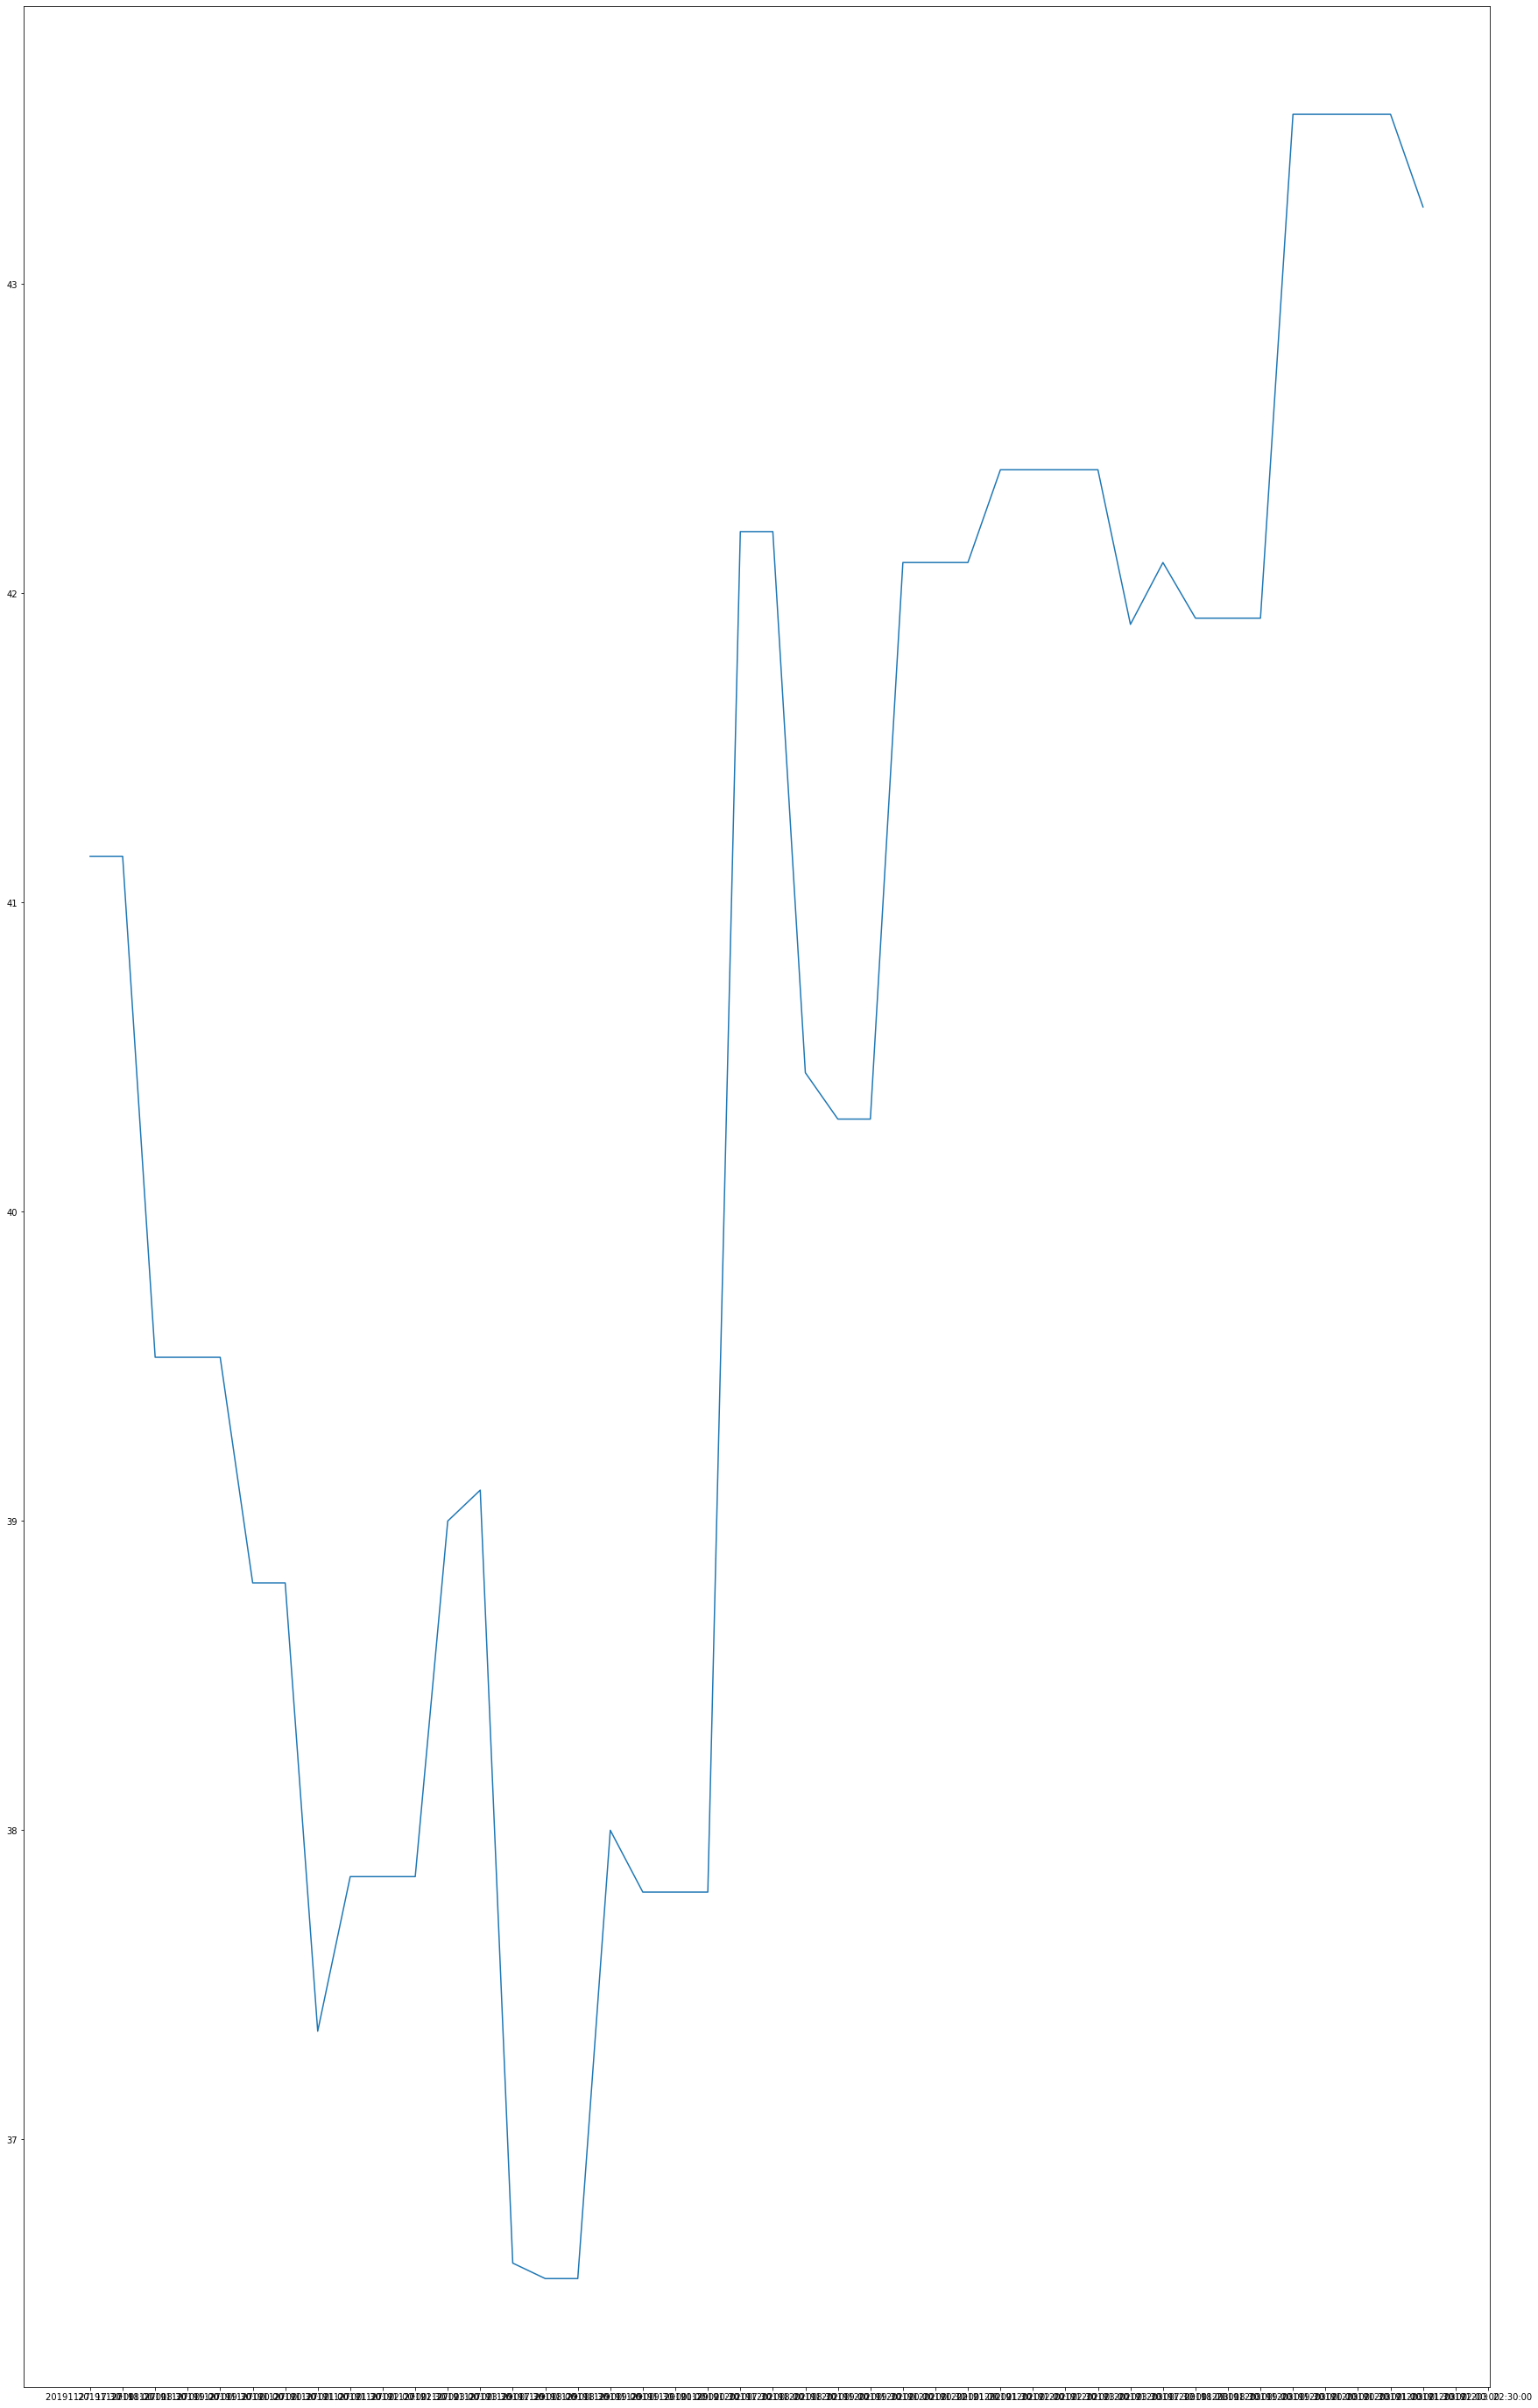

In [48]:
plt.plot(df_to_draw)
plt.rcParams['figure.figsize'] = [30, 50]
plt.show()

In [324]:
res2.loc[:,res2.columns.get_level_values(2) > 300.]

Empty DataFrame
Columns: []
Index: [2019-11-25 00:00:00, 2019-11-26 00:00:00, 2019-11-27 00:00:00, 2019-11-29 00:00:00]

In [328]:
df_to_show = res2.loc[:,res2.columns.get_level_values(2) > 300.]
df_to_show.columns.levels[2]

Float64Index([175.0, 180.0], dtype='float64')

In [29]:
plt.rcParams['figure.figsize'] = [20, 10]

# df_to_show = res2['P']['20191213']
# df_to_show = df_to_show[df_to_show > 250.0]

# Draw CALL options
exp = '20200117' # 20191206, 20191213, 20191227
call_options = res2['C'][exp].loc[:,res2['C'][exp].columns.get_level_values(0) > 250.]
call_options = call_options.loc[:,call_options.columns < 351.]
plt.plot(call_options)
plt.legend(call_options.columns)
plt.show()

# Draw PUT options
exp = '20200117' # 20191206, 20191213, 20191227
put_options = res2['P'][exp].loc[:,res2['P'][exp].columns.get_level_values(0) > 320.]
put_options = put_options.loc[:,put_options.columns < 361.]
plt.plot(put_options)
plt.legend(put_options.columns)
plt.title = 'PUT'
plt.show()
print(res2)
print(np.flip(put_options.columns.values))

NameError: name 'res2' is not defined

In [167]:
! git commit -a -m 'In work'
! git push

[version_2 e6e712a] In work
 2 files changed, 12612 insertions(+), 21520 deletions(-)
 rewrite .ipynb_checkpoints/test-checkpoint.ipynb (80%)
 rewrite test.ipynb (80%)
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 4 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (4/4), 14.15 KiB | 1.09 MiB/s, done.
Total 4 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/SVGalich/tws_trader.git
   728ffe8..e6e712a  version_2 -> version_2


## Гипотезы
1. Пересечение прямых Пут-Страйк различных дат экспирации: сигнал для сделки! Происходят при резких колебаниях underlying актива.